In [174]:
# Parameters
attr_path = "/srv/stemly/data/7/index/3/attributes/attributes.csv"
index_path = "/srv/stemly/data/7/index/3/index/index.csv"
committed_files = ["/srv/stemly/data/7/index/3/timeseries/993/commit/ts.0/13.1661315396541.parquet",
                   "/srv/stemly/data/7/index/3/timeseries/993/commit/ts.0/13.1662444054358.parquet",
                   "/srv/stemly/data/7/index/3/timeseries/993/commit/ts.0/13.1662553683649.parquet"]
predict_ts_path = "/srv/stemly/data/7/index/3/timeseries/1434/staged/model/16/ts.predict.latest.parquet"
test_ts_path = "/srv/stemly/data/7/index/3/timeseries/1434/staged/model/16/ts.test.latest.parquet"
validate_ts_path = "/srv/stemly/data/7/index/3/timeseries/1434/staged/model/16/ts.validate.latest.parquet"
model = "custom"
model_file_id = "32"
model_resolution = None
reference_resolution = "MS"
project_offset = 1
project_periods = 18
project_resolution = "MS"
ts_train_start = "2020-07-01 00:00:00"
ts_train_v_end = "2022-05-01 00:00:00"
ts_train_t_end = "2022-04-01 00:00:00"
ts_train_p_end = "2022-06-01 00:00:00"
ts_test_start = "2022-04-01 00:00:00"
ts_test_end = "2022-05-01 00:00:00"
ts_test_duration = 1
ts_validate_start = "2022-05-01 00:00:00"
ts_validate_end = "2022-06-01 00:00:00"
ts_validate_duration = 1
ts_predict_start = "2022-06-01 00:00:00"
ts_predict_end = "2023-12-01 00:00:00"
ts_predict_duration = 18
redis_url = "redis://127.0.0.1:6300"
job_id = "6bf40e7f-aced-40f7-86fe-f49f8d23b343"
job_user_id = "3"
resource_id = "16"
resource_version = 1661403479559
resource_type = "modelbase"
workspace_id = "7"
job_name = "custom"
job_triggered_at = "2022-08-25 04:58:00"
job_triggered_by = "Mallikarjuna Reddy Padigapati"


price_file_paths = ["_input_data/price_df.parquet"]

In [175]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import tqdm 

from pg_features import get_features,get_events
from pg_model import NAIFCModel
from utils import get_dates, calc_metrics, install_old_pandas, upgrade_pandas

import seaborn as sns
from datetime import timedelta
import os
import write_data_table
from sklearn.preprocessing import LabelEncoder
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from statsmodels.tsa.forecasting.stl import STLForecast

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

pd.set_option('display.max_row', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', None)

In [176]:
workspace = 'w' + workspace_id
verbose = True

In [4]:
main_group_index = ['sku', 'customer', 'warehouse']
mat_group = 'sku'
freq = "MS"
load_data_from_local = False
export_data = True

In [5]:
price_index = 1103

In [6]:
pd.set_option('display.max_row', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', None)

In [7]:
if load_data_from_local :
    price_var = 'price'
    volume_var = 'dc_offtake'
    main_group_index = ['sku', 'customer', 'warehouse']
    mat_group = 'sku'
else :
    price_var = 'y'
    volume_var = 'y'
    main_group_index = ['id']
    mat_group = 'sku'

In [8]:
joining_keys = ["ts"] + main_group_index
joining_keys

['ts', 'id']

## Helper

In [9]:
def get_results(predict_df, all_dates):
    results = pd.DataFrame()
    for _id in predict_df.id.unique():
        ts = predict_df.loc[(predict_df["id"] == _id)].reset_index(
            drop=True)
        test = ts.loc[ts.ts.isin(all_dates["test"])].copy()

        metrics = calc_metrics(test.y, test.yhat)
        metrics.update({
            "id": _id,
            "test_start": all_dates["test"][0],
            "test_end": all_dates["test"][-1],
            "total_actual": test.y.sum(),
            "total_forecast": test.yhat.sum(),
        })
        results = results.append(metrics, ignore_index=True, sort=False)

    main_cols = ["id", "test_start", "test_end", "total_actual", "total_forecast"]
    results = results[main_cols + list(results.drop(columns=main_cols).columns)].copy()
    results["mad"] = np.abs(results["total_actual"] - results["total_forecast"])
    results["model"] = predict_df.model[0]

    return results

## Dates

## Load data

In [10]:
price_index = 1103

In [11]:
if load_data_from_local :
    att_df = pd.read_csv("../../Cleaned_Input/all_att_data.csv")
    vol_df = pd.read_parquet("../../Cleaned_Input/UI_Files/si_monthly_volume.parquet")
    price_df = pd.read_parquet("../../Cleaned_Input/UI_Files/si_monthly_price.parquet")
    list_price_df = pd.read_parquet("../../Cleaned_Input/UI_Files/si_monthly_price.parquet")
    
    vol_df.rename(columns={'date':'ts'},inplace=True)
    price_df.rename(columns={'date':'ts'},inplace=True)
    list_price_df.rename(columns={'date':'ts'},inplace=True)

if not load_data_from_local:
    path_index_val = os.listdir("/srv/stemly/data/{}/index".format(workspace_id))[0]
    path_index = "/srv/stemly/data/{}/index".format(workspace_id) + "/" + str(path_index_val)
    vol_df = pd.concat([pd.read_parquet(fp) for fp in committed_files])

    att_df = pd.read_csv(attr_path)
    price_parquet_file_path = path_index + "/timeseries/"+ str(price_index)+ "/commit/ts.0"
    price_file_names =  os.listdir(price_parquet_file_path)
    price_file_paths = [price_parquet_file_path+ "/" + i for i in price_file_names]
    print(price_file_paths)

    price_df = pd.concat([pd.read_parquet(fp) for fp in price_file_paths])


['/srv/stemly/data/7/index/3/timeseries/1103/commit/ts.0/13.1661315396541.parquet']


In [12]:
sub_group_index = ['ts','sku','customer']
att_df_sub = att_df[[ 'sku', 'customer', 'item_type', 'material', 'ph_level2', 'ph_level3',
       'sku_description', 'cases','uom']].drop_duplicates()


In [13]:
vol_df.rename(columns={volume_var:'y'},inplace=True)
price_df.rename(columns={price_var:'price'},inplace=True)

price_df = price_df[main_group_index+['price','ts']]
vol_df = vol_df[main_group_index+['y','ts']]

vol_df = vol_df.groupby(joining_keys).sum().reset_index()
price_df = price_df.groupby(joining_keys).mean().reset_index()
if not load_data_from_local:
    att_df.rename(columns={'__idx':'id'},inplace=True)

print(vol_df.shape)
df_base = pd.merge(vol_df, price_df, on =joining_keys, how='left')
df_base = pd.merge(df_base, att_df,  on = main_group_index, how='left')
df_base
df_base.loc[df_base['y'] < 0,'y'] = 0
print(df_base.shape)

df_sub = df_base[['ts','sku','customer','y','price']]
df_sub1 = df_sub.groupby(sub_group_index).agg({'y':'sum','price':'mean'}).reset_index()
df_sub1 = pd.merge(df_sub1,att_df_sub,on=['sku','customer'],how='left')
df_sub1['price'].replace([np.inf,0, 0.0, -np.inf],np.nan,inplace=True)
df_sub1['price'] = df_sub1.groupby(['sku','customer'])['price'].transform(lambda x: x.bfill())
df_sub1['price'] = df_sub1.groupby(['sku','customer'])['price'].transform(lambda x: x.ffill())
df_sub1['price'].replace([np.nan],0,inplace=True)
df_main = df_sub1.copy()
df_sub1.head()


(2409, 3)
(2409, 14)


ts           sku customer      y       price    item_type  material     ph_level2 ph_level3                           sku_description  cases uom
0 2020-07-01  815517026005    TMALL   49.0  263.877508        Cream  82314748  Ultra Repair       FAB  FAB ULTRA REPAIR CRM 6.0OZ 170GX12 JUL20     12   G
1 2020-07-01  815517026012    TMALL  164.0   73.642051        Cream  82314747  Ultra Repair       FAB  FAB UT RPAR CRM 2.0OZ 56.7GX24 TUB JUL20     24   G
2 2020-07-01  815517026029    TMALL    0.0  119.281356        Cream  82314725          Face       FAB   FAB CRM GRAPEFRUIT 2.0OZ 56.7GX24 SEP20     25   G
3 2020-07-01  815517026036    TMALL  614.0  112.946006        Cream  82314745  Ultra Repair       FAB  FAB UT RPAR CRM 2.0OZ 56.7GX24 JAR JUL20     24   G
4 2020-07-01  815517026043    TMALL    0.0  206.766623  Moisturizer  82314723  Ultra Repair       FAB  FAB UTRP MOISTURIZER 1.7OZ 50MLX24 SEP20     24  ML

In [14]:
df_main[ (df_main['sku'] == 815517026005) & (df_main['customer'] == 'TMALL') & (df_main['ts'] >= '2022-07-01')
        & (df_main['ts'] <= '2022-08-01')]

ts           sku customer      y       price item_type  material     ph_level2 ph_level3                           sku_description  cases uom
578 2022-07-01  815517026005    TMALL  175.0  240.064605     Cream  82314748  Ultra Repair       FAB  FAB ULTRA REPAIR CRM 6.0OZ 170GX12 JUL20     12   G
629 2022-08-01  815517026005    TMALL  108.0  240.064605     Cream  82314748  Ultra Repair       FAB  FAB ULTRA REPAIR CRM 6.0OZ 170GX12 JUL20     12   G

In [15]:
from dateutil.relativedelta import relativedelta
def generate_dates_new(
        last_test_date="2021-12-27",
        gap_in_days=28,
        test_horizon_in_days=28,
        version_skip = 28,
        fc_horizon_in_days=84,
        freq="W-Mon",
        n_rounds=2
):
    ts_test_end = pd.to_datetime(last_test_date) 
    ts_test_start = ts_test_end - pd.Timedelta(days=test_horizon_in_days - 1)
   
    ts_predict_start = ts_test_end + pd.Timedelta(days=1)
    ts_predict_end = ts_predict_start + pd.Timedelta(days=fc_horizon_in_days-1)

   
    test_dates = pd.date_range(
        start=ts_test_start,
        end=ts_test_end,
        freq=freq,
    )
    forecast_dates = pd.date_range(
        start=ts_predict_start,
        end=ts_predict_end,
        freq=freq,
    )
    a = test_dates[0].month
    all_dates_new = {
        a: {
            "test": test_dates,
            "forecast": forecast_dates,
        },
    }
    for k in range(n_rounds):
        a = a - 1
        if a == 0:
            a = 12
        test_dates = pd.date_range(
            start=test_dates[0]- relativedelta(months=version_skip),
            end=test_dates[-1] - relativedelta(months=version_skip),
            freq=freq
        )
        forecast_dates = pd.date_range(
            start=forecast_dates[0]- relativedelta(months=version_skip),
            end=forecast_dates[-1] - relativedelta(months=version_skip),
            freq=freq
        )
        all_dates_new.update({
            a: {
                "test": test_dates,
                "forecast": forecast_dates,
            }
        })
    return all_dates_new


In [16]:
ts_test_end = "2022-08-01 00:00:00"
all_dates = generate_dates_new(
#     last_test_date="2021-12-27",
    last_test_date= ts_test_end,
    freq=freq,
    gap_in_days=30,
    version_skip = 1,
    fc_horizon_in_days = 367,
    test_horizon_in_days=30,
    n_rounds=2
)
all_dates

versions = []
for i in all_dates.keys():
    versions.append(i)
m=list(all_dates.keys())[0]
    
versions ,all_dates 

([8, 7, 6],
 {8: {'test': DatetimeIndex(['2022-08-01'], dtype='datetime64[ns]', freq='MS'),
   'forecast': DatetimeIndex(['2022-09-01', '2022-10-01', '2022-11-01', '2022-12-01', '2023-01-01', '2023-02-01', '2023-03-01', '2023-04-01', '2023-05-01', '2023-06-01', '2023-07-01', '2023-08-01'], dtype='datetime64[ns]', freq='MS')},
  7: {'test': DatetimeIndex(['2022-07-01'], dtype='datetime64[ns]', freq='MS'),
   'forecast': DatetimeIndex(['2022-08-01', '2022-09-01', '2022-10-01', '2022-11-01', '2022-12-01', '2023-01-01', '2023-02-01', '2023-03-01', '2023-04-01', '2023-05-01', '2023-06-01', '2023-07-01'], dtype='datetime64[ns]', freq='MS')},
  6: {'test': DatetimeIndex(['2022-06-01'], dtype='datetime64[ns]', freq='MS'),
   'forecast': DatetimeIndex(['2022-07-01', '2022-08-01', '2022-09-01', '2022-10-01', '2022-11-01', '2022-12-01', '2023-01-01', '2023-02-01', '2023-03-01', '2023-04-01', '2023-05-01', '2023-06-01'], dtype='datetime64[ns]', freq='MS')}})

In [17]:
data = df_main.copy()
data.head()

unique_id = data[['sku','customer']].drop_duplicates().reset_index(drop=True)
unique_id['id'] = unique_id.index
data = pd.merge(data,unique_id,on=['sku','customer'])
data.head()



def to_days(x):
    switcher = {0: "Mon", 1: "Tue", 2: "Wed", 3: "Thu", 4: "Fri", 5: "Sat", 6: "Sun"}
    return switcher.get(x)
def week_of_month(date_value):
    return (date_value.isocalendar()[1] - date_value.replace(day=1).isocalendar()[1] + 1)
data["month"] = data["ts"].dt.month 
data["year"] = data["ts"].dt.year 

print(data.shape)
print(data.columns)
id_sales_train = data[data['ts'] <= all_dates[m]['test'][0]]
id_sales_train = id_sales_train.groupby('id')['y'].sum().reset_index()
id_with_sales_df = id_sales_train[id_sales_train['y'] > 0]
id_with_sales = id_with_sales_df.id.unique()
data = data[(data['id'].isin(id_with_sales))]
print(data.shape)
data.head()

(675, 15)
Index(['ts', 'sku', 'customer', 'y', 'price', 'item_type', 'material', 'ph_level2', 'ph_level3', 'sku_description', 'cases', 'uom', 'id', 'month', 'year'], dtype='object')
(675, 15)


ts           sku customer       y       price item_type  material     ph_level2 ph_level3                           sku_description  cases uom  id  month  year
0 2020-07-01  815517026005    TMALL    49.0  263.877508     Cream  82314748  Ultra Repair       FAB  FAB ULTRA REPAIR CRM 6.0OZ 170GX12 JUL20     12   G   0      7  2020
1 2020-08-01  815517026005    TMALL  1501.0  263.877508     Cream  82314748  Ultra Repair       FAB  FAB ULTRA REPAIR CRM 6.0OZ 170GX12 JUL20     12   G   0      8  2020
2 2020-09-01  815517026005    TMALL   103.0  263.877508     Cream  82314748  Ultra Repair       FAB  FAB ULTRA REPAIR CRM 6.0OZ 170GX12 JUL20     12   G   0      9  2020
3 2020-10-01  815517026005    TMALL  6780.0  263.877508     Cream  82314748  Ultra Repair       FAB  FAB ULTRA REPAIR CRM 6.0OZ 170GX12 JUL20     12   G   0     10  2020
4 2020-11-01  815517026005    TMALL  3996.0  263.877508     Cream  82314748  Ultra Repair       FAB  FAB ULTRA REPAIR CRM 6.0OZ 170GX12 JUL20     12   G   0     11  2020

## Features

In [18]:
gap = len(all_dates[m]["test"])
window = 4

In [19]:
df = data.copy()
df =  df[df['customer'] == 'TMALL']

In [20]:
from feature_engineering_nai import get_features
from feature_engineering_nai import get_events, get_events_full_data
from feature_engineering_nai import calc_metrics
from feature_engineering_nai import mean_encode

In [21]:
freq

'MS'

In [22]:
events = get_events()
events['festival'] = events['festival'].astype('int64')
events['promotion_specific_date'] = events['promotion_specific_date'].astype('int64')
events['main_promo'] = events['main_promo'].astype('int64')
events['medium_promo'] = events['medium_promo'].astype('int64')
events['small_promo'] = events['small_promo'].astype('int64')
events_weekly = []

for h in events.holiday.unique():
    # for each event, resample it to W-Mon
    e = events.loc[events.holiday == h]
    e = e.set_index("ds").resample(freq, label="left").first()
    e.dropna(inplace=True)
    events_weekly.append(e.reset_index())
event_types = pd.get_dummies(events["type"]).columns.to_list()
event_types1 = pd.get_dummies(events["impact"]).columns.to_list()
events_weekly = pd.concat(events_weekly)
tmp = []
for t in events_weekly.ds.unique():
    e = events_weekly.loc[events_weekly.ds == t].reset_index(drop=True)
    if len(e) == 1:
        tmp.append(e.drop(columns=["lower_window", "upper_window"]))
    else:
        e.drop(columns=["lower_window", "upper_window"], inplace=True)
        e["holiday"] = ",".join(e["holiday"].tolist())
        e["type"] = ",".join(e["type"].tolist())
        _sum = e[event_types].sum()
        for c in event_types:
            e[c] = _sum[c]
        tmp.append(e.drop_duplicates())
events_weekly = pd.concat(tmp)
events_weekly.sort_values(by="ds", inplace=True)
events_weekly.reset_index(inplace=True, drop=True)
del tmp, e
events_monthly =  events_weekly
events_monthly.sort_values(by="ds", inplace=True)
events_monthly.reset_index(drop=True, inplace=True)
events_monthly.head()
events_monthly.sort_values(by=['ds','type'], inplace = True)
events.sort_values(by=['ds','type'], inplace = True)

In [23]:
from pg_features import resample_data, make_future_df, extract_summary

In [122]:
value_var = 'y'
time_var="ts"
group_var="id"
non_static_cols=None
fill_with_nan = False
groups = None
summary_stats = None
use_val=False
nan_ratio=0.5
n_jobs=0
features_dfs = {}
for version in all_dates.keys():
    print("Resampling")
    df_resample = resample_data(
        df,
        value_var=value_var,
        time_var=time_var,
        group_var=group_var,
        freq=freq
    )
    print(df_resample.shape)

    # 2. make future
    print("Make future")
    df_future = make_future_df(
        df_resample,
        all_dates[version]["forecast"],
        date_col=time_var,
        non_static_cols=non_static_cols,
        fill_with_nan=fill_with_nan,
        freq=freq,
    )
     # 3. create days features
    print("Create days features")
    df_future["year"] = df_future["ts"].dt.year
    df_future["month"] = df_future["ts"].dt.month
    df_future["quarter"] = df_future["ts"].dt.quarter
    if freq == "W-Mon":
        df_future["woy"] = df_future["ts"].dt.isocalendar().week
        df_future["woy"] = df_future["woy"].astype(int)
    df_future["is_month_start"] = df_future["ts"].dt.is_month_start
    df_future["is_month_end"] = df_future["ts"].dt.is_month_end
    df_future["is_quarter_start"] = df_future["ts"].dt.is_quarter_start
    df_future["is_quarter_end"] = df_future["ts"].dt.is_quarter_end
    df_future["is_quarter_start"] = df_future["ts"].dt.is_quarter_start
    df_future["is_year_start"] = df_future["ts"].dt.is_year_start
    df_future["is_year_end"] = df_future["ts"].dt.is_year_end
    if groups is None:
        groups = [
            ["sku"],
            ["sku", "month"],
            ["month"]
        ]
        if freq == "MS":
            groups = groups[:-1]

    print("Create summary features")
    print(groups)
    df_summary = df_future.copy()
    for g in groups:
        df_summary = extract_summary(
            df_summary,
            all_dates[version],
            group=g,
            var_name=value_var,
            summary_stats=summary_stats,
            use_val=use_val,
        )
    
    df_feature = df_summary.copy()
    df_with_event =  get_events_full_data(df_feature, events_monthly, events, event_types, event_types1)
    
    
    _df = df_feature.copy()
    outlier_quantile=0.9
    _df = _df.loc[_df.ts < all_dates[8]["test"].min()].reset_index()
    aa = []
    for _id in _df.id.unique():

        ts = _df.loc[_df.id == _id]
        outliers = np.quantile(ts.y, outlier_quantile)
        ts = ts.loc[ts.y <= outliers]
        aa.append(ts)
    aa = pd.concat(aa)
    #aa = aa[aa['y'] > 0]
    avgs = aa.groupby(["id"])["y"].mean().reset_index()
    avgs.rename(columns={"y": "average_train_demand"}, inplace=True)
    df_with_train = pd.merge(df_with_event.copy(), avgs, on=["id"], how="left")
    print(version)
    a = df_with_train
    a = a[ (a['sku'] == 815517026005) & (a['ts'] == '2022-07-01')]
    a = a[['ts','y']]
    print(a)
    
    cols = ["y", "days_to_next_event", "days_since_last_event", "weeks_to_next_event", "weeks_since_last_event"]

    _df = df_with_train.copy()
    _df["lag_demand"] = _df.groupby(["id"])["y"].shift(12)
    _df.loc[_df['lag_demand'].isnull(),'lag_demand'] = _df.loc[_df['lag_demand'].isnull(),'y_mean_sku_month'] 
    df_with_train = _df.copy()
    features_dfs.update({version: df_with_train})


Resampling
(409, 15)
Make future
Create days features
Create summary features
[['sku'], ['sku', 'month']]
['sku', 'y_sum_sku', 'y_mean_sku', 'y_max_sku', 'y_min_sku', 'y_std_sku']
['sku', 'month', 'y_sum_sku_month', 'y_mean_sku_month', 'y_max_sku_month', 'y_min_sku_month', 'y_std_sku_month']
['festival', 'promotion_specific_date']
8
           ts      y
24 2022-07-01  175.0
Resampling
(409, 15)
Make future
Create days features
Create summary features
[['sku'], ['sku', 'month']]
['sku', 'y_sum_sku', 'y_mean_sku', 'y_max_sku', 'y_min_sku', 'y_std_sku']
['sku', 'month', 'y_sum_sku_month', 'y_mean_sku_month', 'y_max_sku_month', 'y_min_sku_month', 'y_std_sku_month']
['festival', 'promotion_specific_date']
7
           ts      y
24 2022-07-01  175.0
Resampling
(409, 15)
Make future
Create days features
Create summary features
[['sku'], ['sku', 'month']]
['sku', 'y_sum_sku', 'y_mean_sku', 'y_max_sku', 'y_min_sku', 'y_std_sku']
['sku', 'month', 'y_sum_sku_month', 'y_mean_sku_month', 'y_max_sku

In [121]:
a = features_dfs[7]
a[ (a['sku'] == 815517026005) & (a['ts'] == '2022-07-01')]

id         ts      y           sku customer       price item_type  material     ph_level2 ph_level3                           sku_description  cases uom  month  year  quarter  is_month_start  is_month_end  is_quarter_start  is_quarter_end  is_year_start  is_year_end  y_sum_sku  y_mean_sku  y_max_sku  y_min_sku    y_std_sku  sku_percent  y_sum_sku_month  y_mean_sku_month  y_max_sku_month  y_min_sku_month  y_std_sku_month  sku_month_percent     events       type impact  festival  promotion_specific_date  main_promo  medium_promo  small_promo last_event next_event  weeks_since_last_event  weeks_to_next_event  days_since_last_event  days_to_next_event  average_train_demand  lag_demand
24   0 2022-07-01  175.0  815517026005    TMALL  240.064605     Cream  82314748  Ultra Repair       FAB  FAB ULTRA REPAIR CRM 6.0OZ 170GX12 JUL20     12   G      7  2022        3            True         False              True           False          False        False    37203.0    1550.125     6981.0       49.0  1917.269624     0.021337            143.0              71.5             94.0             49.0        31.819805           0.000082  no_events  no_events    NaN       0.0                      0.0         0.0           0.0          0.0        618        9.9                       4                    8                     30                  62            891.863636        94.0

features_dfs = {}
for i in all_dates.keys():
    features_df = get_features(
        df.loc[df.ts <= all_dates[i]["test"].max()],
        all_dates[i],
        fill_with_nan=False,
        freq=freq,
        gap=gap,
        window=window,
        n_jobs=-1,
        use_val=False,
    )
    features_dfs.update({i: features_df})


In [ ]:
df.columns

ts_cols = ["id", "ts", "y"]
original_features = ["sku", "customer", 'item_type', 'material', 'ph_level2', 'ph_level3', 'sku_description', 'cases', 'uom', "price"]
dates_features = ["year", "month", "quarter", "is_month_start", "is_month_end", "is_quarter_start", "is_quarter_end", "is_year_start", "is_year_end"]
lag_features = [x for x in features_dfs[m].columns if "y_lag_" in x]
total_features = [x for x in features_dfs[m].drop(columns=ts_cols+original_features+dates_features+lag_features).columns[-60:]]
tsfresh_features = [x for x in features_dfs[m].drop(columns=ts_cols+original_features+dates_features+lag_features+total_features).columns]

In [123]:
features_dfs[m].to_csv("op/sss.csv")

## Model 1 Cluster

In [124]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder 
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

features_dfs[m] = features_dfs[m].drop(axis=1, labels=total_features)
features_dfs[m] = features_dfs[m].drop(axis=1, labels=tsfresh_features)

In [125]:
df.head()

ts           sku customer       y       price item_type  material     ph_level2 ph_level3                           sku_description  cases uom  id  month  year
0 2020-07-01  815517026005    TMALL    49.0  263.877508     Cream  82314748  Ultra Repair       FAB  FAB ULTRA REPAIR CRM 6.0OZ 170GX12 JUL20     12   G   0      7  2020
1 2020-08-01  815517026005    TMALL  1501.0  263.877508     Cream  82314748  Ultra Repair       FAB  FAB ULTRA REPAIR CRM 6.0OZ 170GX12 JUL20     12   G   0      8  2020
2 2020-09-01  815517026005    TMALL   103.0  263.877508     Cream  82314748  Ultra Repair       FAB  FAB ULTRA REPAIR CRM 6.0OZ 170GX12 JUL20     12   G   0      9  2020
3 2020-10-01  815517026005    TMALL  6780.0  263.877508     Cream  82314748  Ultra Repair       FAB  FAB ULTRA REPAIR CRM 6.0OZ 170GX12 JUL20     12   G   0     10  2020
4 2020-11-01  815517026005    TMALL  3996.0  263.877508     Cream  82314748  Ultra Repair       FAB  FAB ULTRA REPAIR CRM 6.0OZ 170GX12 JUL20     12   G   0     11  2020

In [165]:
drop_cols1 = [  'item_type', 'material', 
             'ph_level3', 'sku_description', 'cases', 'uom', 'year', 'quarter', 'lag_demand', 
             'is_month_start', 'is_month_end', 'is_quarter_start', 'is_quarter_end', 'is_year_start', 'y_sum_sku_month', 'y_max_sku_month', 'y_min_sku_month',
             'is_year_end', 'y_sum_sku', 'y_mean_sku', 'y_max_sku', 'y_min_sku', 'y_std_sku', 'sku_percent',
             'y_std_sku_month', 
             'sku_month_percent', 'events', 'type', 'impact', 'festival', 'promotion_specific_date', 
             'last_event', 'next_event', 
             'days_since_last_event', 'days_to_next_event', 'dummy_spike', 
             'dummy_event_spike', 'dummy_spike_before_event']

In [157]:
features_dfs[m].drop(drop_cols1, axis=1, errors = 'ignore').columns

Index(['id', 'ts', 'y', 'sku', 'customer', 'price', 'ph_level2', 'month', 'y_mean_sku_month', 'main_promo', 'medium_promo', 'small_promo', 'weeks_since_last_event', 'weeks_to_next_event', 'average_train_demand', 'lag_demand'], dtype='object')

In [166]:
datas = {}
encoders = {}
for i in range(len(versions)):
    dates = all_dates[versions[i]]
    f = features_dfs[versions[i]].copy()
    #f.drop(lag_features, axis=1, inplace=True, errors = 'ignore')
    f.drop(drop_cols1, axis=1, inplace=True, errors = 'ignore')
    # get train, test, predict
    train = f.loc[f.ts < np.min(dates["test"])].reset_index(drop=True)
    test = f.loc[f.ts.isin(dates["test"])].reset_index(drop=True)
    predict = f.loc[f.ts.isin(dates["forecast"])].reset_index(drop=True)
    all_data = pd.concat([train, test]).reset_index(drop=True)

    train["y"] = train["y"].astype(float)
    test["y"] = test["y"].astype(float)
    predict["y"] = np.nan
    all_data["y"] = all_data["y"].astype(float)
    
    x_train, y_train = train.drop(columns=["y", "ts"]), train["y"]
    x_test, y_test = test.drop(columns=["y", "ts"]), test["y"]
    x_predict, y_predict = predict.drop(columns=["y", "ts"]), predict["y"]
    x_all, y_all = all_data.drop(columns=["y", "ts"]), all_data["y"]

    for c in x_train.select_dtypes(include=["number", "bool_"]).columns:
        x_train[c] = np.nan_to_num(x_train[c], nan=-9999, posinf=-9999, neginf=-9999)
        x_test[c] = np.nan_to_num(x_test[c], nan=-9999, posinf=-9999, neginf=-9999)
        x_predict[c] = np.nan_to_num(x_predict[c], nan=-9999, posinf=-9999, neginf=-9999)
        x_all[c] = np.nan_to_num(x_all[c], nan=-9999, posinf=-9999, neginf=-9999)

    
    enc_cols = x_train.select_dtypes(exclude="number").columns.to_list()
    for col in enc_cols:
        enc = LabelEncoder()
        enc.fit(f[col])
        encoders.update({(versions[i], col): enc})
        x_train[col] = enc.transform(x_train[col])
        x_test[col] = enc.transform(x_test[col])
        x_predict[col] = enc.transform(x_predict[col])
        x_all[col] = enc.transform(x_all[col])
    print("forecast version {}".format(versions[i]))
    print(train.ts.min(), train.ts.max(), train.shape)
    print(test.ts.min(), test.ts.max(), test.shape)
    print(predict.ts.min(), predict.ts.max(), predict.shape)
    print()
    datas.update({
        versions[i] : {
            "all": all_data,
            "train": train,
            "test": test,
            "predict": predict,
            "x_train": x_train,
            "y_train": y_train,
            "x_test": x_test,
            "y_test": y_test,
            "x_predict": x_predict,
            "y_predict": y_predict,
            "x_all": x_all,
            "y_all": y_all
        }
    })

forecast version 8
2020-07-01 00:00:00 2022-07-01 00:00:00 (391, 15)
2022-08-01 00:00:00 2022-08-01 00:00:00 (18, 15)
2022-09-01 00:00:00 2023-08-01 00:00:00 (216, 15)

forecast version 7
2020-07-01 00:00:00 2022-06-01 00:00:00 (373, 15)
2022-07-01 00:00:00 2022-07-01 00:00:00 (18, 15)
2022-08-01 00:00:00 2023-07-01 00:00:00 (216, 15)

forecast version 6
2020-07-01 00:00:00 2022-05-01 00:00:00 (355, 15)
2022-06-01 00:00:00 2022-06-01 00:00:00 (18, 15)
2022-07-01 00:00:00 2023-06-01 00:00:00 (204, 15)



In [179]:
encoders

{(8, 'customer'): LabelEncoder(),
 (8, 'ph_level2'): LabelEncoder(),
 (7, 'customer'): LabelEncoder(),
 (7, 'ph_level2'): LabelEncoder(),
 (6, 'customer'): LabelEncoder(),
 (6, 'ph_level2'): LabelEncoder()}

In [172]:
datas[8]['all'].to_csv("op/ssal.csv")

In [149]:
datas[8]['train'].to_csv("op/ss.csv")

8 815517026005
8 815517026012
8 815517026029
8 815517026036
8 815517026043
8 815517026050
8 815517026067
8 815517026081
8 815517026265
8 815517026272
8 815517026999
8 815517027163
8 815517027170
8 815517027606
8 815517027613
8 815517025992
8 815517027491
8 815517028122


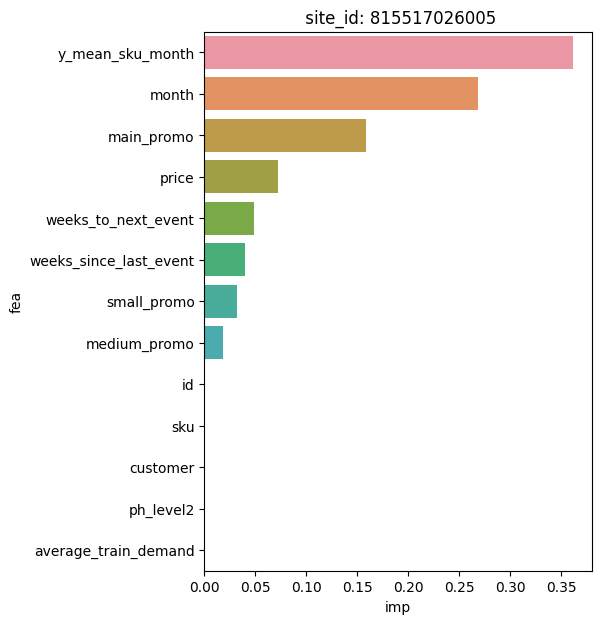

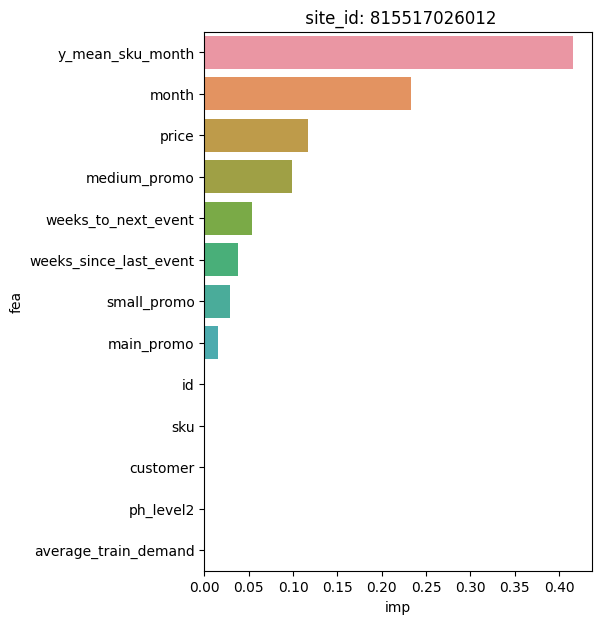

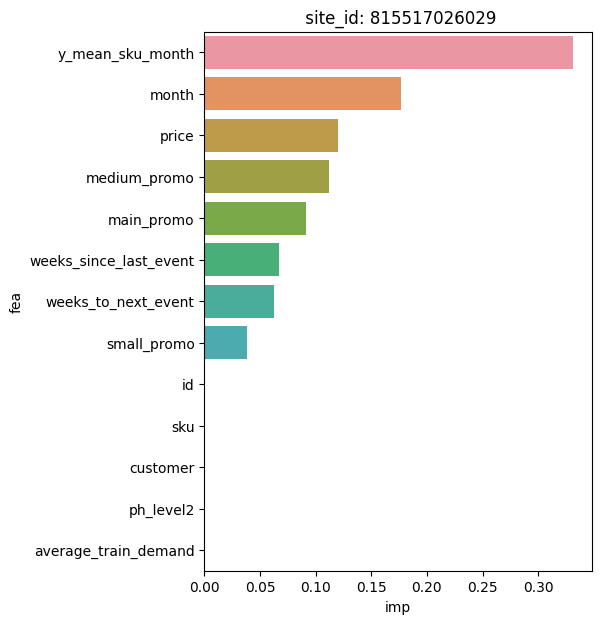

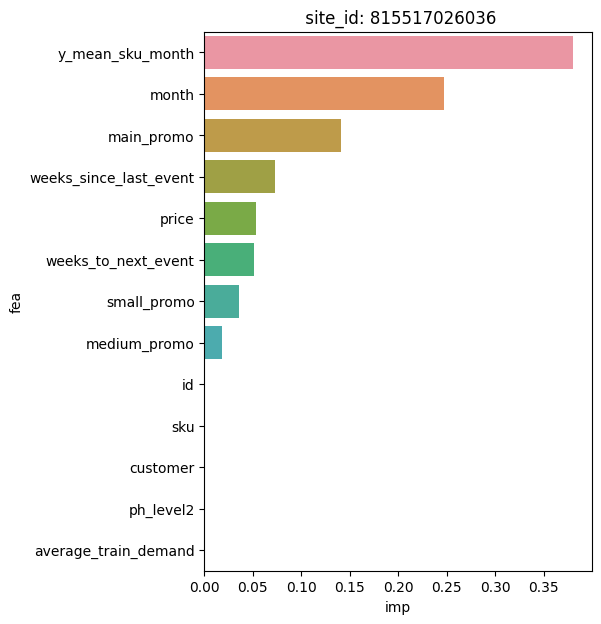

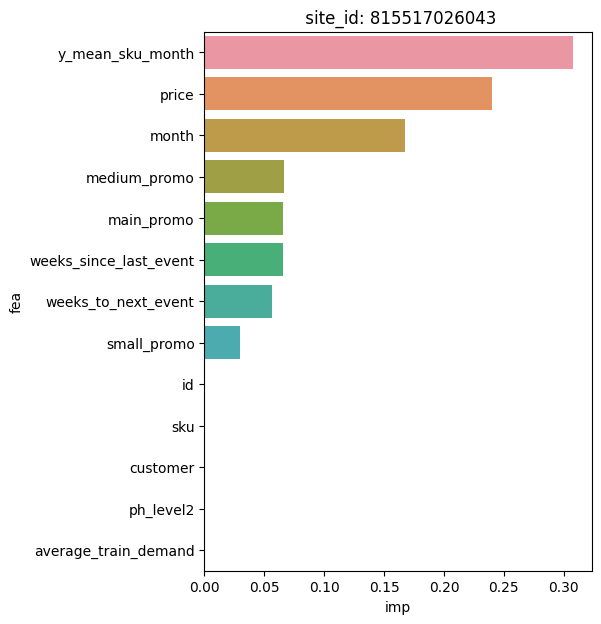

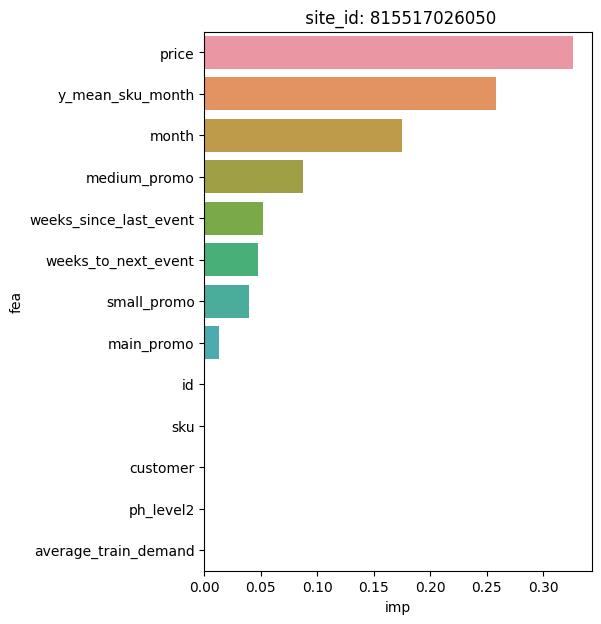

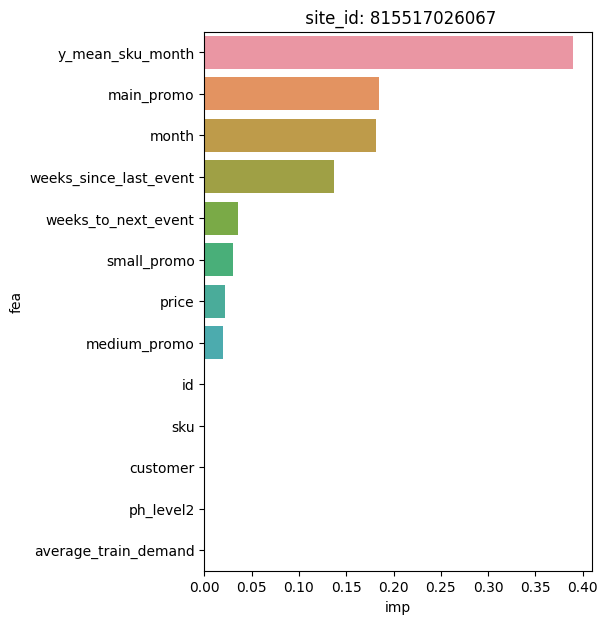

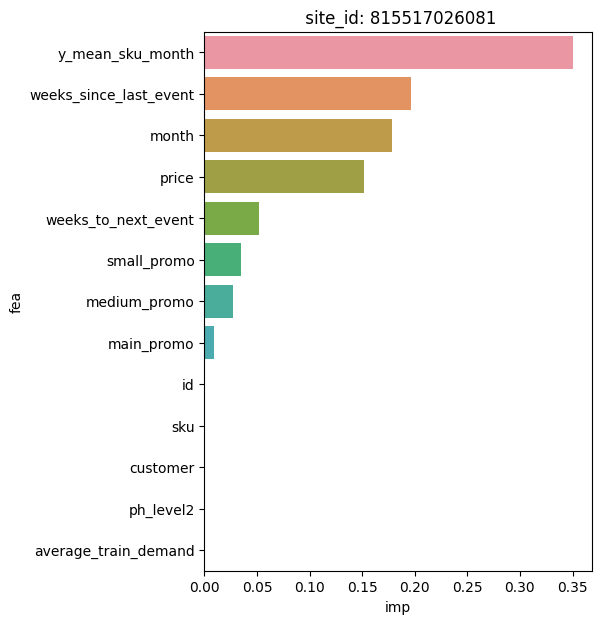

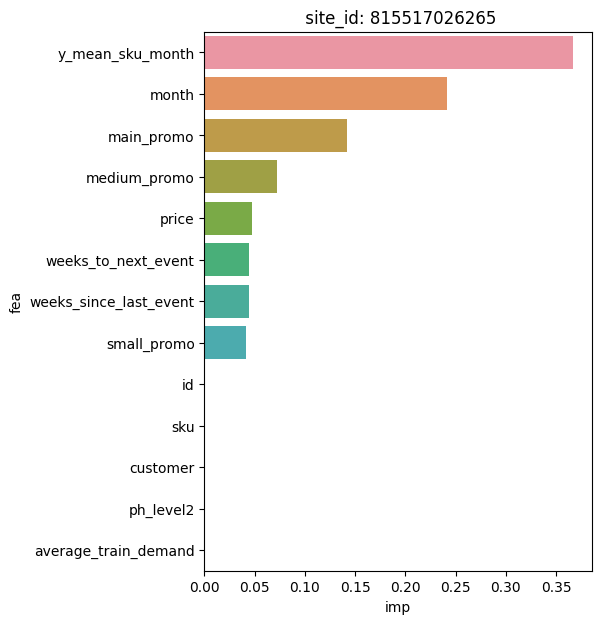

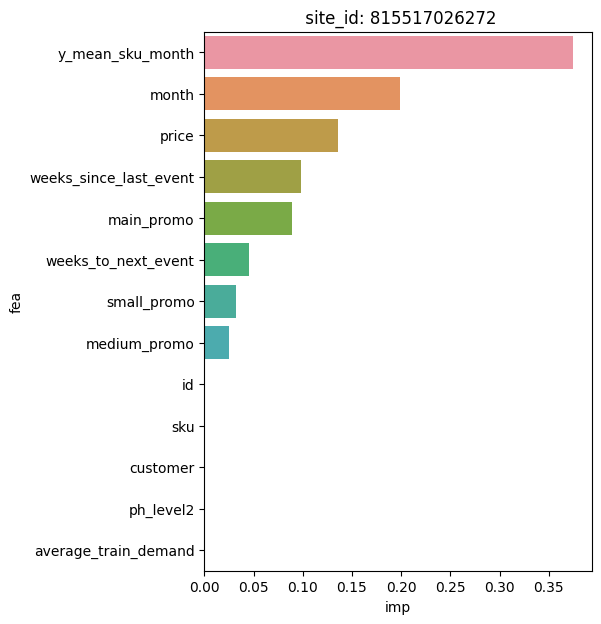

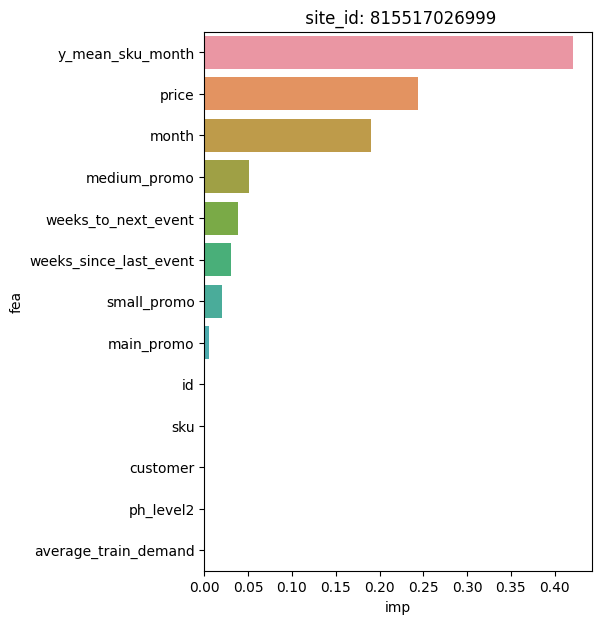

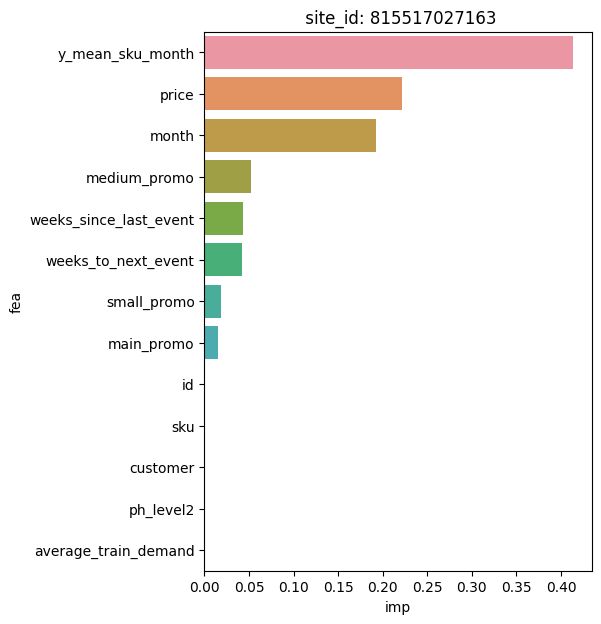

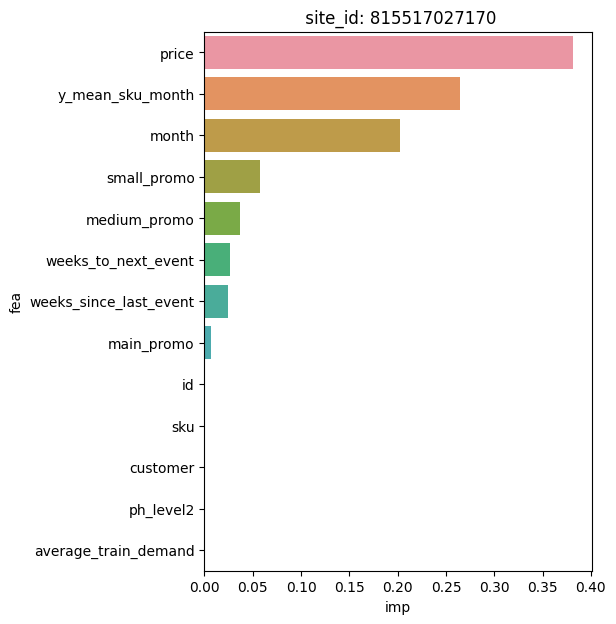

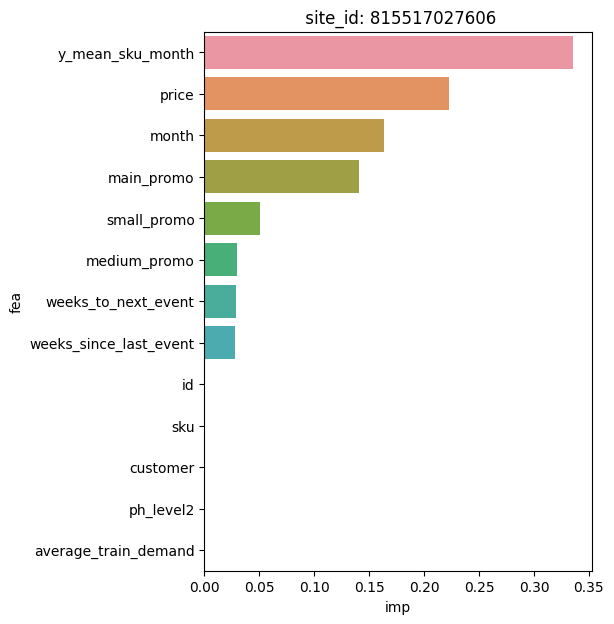

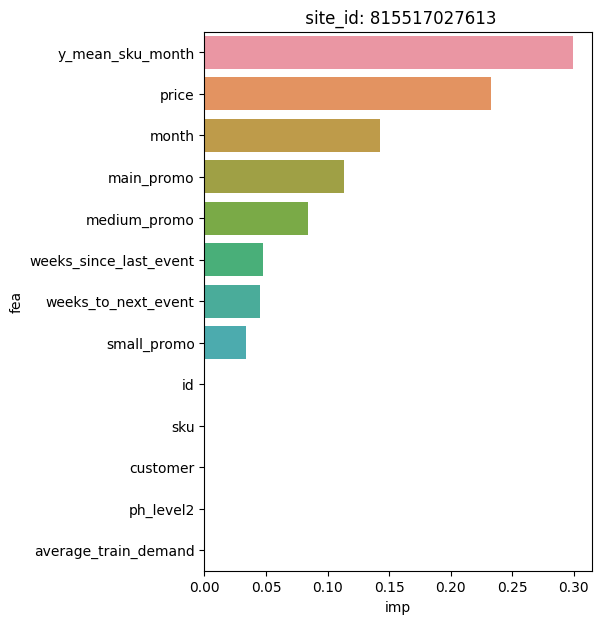

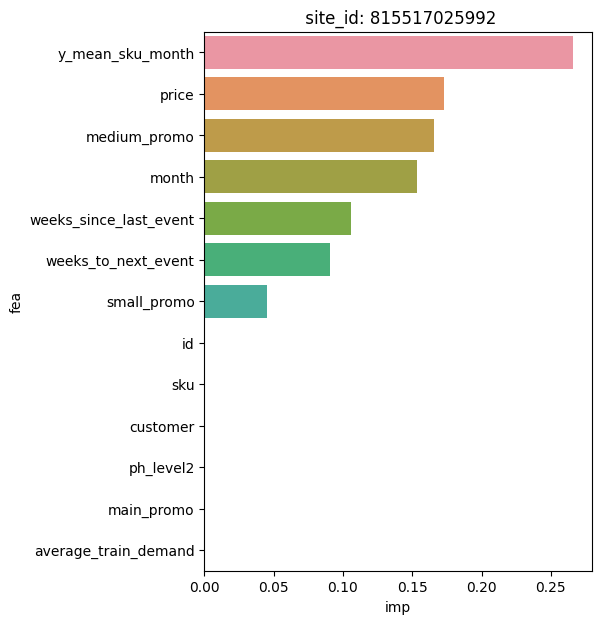

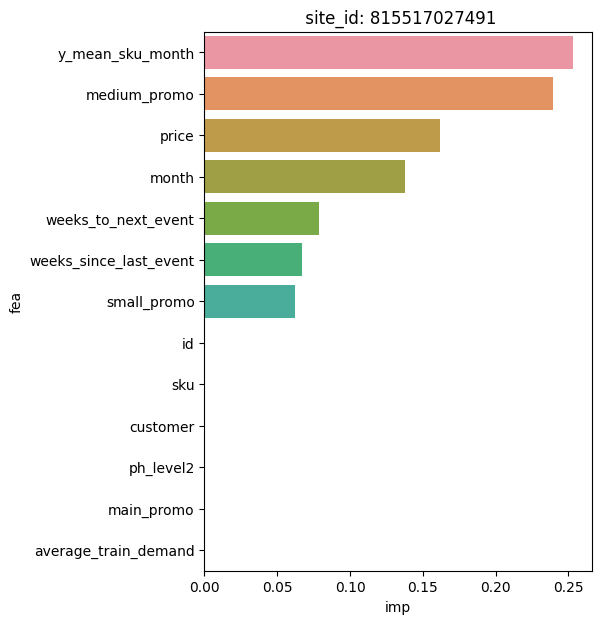

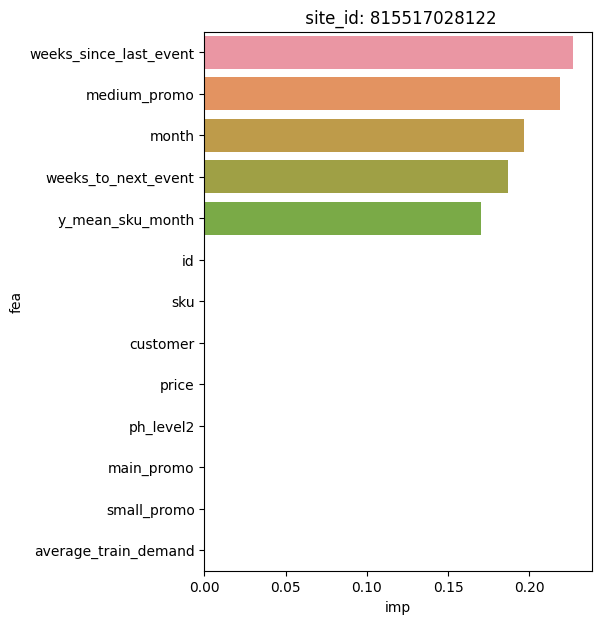

7 815517026005
7 815517026012
7 815517026029
7 815517026036
7 815517026043
7 815517026050
7 815517026067
7 815517026081
7 815517026265
7 815517026272
7 815517026999
7 815517027163
7 815517027170
7 815517027606
7 815517027613
7 815517025992
7 815517027491
7 815517028122


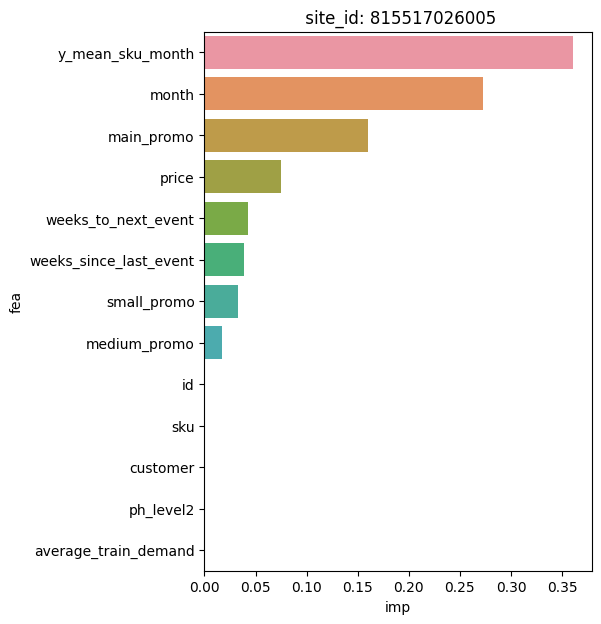

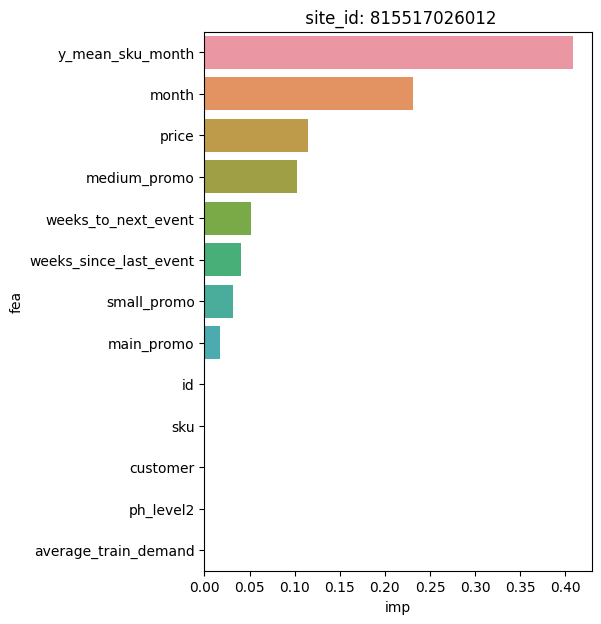

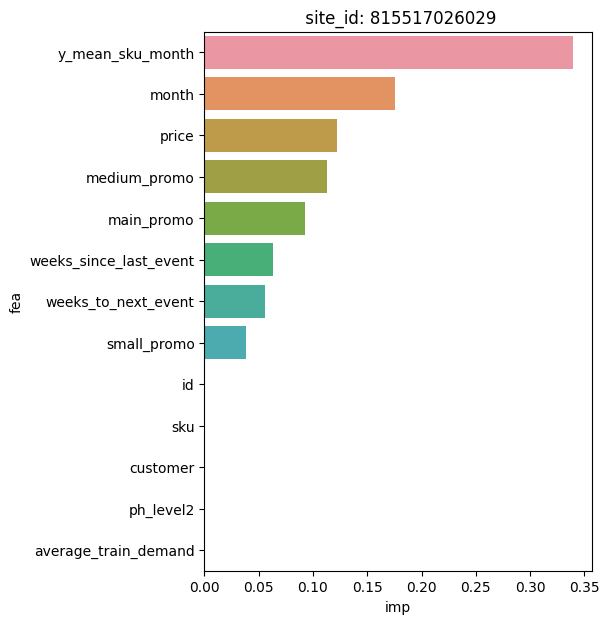

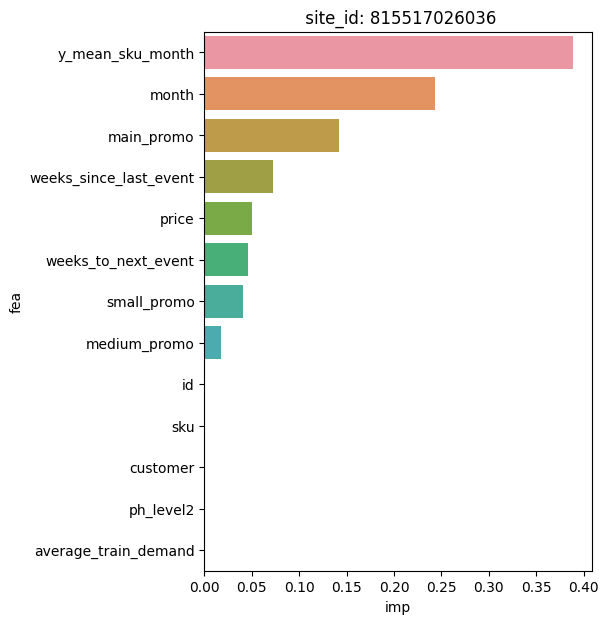

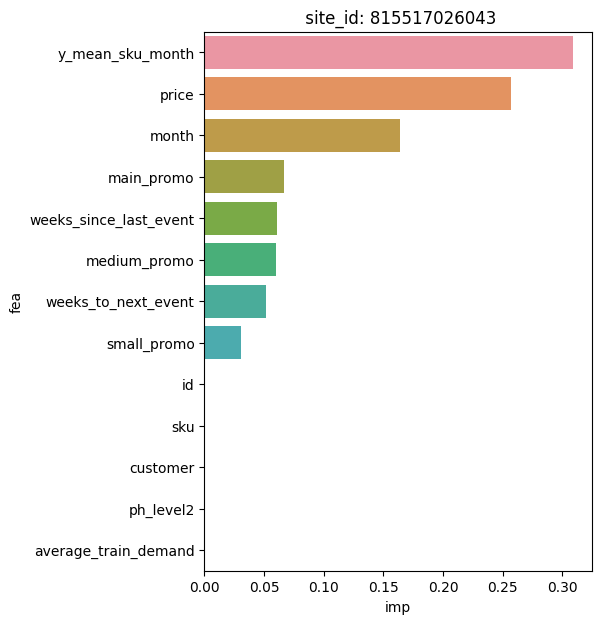

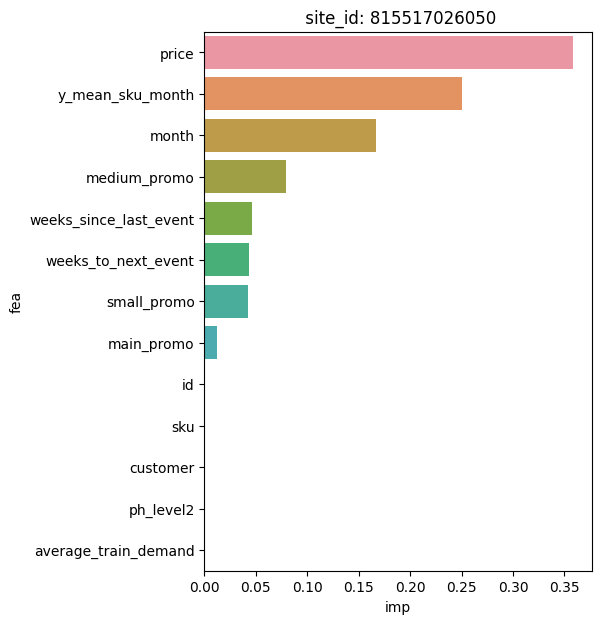

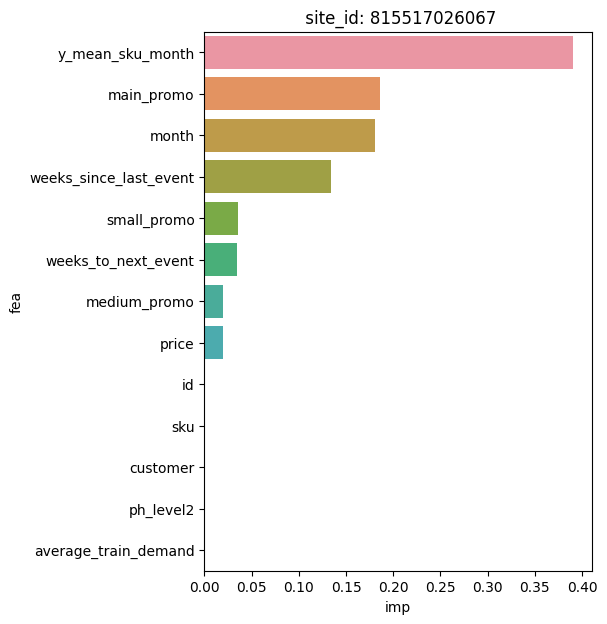

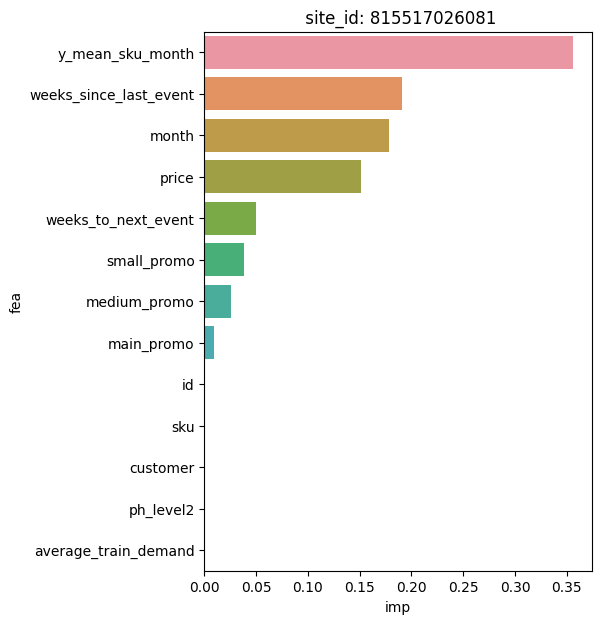

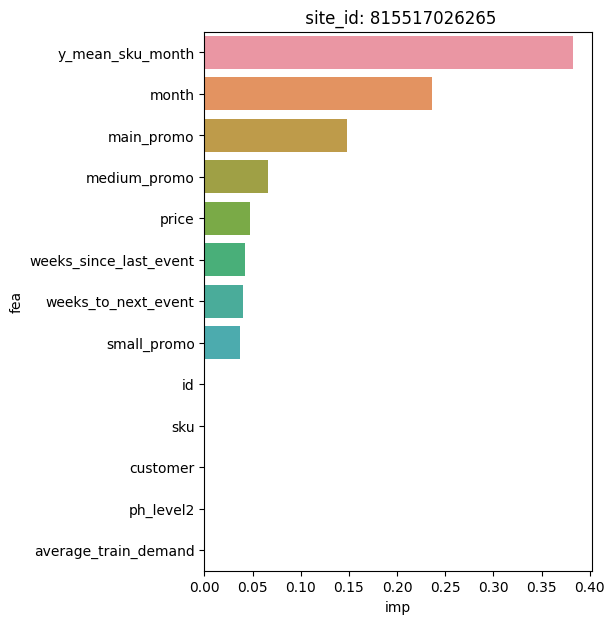

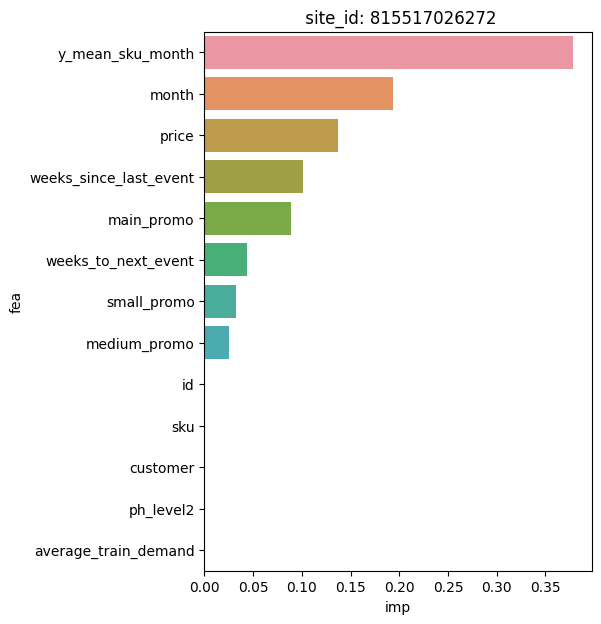

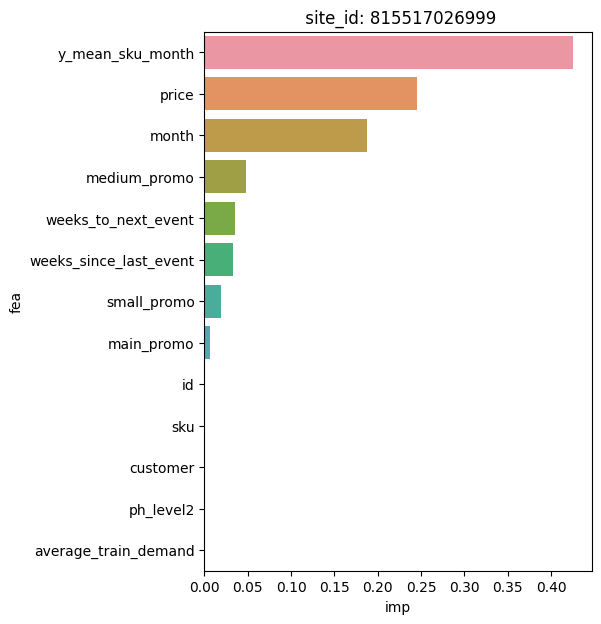

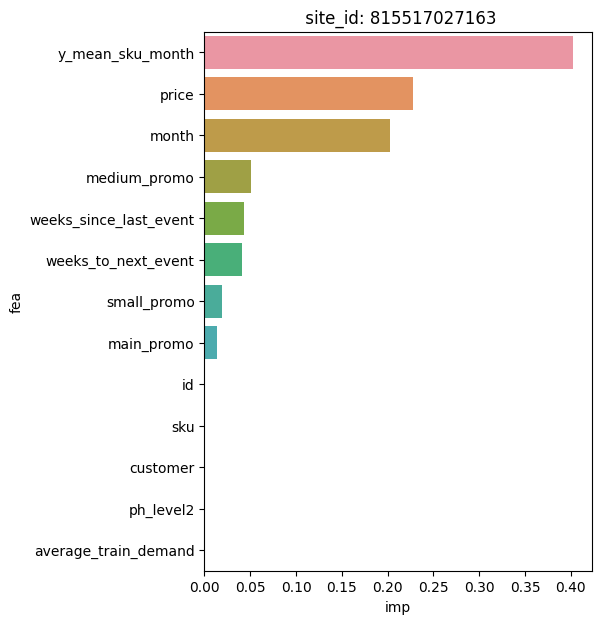

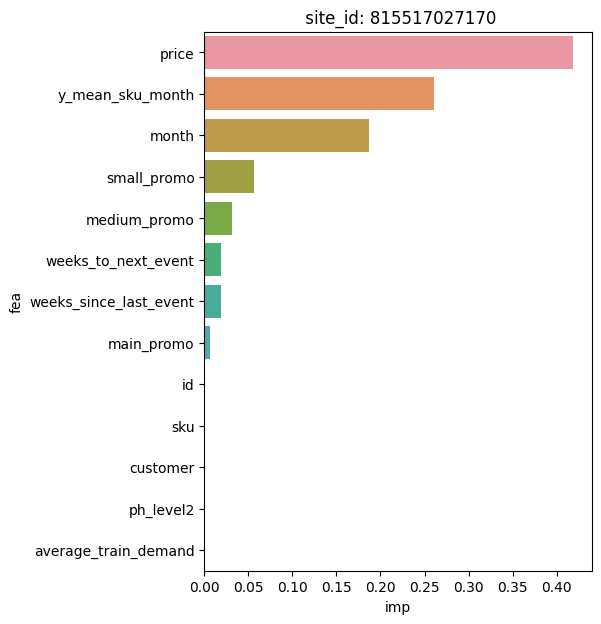

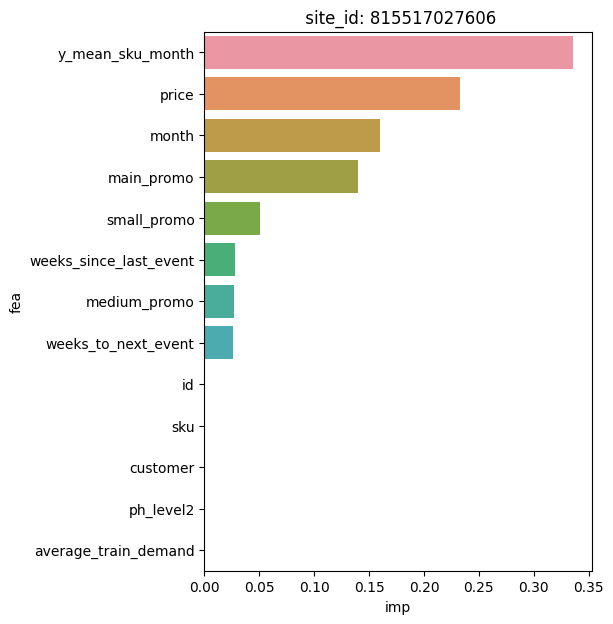

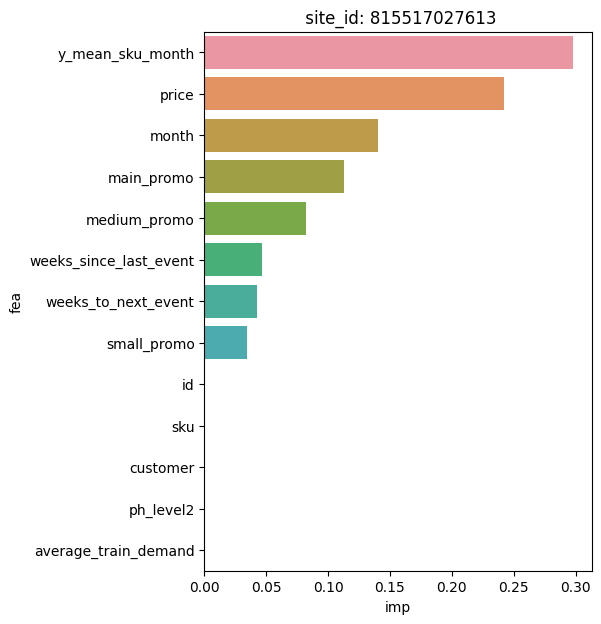

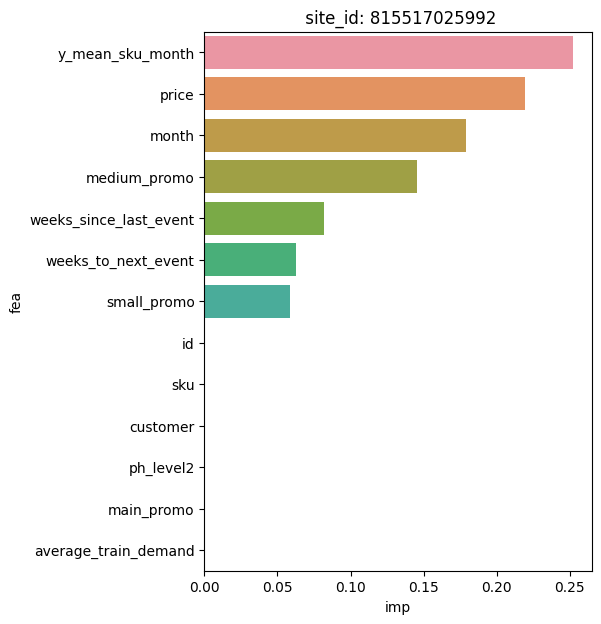

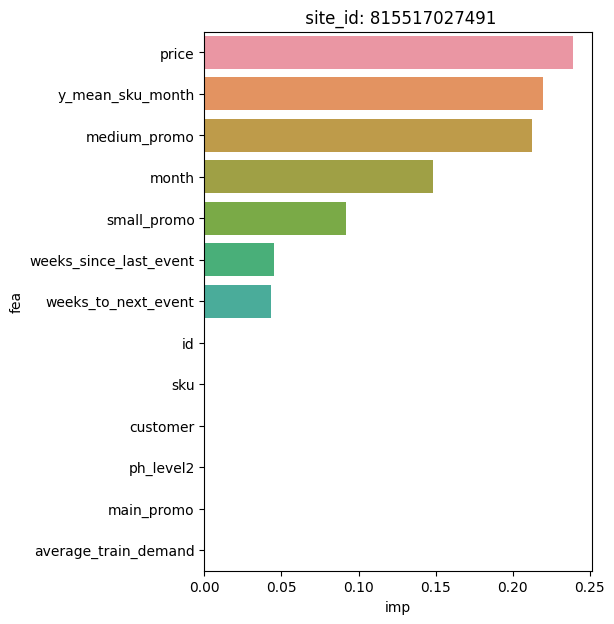

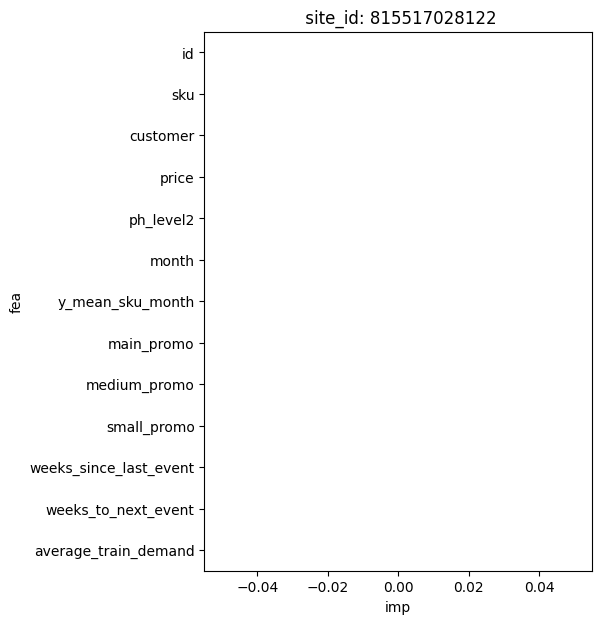

6 815517026005
6 815517026012
6 815517026029
6 815517026036
6 815517026043
6 815517026050
6 815517026067
6 815517026081
6 815517026265
6 815517026272
6 815517026999
6 815517027163
6 815517027170
6 815517027606
6 815517027613
6 815517025992
6 815517027491


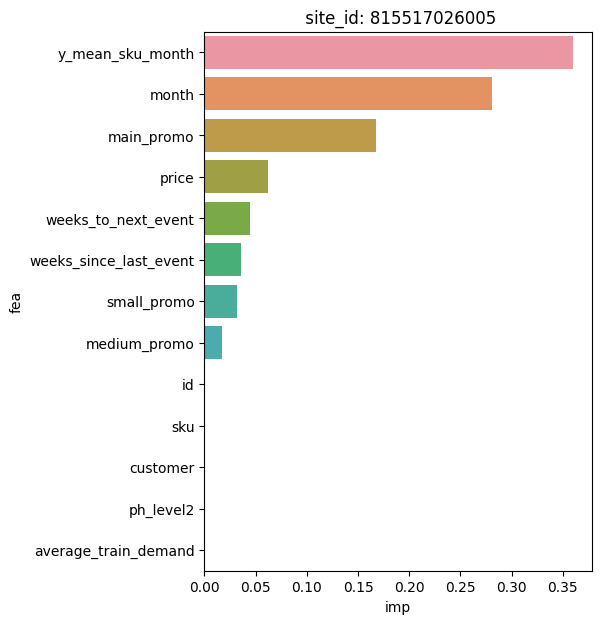

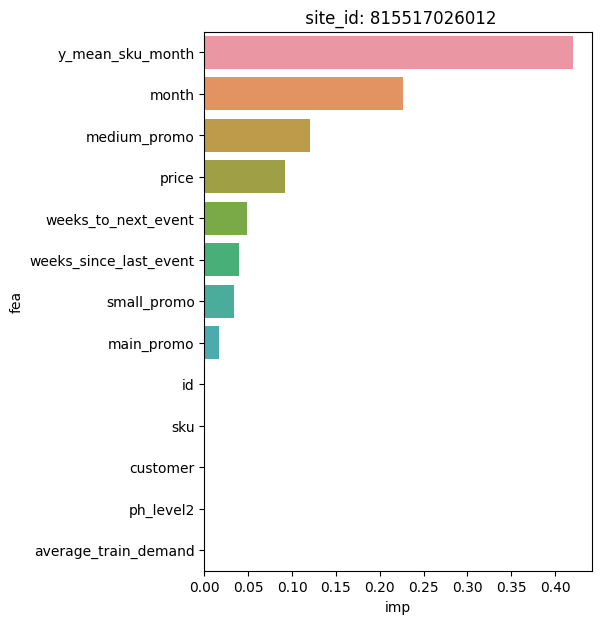

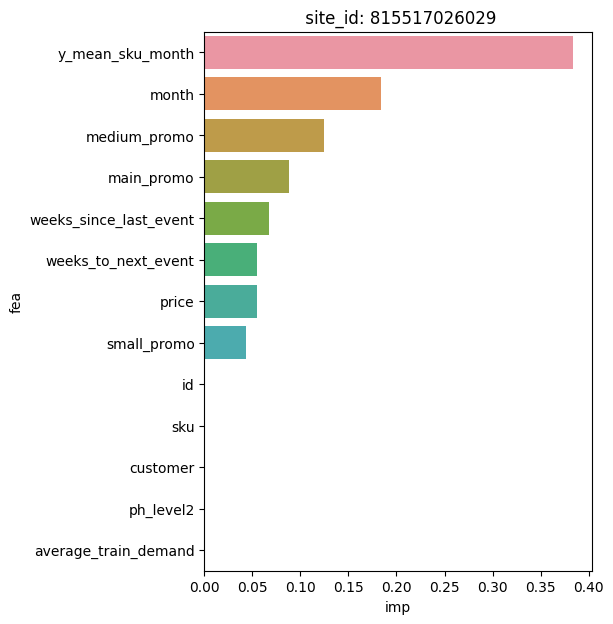

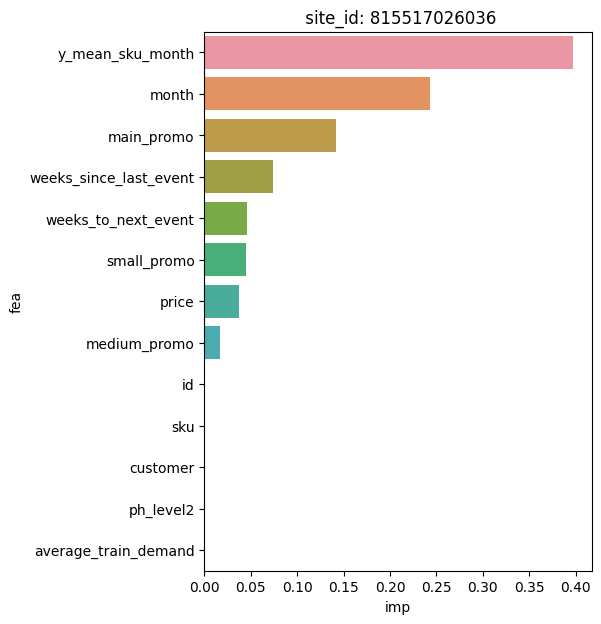

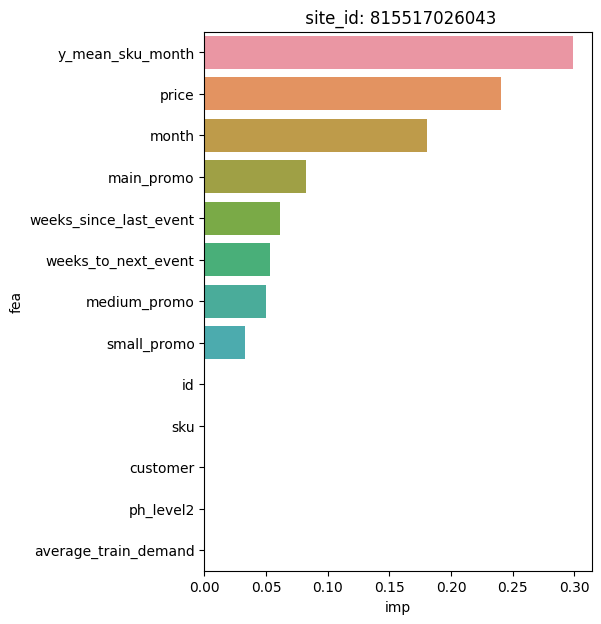

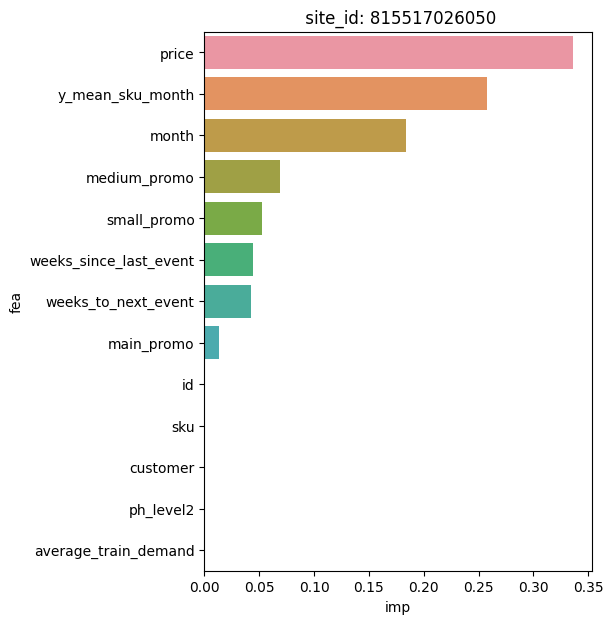

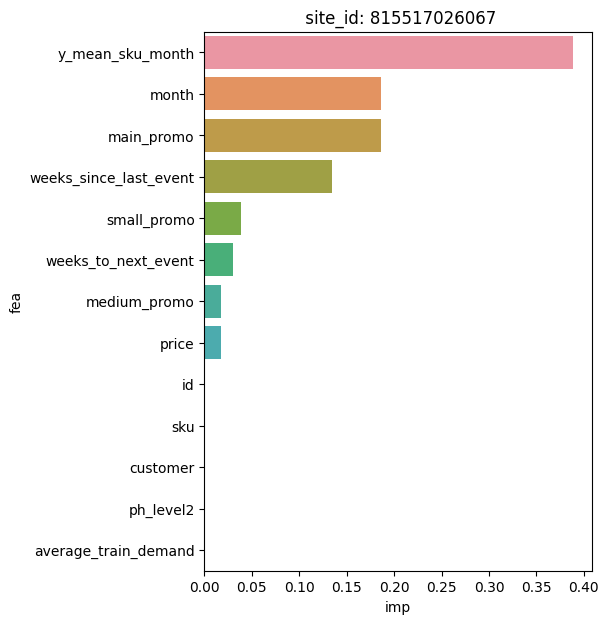

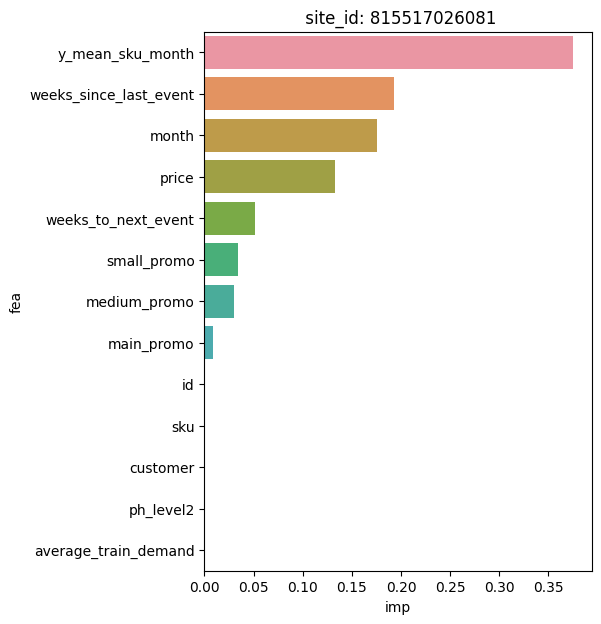

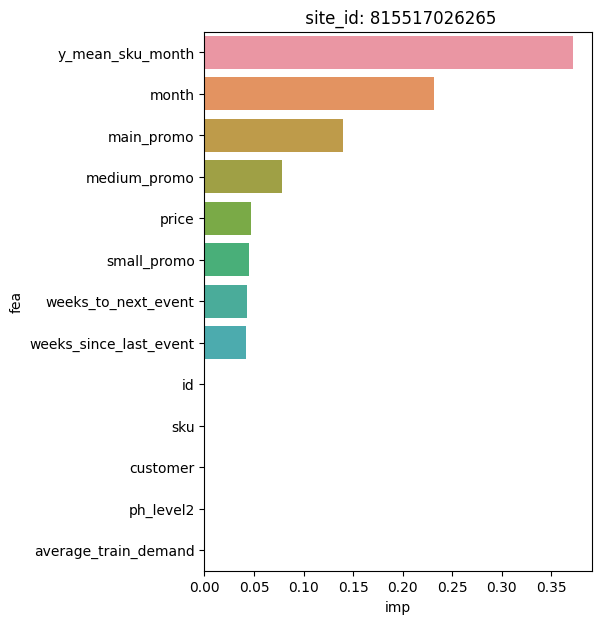

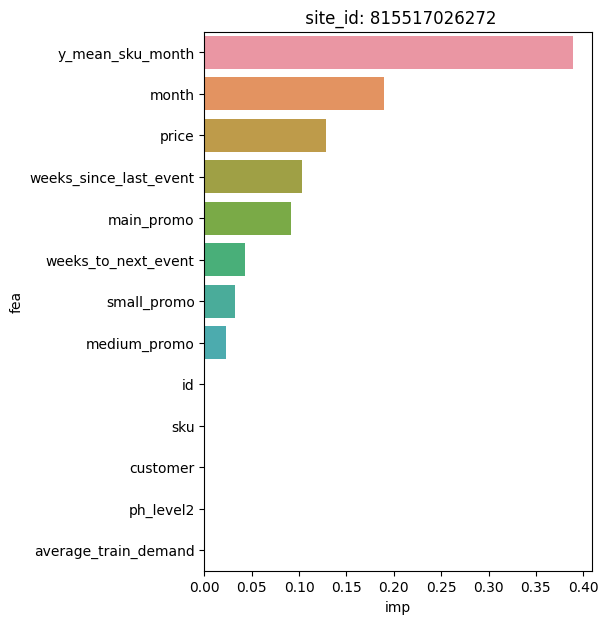

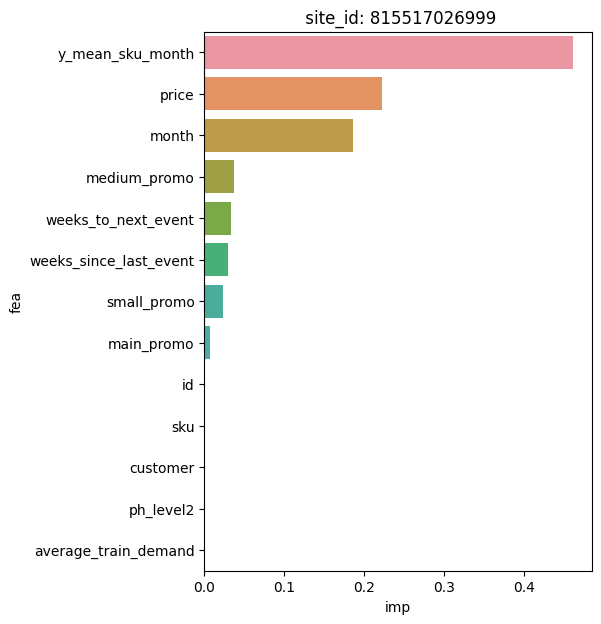

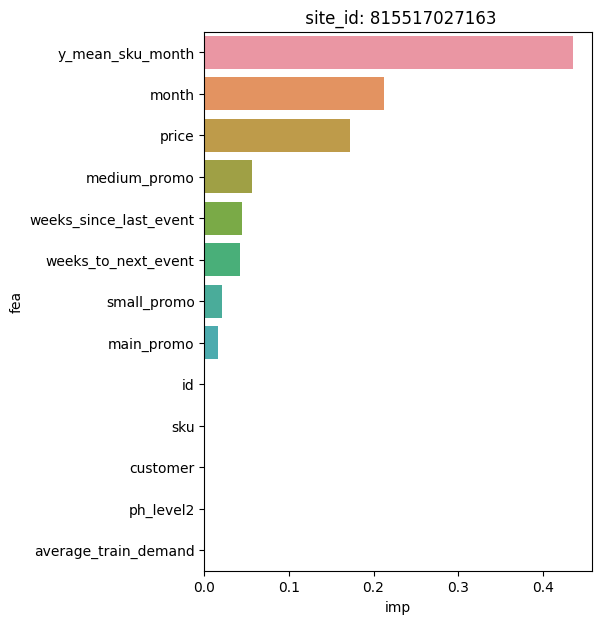

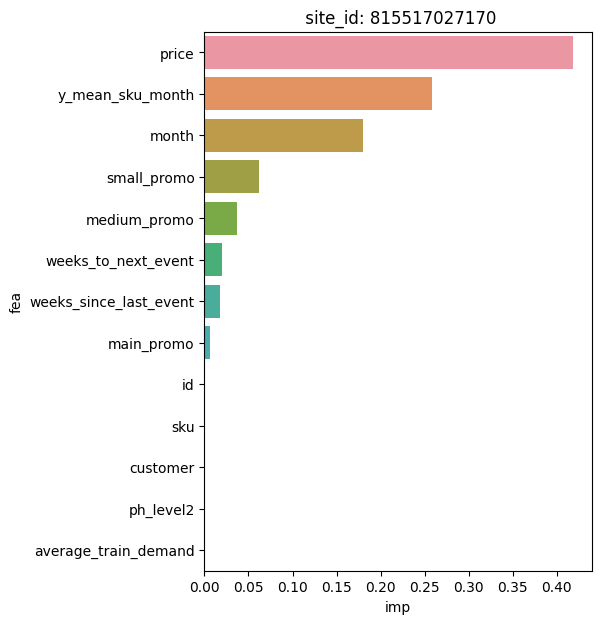

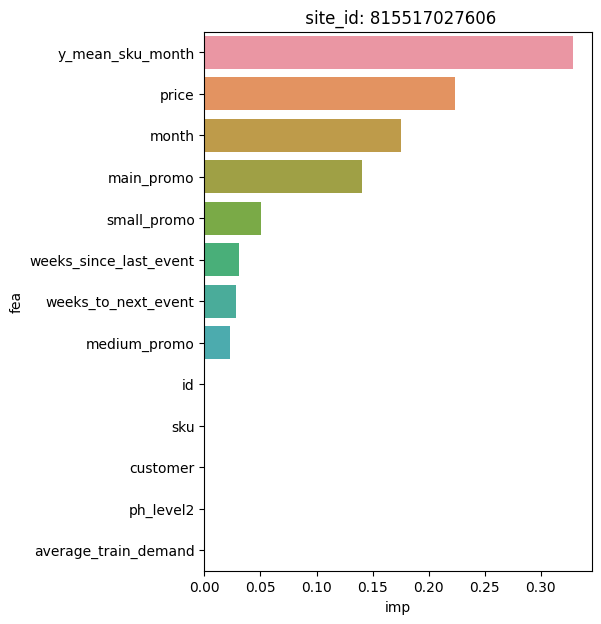

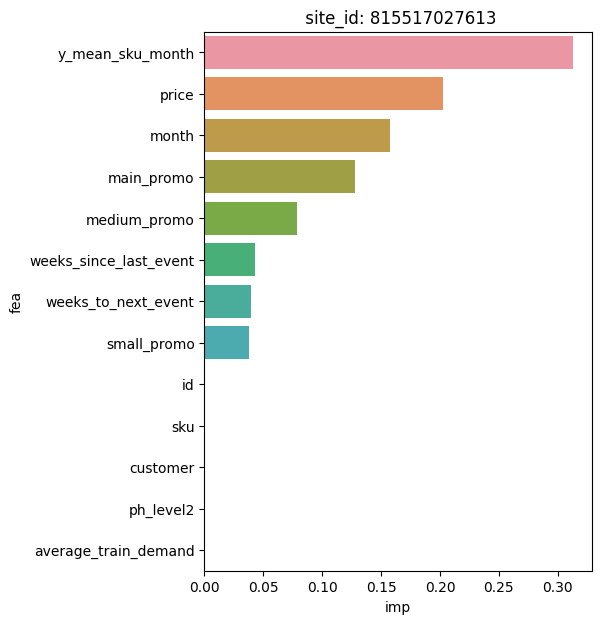

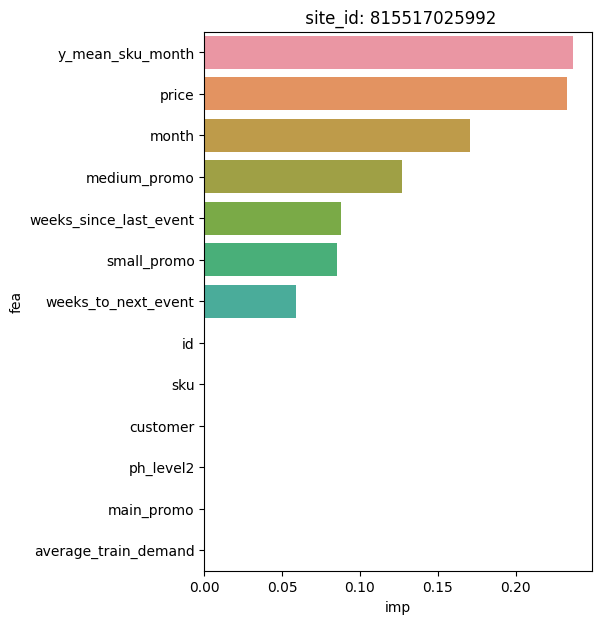

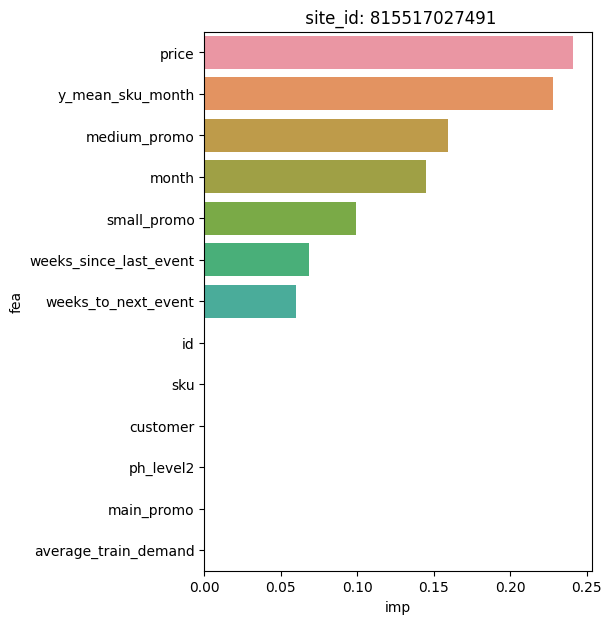

In [177]:
models = {}
clusters = {}
group_var = "sku"
model_name = "Model per customer"
n_clusters = [1]
drop_cols = ["year", "basic_material", "material_description", "is_month_start", "is_month_end", "is_quarter_start", "is_quarter_end", "is_year_start", "is_year_end"]
# drop_cols = drop_cols + tsfresh_features

for i in range(len(versions)):
    _x_train = datas[versions[i]]["x_train"].copy()
    _y_train = datas[versions[i]]["y_train"].copy()
 
   
    if (group_var != "ALL"):
        groups = datas[versions[i]]["x_train"][group_var].unique()
    else:
        groups = ["ALL"]
        
    _model = {}
    if(groups[0] != "ALL"):
        for this_group in groups:
            print(versions[i], this_group)
            __x_train = _x_train.loc[_x_train[group_var] == this_group].reset_index(drop=True)
            __y_train = _y_train.loc[_x_train[group_var] == this_group].reset_index(drop=True)

            model = RandomForestRegressor(
                n_estimators=1000,
                criterion="mse",
                max_features="sqrt",
                random_state=0,
                max_samples=0.9,
                n_jobs=-1,  
                verbose=0,
            ) 
            __x_train.to_csv("op/fdsfsd.csv")
            if len(drop_cols) == 0:
                model.fit(__x_train, __y_train)
            else:
                model.fit(__x_train.drop(columns=drop_cols, errors="ignore"), __y_train)

            _model.update({this_group: model})
    else:
        _model = RandomForestRegressor(
            n_estimators=1000,
            criterion="mse",
            max_features="sqrt",
            random_state=0,
            max_samples=0.9,
            n_jobs=-1,  
            verbose=0,
        ) 
        if len(drop_cols) == 0:
            _model.fit(_x_train, _y_train)
        else:
            _model.fit(_x_train.drop(columns=drop_cols, errors="ignore"), _y_train)

        clust_model = None
        labels = None
        _model.update({"ALL": model})
    
    x_train = _x_train.drop(columns=drop_cols, errors="ignore") 
    for sn in _model.keys():
        fea_imp = pd.DataFrame({"fea": x_train.columns.to_list(), "imp": _model[sn].feature_importances_})
        fea_imp.sort_values(by="imp", inplace=True, ascending=False)
        fea_imp = fea_imp.head(20)
        plt.figure(figsize=(5, 7))
        sns.barplot(data=fea_imp, x="imp", y="fea")
        plt.title(" site_id: {}".format( sn))
        plt.show()
    models.update({versions[i]: _model})
    
    


In [181]:


predict_df = []
for i in range(len(versions)):
    
    x_train = datas[versions[i]]["x_train"]
    x_test = datas[versions[i]]["x_test"]
    x_predict = datas[versions[i]]["x_predict"]
    yhat_train = np.zeros(x_train.shape[0])
    yhat_test = np.zeros(x_test.shape[0])
    yhat_predict = np.zeros(x_predict.shape[0])
    
    _model = models[versions[i]]
    if (group_var != "ALL"):      
        for sn in _model.keys():
            model = _model[sn]
            yhat_train = model.predict(x_train.loc[x_train[group_var]==sn].drop(columns=drop_cols,errors= 'ignore'))
            yhat_test = model.predict(x_test.loc[x_test[group_var]==sn].drop(columns=drop_cols,errors= 'ignore'))
            yhat_predict = model.predict(x_predict.loc[x_predict[group_var]==sn].drop(columns=drop_cols,errors= 'ignore'))
            if (group_var == "sku"):
                sn2 = sn
            else:
                sn2 = encoders[versions[i],group_var].inverse_transform([sn])[0]
            a = pd.concat([
                datas[versions[i]]["train"].loc[datas[versions[i]]["train"][group_var]==sn2], 
                datas[versions[i]]["test"].loc[datas[versions[i]]["test"][group_var]==sn2],
                datas[versions[i]]["predict"].loc[datas[versions[i]]["predict"][group_var]==sn2]
            ]).reset_index(drop=True)
            a["yhat"] = np.concatenate((yhat_train,yhat_test, yhat_predict))
            a["yhat"] = np.clip(np.round(a["yhat"]), 0, None)
            a["model"] = model_name
            a["version"] = versions[i]
            predict_df.append(a)
    else:
        model = _model['ALL']
        yhat_train = model.predict(x_train.drop(columns=drop_cols,errors= 'ignore'))
        yhat_test = model.predict(x_test.drop(columns=drop_cols,errors= 'ignore'))
        yhat_predict = model.predict(x_predict.drop(columns=drop_cols,errors= 'ignore'))

        sn2 = encoders[group_var].inverse_transform([sn])[0]
        a = pd.concat([
            datas[versions[i]]["train"], 
            datas[versions[i]]["test"],
            datas[versions[i]]["predict"]
        ]).reset_index(drop=True)
        a["yhat"] = np.concatenate((yhat_train,yhat_test, yhat_predict))
        a["yhat"] = np.clip(np.round(a["yhat"]), 0, None)
        a["model"] = model_name
        a["version"] = versions[i]
        predict_df.append(a)
predict_df = pd.concat(predict_df).reset_index(drop=True)  
        

['2020-07-01T00:00:00.000000000' '2020-08-01T00:00:00.000000000'
 '2020-09-01T00:00:00.000000000' '2020-10-01T00:00:00.000000000'
 '2020-11-01T00:00:00.000000000' '2020-12-01T00:00:00.000000000'
 '2021-01-01T00:00:00.000000000' '2021-02-01T00:00:00.000000000'
 '2021-03-01T00:00:00.000000000' '2021-04-01T00:00:00.000000000'
 '2021-05-01T00:00:00.000000000' '2021-06-01T00:00:00.000000000'
 '2021-07-01T00:00:00.000000000' '2021-08-01T00:00:00.000000000'
 '2021-09-01T00:00:00.000000000' '2021-10-01T00:00:00.000000000'
 '2021-11-01T00:00:00.000000000' '2021-12-01T00:00:00.000000000'
 '2022-01-01T00:00:00.000000000' '2022-02-01T00:00:00.000000000'
 '2022-03-01T00:00:00.000000000' '2022-04-01T00:00:00.000000000'
 '2022-05-01T00:00:00.000000000' '2022-06-01T00:00:00.000000000'
 '2022-07-01T00:00:00.000000000']
['2022-08-01T00:00:00.000000000']
['2022-09-01T00:00:00.000000000' '2022-10-01T00:00:00.000000000'
 '2022-11-01T00:00:00.000000000' '2022-12-01T00:00:00.000000000'
 '2023-01-01T00:00:00.

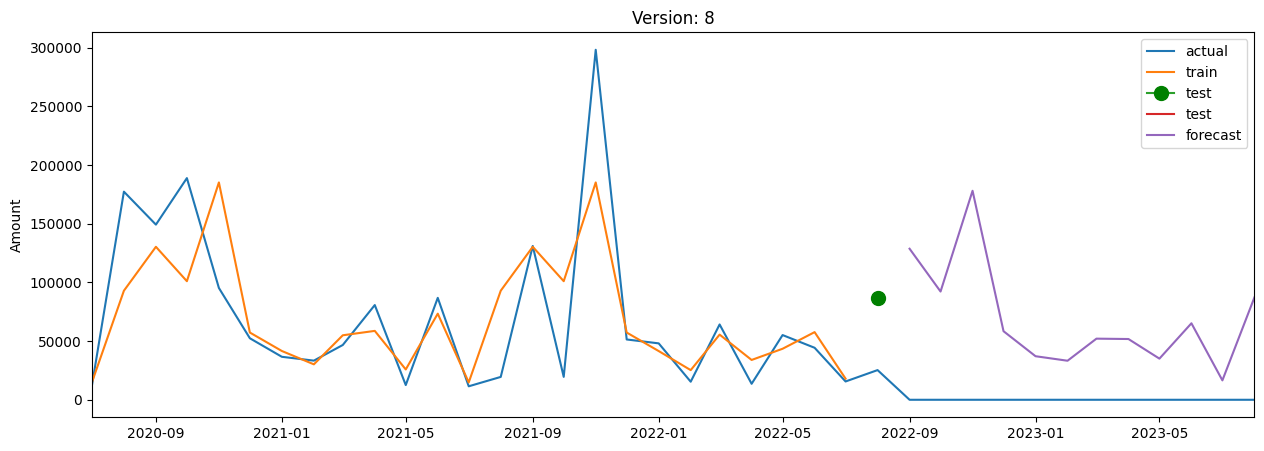

['2020-07-01T00:00:00.000000000' '2020-08-01T00:00:00.000000000'
 '2020-09-01T00:00:00.000000000' '2020-10-01T00:00:00.000000000'
 '2020-11-01T00:00:00.000000000' '2020-12-01T00:00:00.000000000'
 '2021-01-01T00:00:00.000000000' '2021-02-01T00:00:00.000000000'
 '2021-03-01T00:00:00.000000000' '2021-04-01T00:00:00.000000000'
 '2021-05-01T00:00:00.000000000' '2021-06-01T00:00:00.000000000'
 '2021-07-01T00:00:00.000000000' '2021-08-01T00:00:00.000000000'
 '2021-09-01T00:00:00.000000000' '2021-10-01T00:00:00.000000000'
 '2021-11-01T00:00:00.000000000' '2021-12-01T00:00:00.000000000'
 '2022-01-01T00:00:00.000000000' '2022-02-01T00:00:00.000000000'
 '2022-03-01T00:00:00.000000000' '2022-04-01T00:00:00.000000000'
 '2022-05-01T00:00:00.000000000' '2022-06-01T00:00:00.000000000']
['2022-07-01T00:00:00.000000000']
['2022-08-01T00:00:00.000000000' '2022-09-01T00:00:00.000000000'
 '2022-10-01T00:00:00.000000000' '2022-11-01T00:00:00.000000000'
 '2022-12-01T00:00:00.000000000' '2023-01-01T00:00:00.0

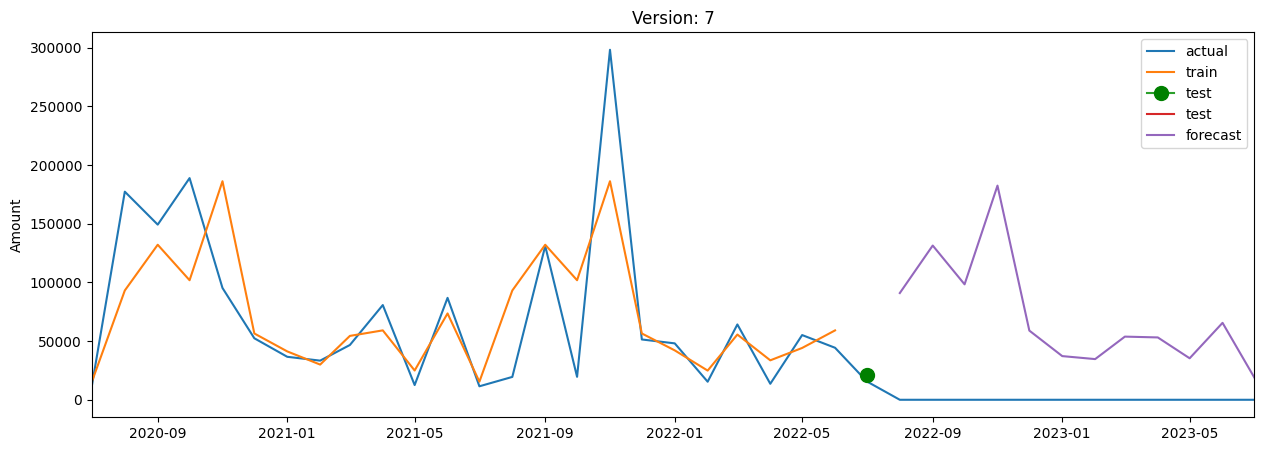

['2020-07-01T00:00:00.000000000' '2020-08-01T00:00:00.000000000'
 '2020-09-01T00:00:00.000000000' '2020-10-01T00:00:00.000000000'
 '2020-11-01T00:00:00.000000000' '2020-12-01T00:00:00.000000000'
 '2021-01-01T00:00:00.000000000' '2021-02-01T00:00:00.000000000'
 '2021-03-01T00:00:00.000000000' '2021-04-01T00:00:00.000000000'
 '2021-05-01T00:00:00.000000000' '2021-06-01T00:00:00.000000000'
 '2021-07-01T00:00:00.000000000' '2021-08-01T00:00:00.000000000'
 '2021-09-01T00:00:00.000000000' '2021-10-01T00:00:00.000000000'
 '2021-11-01T00:00:00.000000000' '2021-12-01T00:00:00.000000000'
 '2022-01-01T00:00:00.000000000' '2022-02-01T00:00:00.000000000'
 '2022-03-01T00:00:00.000000000' '2022-04-01T00:00:00.000000000'
 '2022-05-01T00:00:00.000000000']
['2022-06-01T00:00:00.000000000']
['2022-07-01T00:00:00.000000000' '2022-08-01T00:00:00.000000000'
 '2022-09-01T00:00:00.000000000' '2022-10-01T00:00:00.000000000'
 '2022-11-01T00:00:00.000000000' '2022-12-01T00:00:00.000000000'
 '2023-01-01T00:00:00.

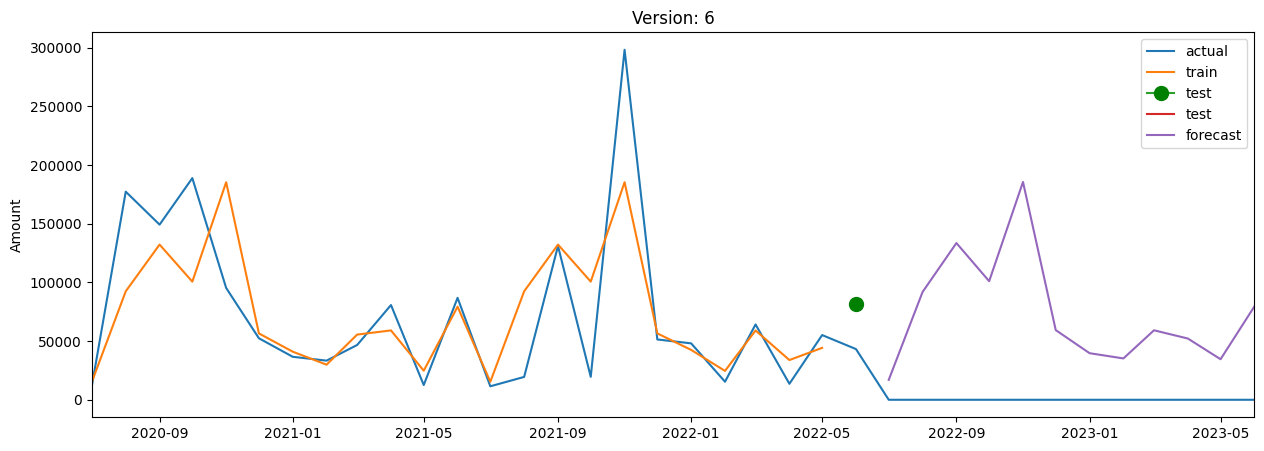

In [182]:
for i in range(len(versions)):
    a = predict_df.loc[predict_df.version == versions[i]]
    dates = all_dates[versions[i]]

    # monthly
    ts = a.set_index("ts").resample("MS").sum().reset_index()
    train = ts.loc[ts.ts < dates["test"][0]]
    test = ts.loc[(ts.ts < dates["forecast"][0]) & (ts.ts >= dates["test"][0])]
    predict = ts.loc[ts.ts >= dates["forecast"][0]]
    
    print(train.ts.unique())
    print(test.ts.unique())
    print(predict.ts.unique())
    
    _max = ts[["y", "yhat"]].max().max()

    plt.figure(figsize=(15,5))
    plt.plot(ts.ts, ts.y, label="actual")
    plt.plot(train.ts, train.yhat, label="train")

    if(test.shape[0] ==1):
        plt.plot(test.ts,  test.yhat, marker="o", markersize=10, markeredgecolor="green", markerfacecolor="green", label="test")
    else:
        plt.plot(test.ts, test.yhat, label="test")
    
    plt.plot(test.ts, test.yhat, label="test")
    plt.plot(predict.ts, predict.yhat, label="forecast")
    plt.xlim([ts.ts.min(), ts.ts.max()])
    plt.ylabel("Amount")
    plt.title("Version: {}".format(versions[i]))
    plt.legend()
    plt.show()

In [135]:
events = get_events()
events['festival'] = events['festival'].astype('int64')
events['promotion_specific_date'] = events['promotion_specific_date'].astype('int64')

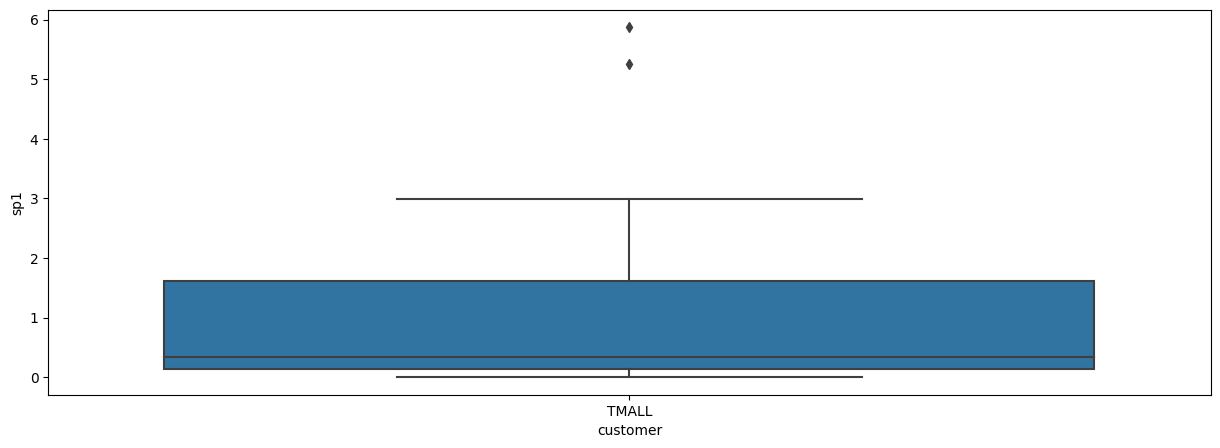

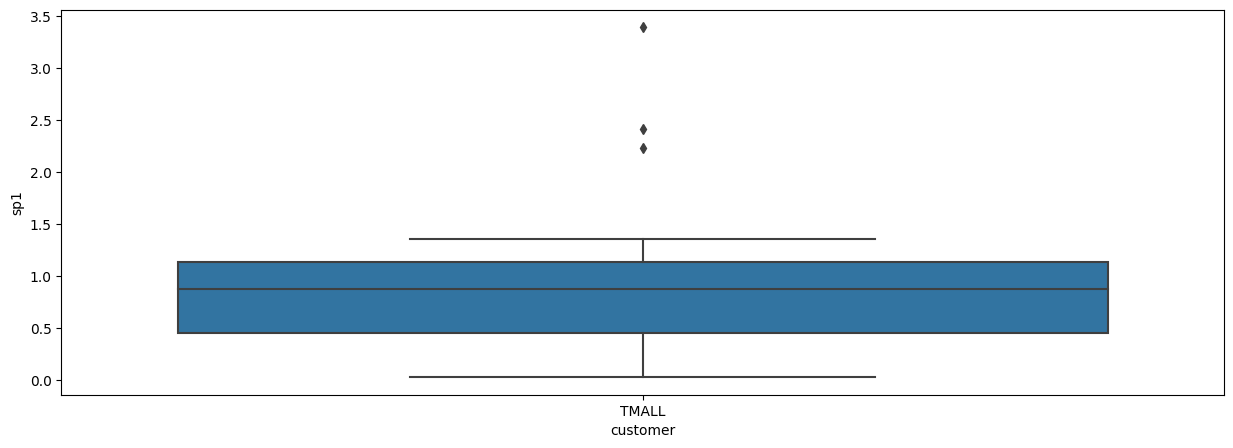

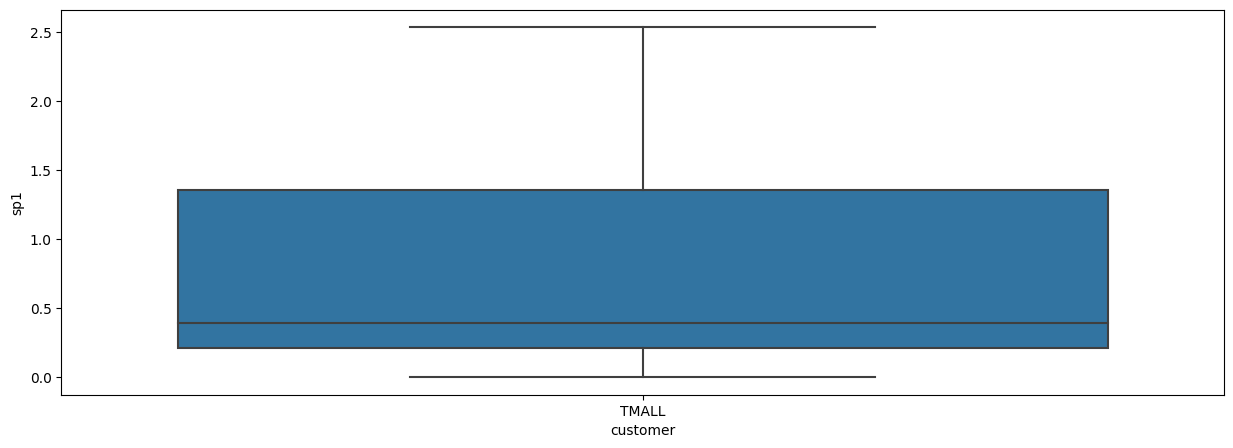

In [170]:
results = pd.DataFrame()
for i in range(len(versions)):
    for _id in predict_df.id.unique():
        ts = predict_df.loc[(predict_df["id"] == _id) & (predict_df["version"] == versions[i])  ].reset_index(drop=True)
        test = ts.loc[ ts.ts.isin( all_dates[versions[i]]["test"]) ].copy()
        
        metrics = calc_metrics(test.y, test.yhat)
        metrics.update({
            "id": _id,
            "version" : versions[i],
            "sku": ts["sku"][0],
            "customer": ts["customer"][0],
            "test_start": all_dates[versions[i]]["test"][0],
            "test_end": all_dates[versions[i]]["test"][-1],
            "total_actual": test.y.sum(),
            "total_forecast": test.yhat.sum(),
        })
        results = results.append(metrics, ignore_index=True, sort=False)

main_cols = ["id", "sku", "customer", "version", "test_start", "test_end", "total_actual", "total_forecast"]
results = results[main_cols + list(results.drop(columns=main_cols).columns)].copy()
results["sp1"] = results["total_actual"] / results["total_forecast"]
results["sp1"] = np.nan_to_num(results["sp1"], nan=1, posinf=0, neginf=0)
results["model"] = predict_df.model[0]

results.sort_values(by="id").reset_index(drop=True).set_index(["model", "id"])
results.groupby("customer").mean()
results.groupby("customer").median()

for i in range(len(versions)): 
    this_results = results[results['version'] == versions[i]]
    plt.figure(figsize=(15,5))
    #plt.ylim(0,15)
    sns.boxplot(data=this_results, y="sp1", x="customer")
    plt.show()

    

In [171]:
results

id           sku customer  version test_start   test_end  total_actual  total_forecast     rmse      mae     smape           mape     maape       sp1               model
0    0  815517026005    TMALL        8 2022-08-01 2022-08-01         108.0           858.0    750.0    750.0  1.552795   6.944444e+00  1.427779  0.125874  Model per customer
1    1  815517026012    TMALL        8 2022-08-01 2022-08-01           0.0          2217.0   2217.0   2217.0  2.000000  1.797693e+308  1.570796  0.000000  Model per customer
2    2  815517026029    TMALL        8 2022-08-01 2022-08-01         289.0           710.0    421.0    421.0  0.842843   1.456747e+00  0.969215  0.407042  Model per customer
3    3  815517026036    TMALL        8 2022-08-01 2022-08-01        2288.0         38751.0  36463.0  36463.0  1.776993   1.593663e+01  1.508130  0.059044  Model per customer
4    4  815517026043    TMALL        8 2022-08-01 2022-08-01         189.0          1020.0    831.0    831.0  1.374690   4.396825e+00  1.347164  0.185294  Model per customer
5    5  815517026050    TMALL        8 2022-08-01 2022-08-01          16.0            52.0     36.0     36.0  1.058824   2.250000e+00  1.152572  0.307692  Model per customer
6    6  815517026067    TMALL        8 2022-08-01 2022-08-01        1509.0         13954.0  12445.0  12445.0  1.609649   8.247184e+00  1.450132  0.108141  Model per customer
7    7  815517026081    TMALL        8 2022-08-01 2022-08-01        4013.0         23283.0  19270.0  19270.0  1.411928   4.801894e+00  1.365480  0.172358  Model per customer
8    8  815517026265    TMALL        8 2022-08-01 2022-08-01        1217.0          3207.0   1990.0   1990.0  0.899638   1.635168e+00  1.021922  0.379482  Model per customer
9    9  815517026272    TMALL        8 2022-08-01 2022-08-01        3112.0          6745.0   3633.0   3633.0  0.737141   1.167416e+00  0.862487  0.461379  Model per customer
10  10  815517026999    TMALL        8 2022-08-01 2022-08-01        6125.0          1043.0   5082.0   5082.0  1.417969   8.297143e-01  0.692599  5.872483  Model per customer
11  11  815517027163    TMALL        8 2022-08-01 2022-08-01        2161.0           411.0   1750.0   1750.0  1.360809   8.098103e-01  0.680694  5.257908  Model per customer
12  12  815517027170    TMALL        8 2022-08-01 2022-08-01         839.0           430.0    409.0    409.0  0.644602   4.874851e-01  0.453586  1.951163  Model per customer
13  13  815517027606    TMALL        8 2022-08-01 2022-08-01          44.0           307.0    263.0    263.0  1.498575   5.977273e+00  1.405031  0.143322  Model per customer
14  14  815517027613    TMALL        8 2022-08-01 2022-08-01        1157.0           416.0    741.0    741.0  0.942149   6.404494e-01  0.569632  2.781250  Model per customer
15  32  815517025992    TMALL        8 2022-08-01 2022-08-01         205.0           345.0    140.0    140.0  0.509091   6.829268e-01  0.599175  0.594203  Model per customer
16  33  815517027491    TMALL        8 2022-08-01 2022-08-01          11.0            75.0     64.0     64.0  1.488372   5.818182e+00  1.400584  0.146667  Model per customer
17  50  815517028122    TMALL        8 2022-08-01 2022-08-01        2006.0           672.0   1334.0   1334.0  0.996266   6.650050e-01  0.586851  2.985119  Model per customer
18   0  815517026005    TMALL        7 2022-07-01 2022-07-01         175.0           252.0     77.0     77.0  0.360656   4.400000e-01  0.414507  0.694444  Model per customer
19   1  815517026012    TMALL        7 2022-07-01 2022-07-01          13.0           433.0    420.0    420.0  1.883408   3.230769e+01  1.539854  0.030023  Model per customer
20   2  815517026029    TMALL        7 2022-07-01 2022-07-01         175.0           391.0    216.0    216.0  0.763251   1.234286e+00  0.889876  0.447570  Model per customer
21   3  815517026036    TMALL        7 2022-07-01 2022-07-01        1284.0          2974.0   1690.0   1690.0  0.793800   1.316199e+00  0.921076  0.431742  Model per customer
22

In [ ]:
_id=9
i=0
ts = predict_df.loc[(predict_df["id"] == _id) & (predict_df["version"] == versions[i])  ].reset_index(drop=True)

test = ts.loc[ ts.ts.isin( all_dates[versions[i]]["test"]) ].copy()

metrics = calc_metrics(test.y, test.yhat)
metrics.update({
    "id": _id,
    "version" : versions[i],
    "sku": ts["sku"][0],
    "customer": ts["customer"][0],
    "test_start": all_dates[versions[i]]["test"][0],
    "test_end": all_dates[versions[i]]["test"][-1],
    "total_actual": test.y.sum(),
    "total_forecast": test.yhat.sum(),
})

In [ ]:
test

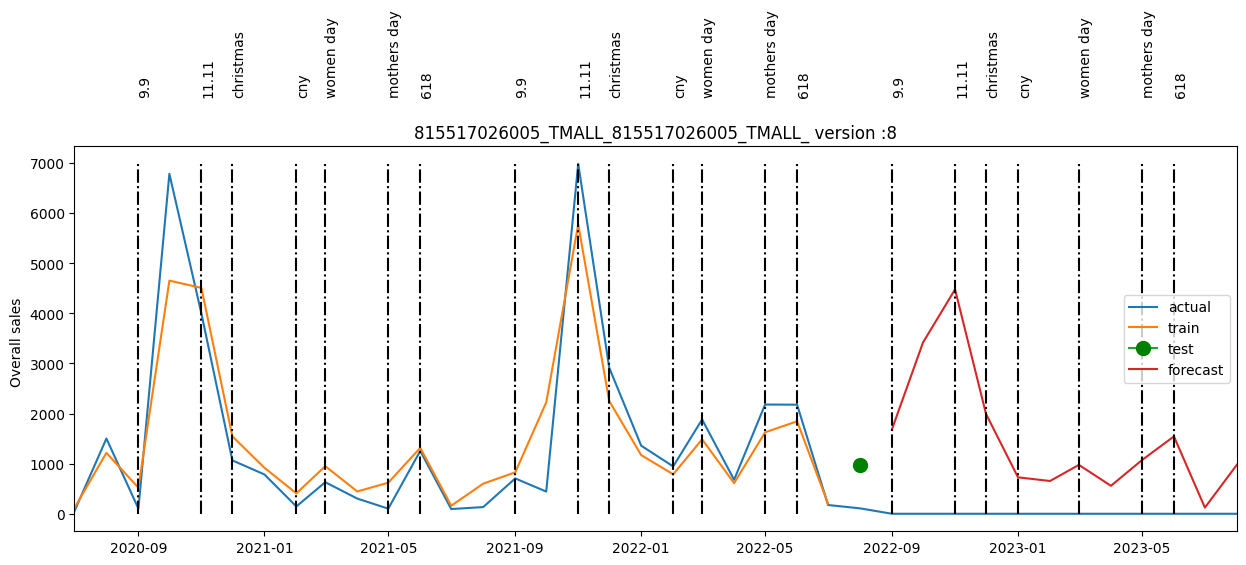

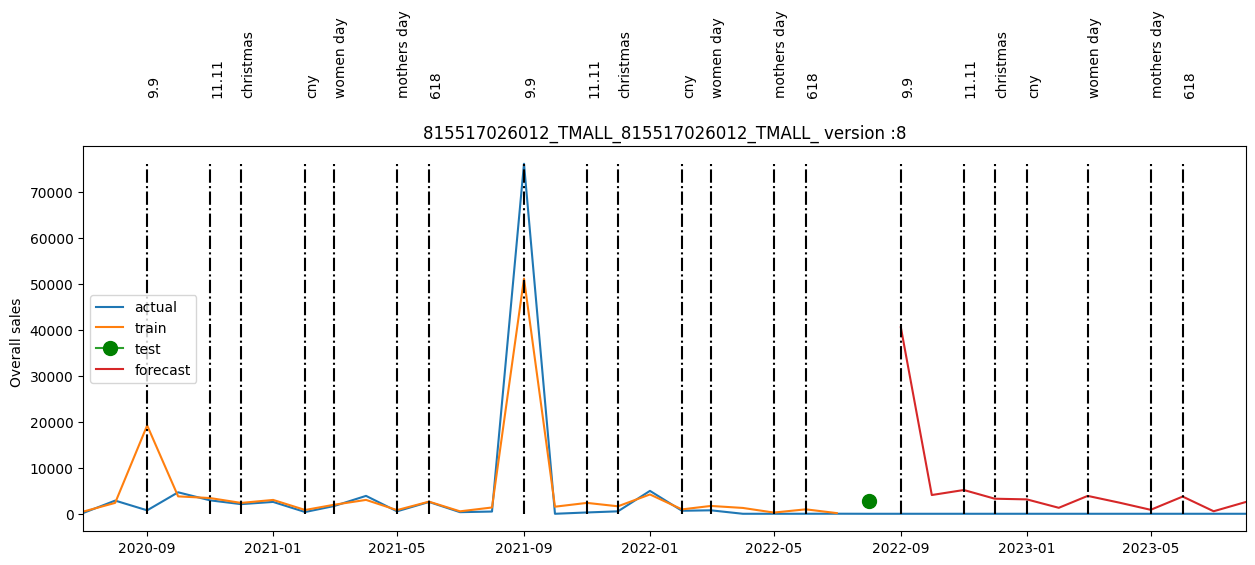

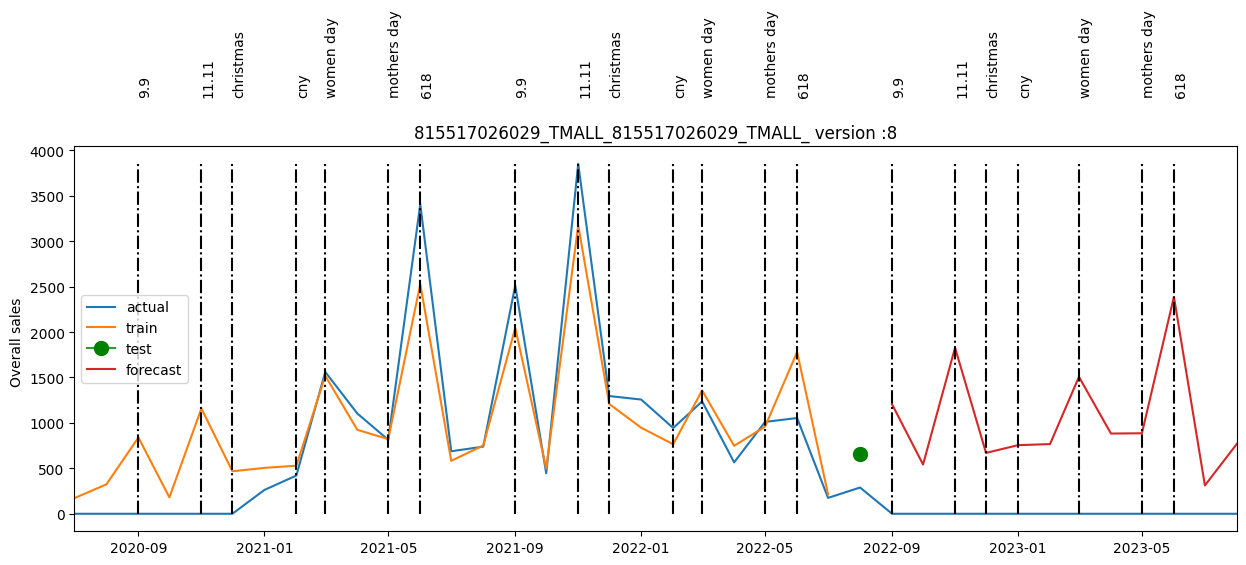

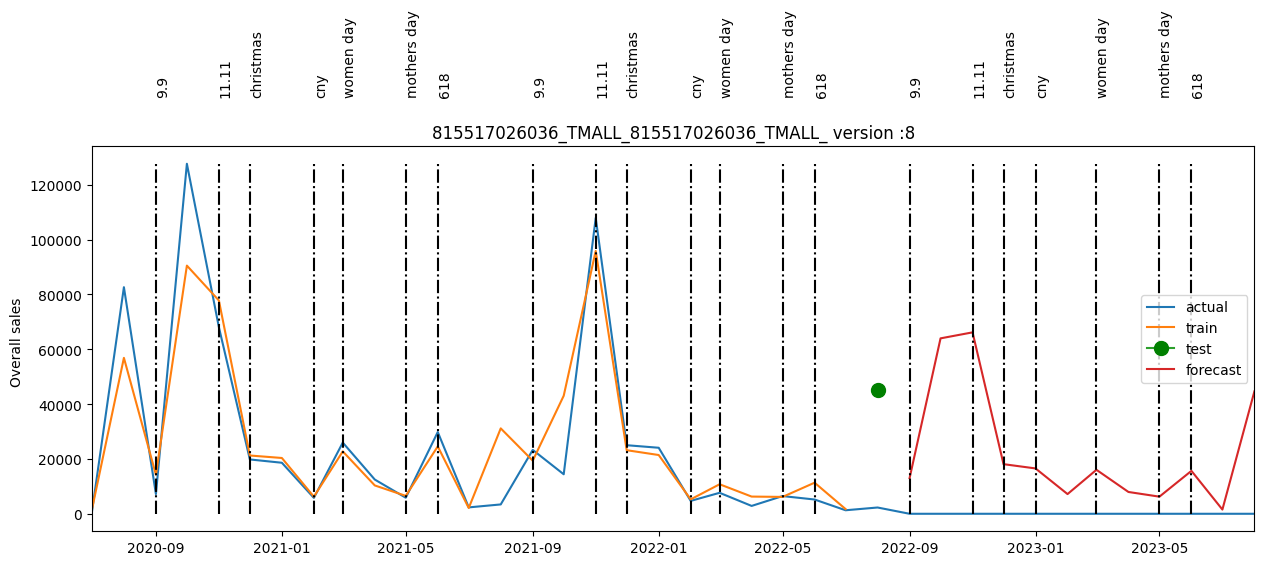

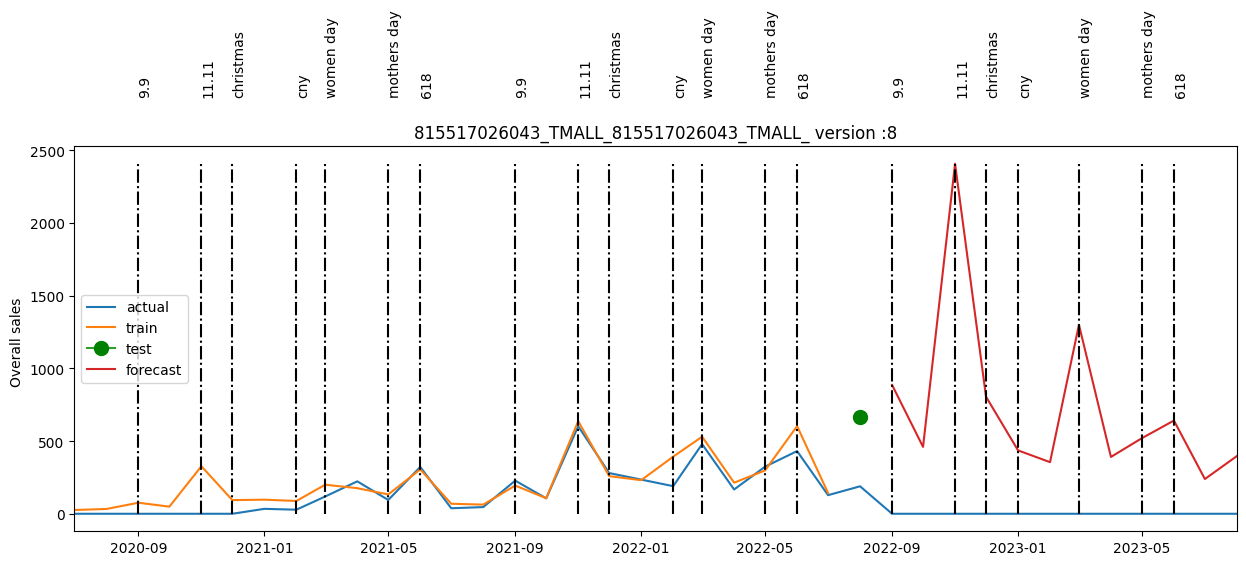

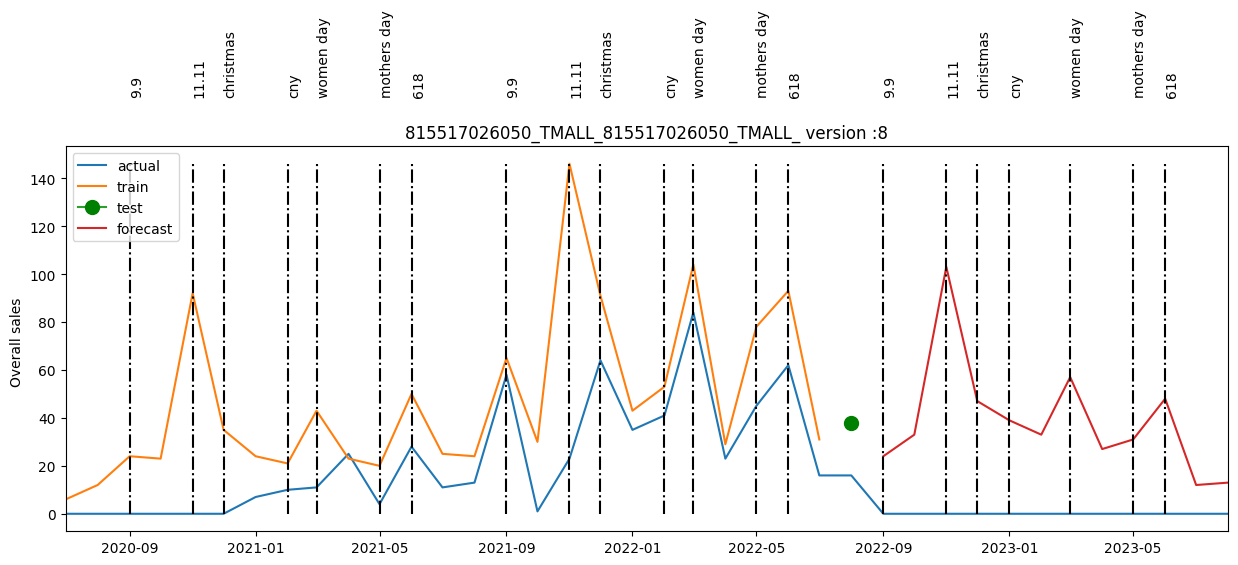

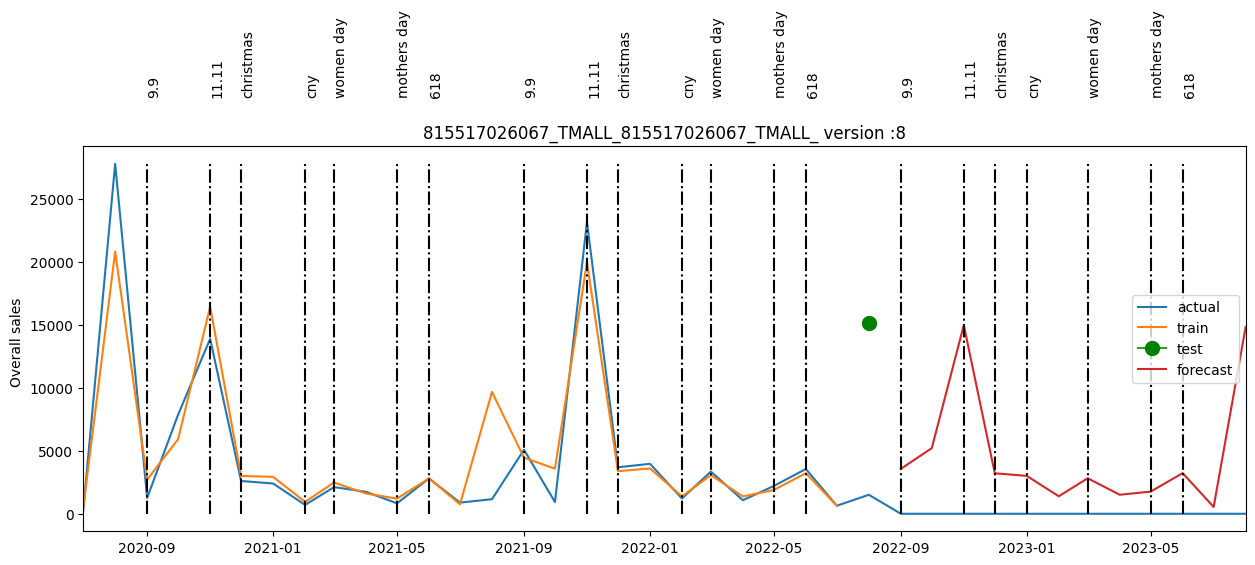

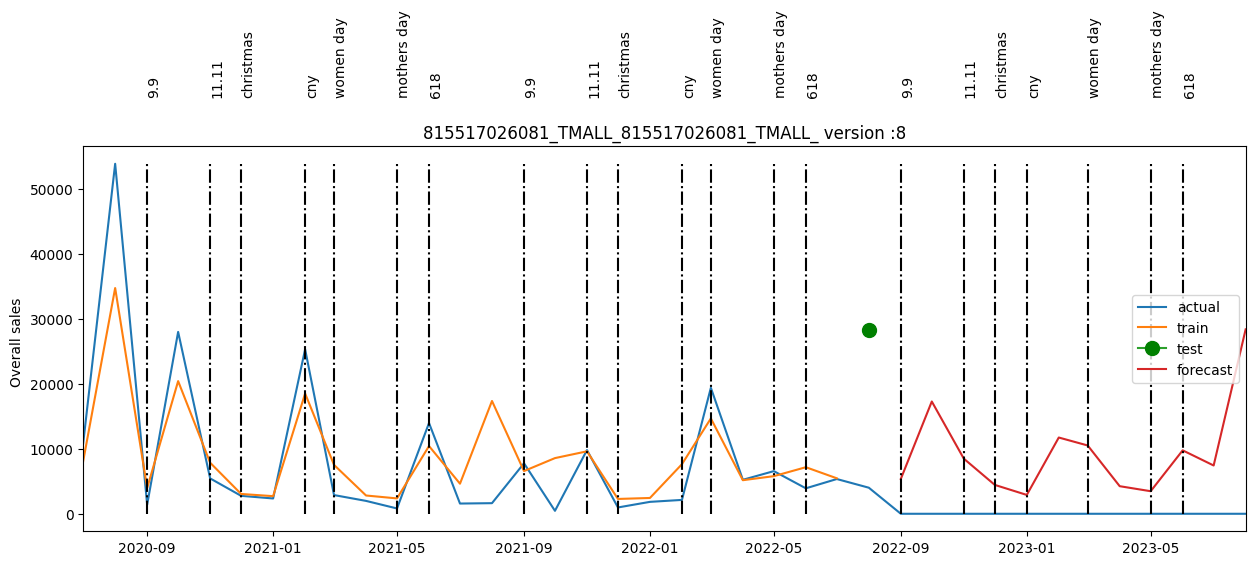

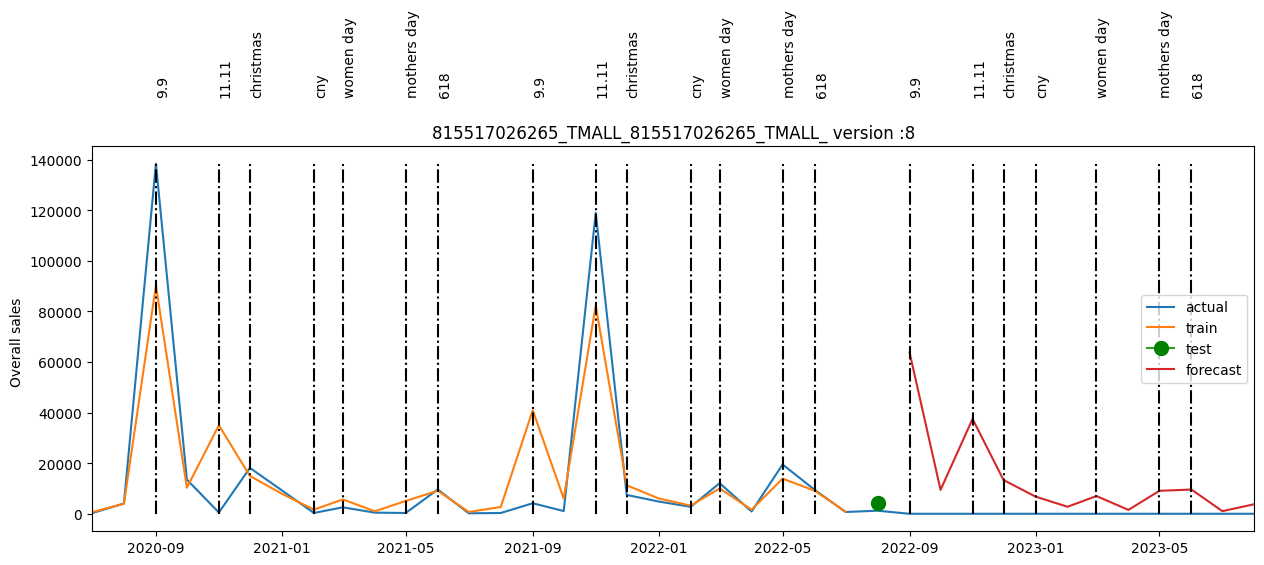

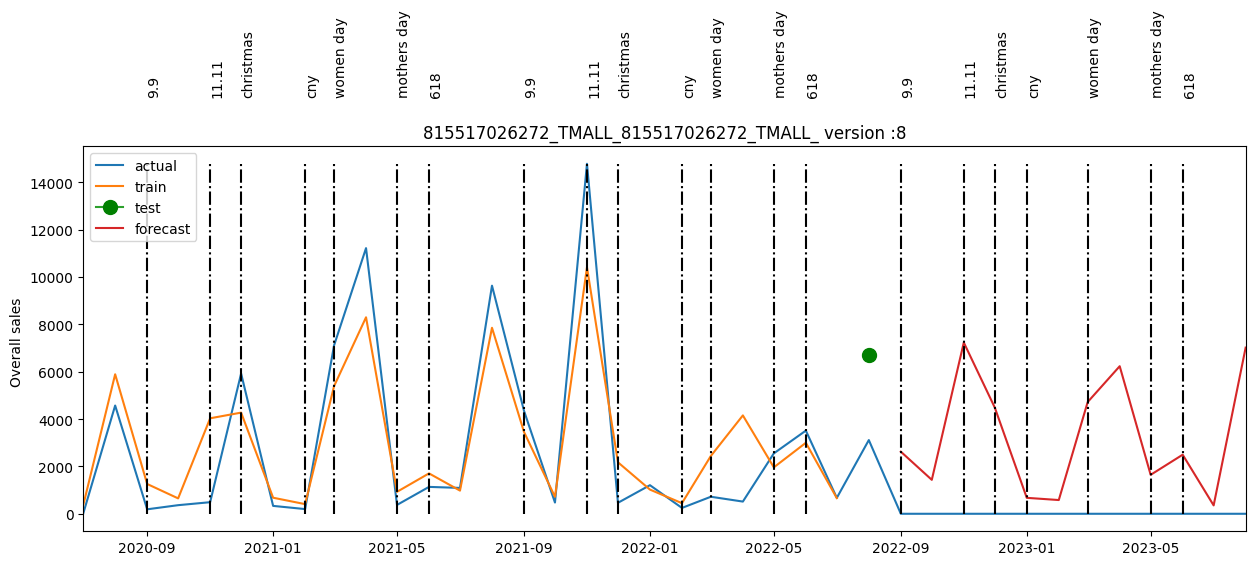

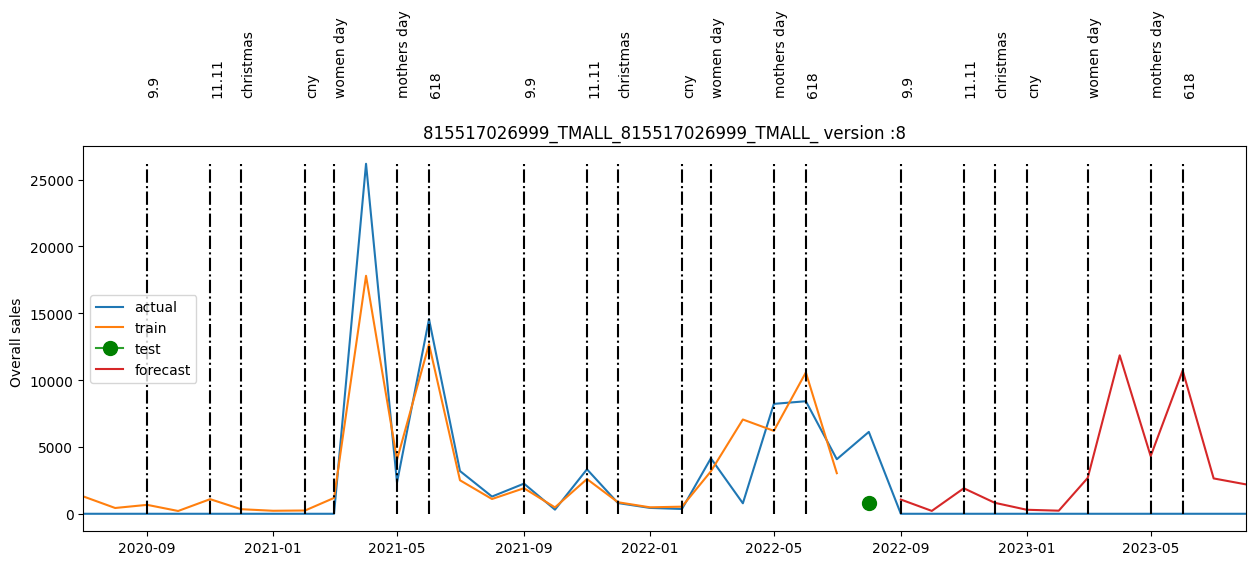

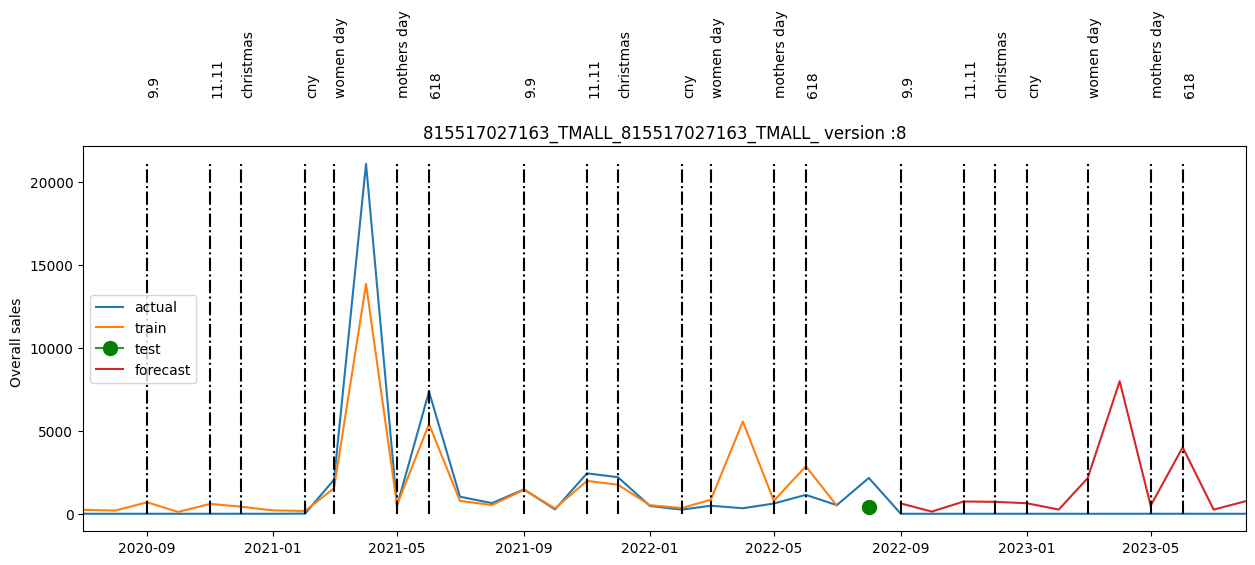

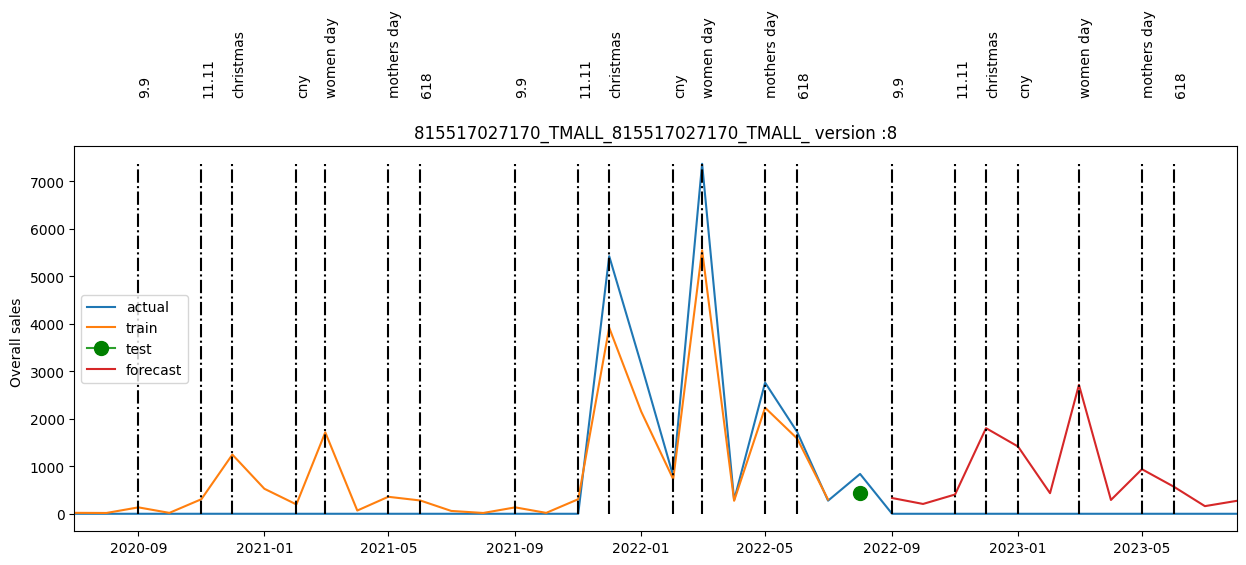

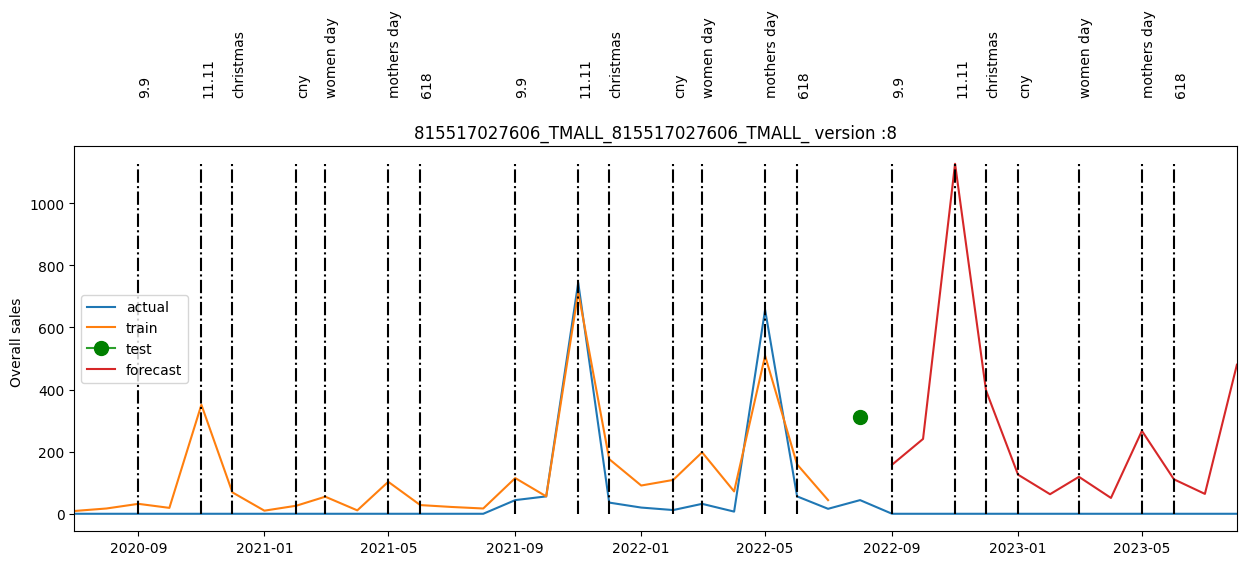

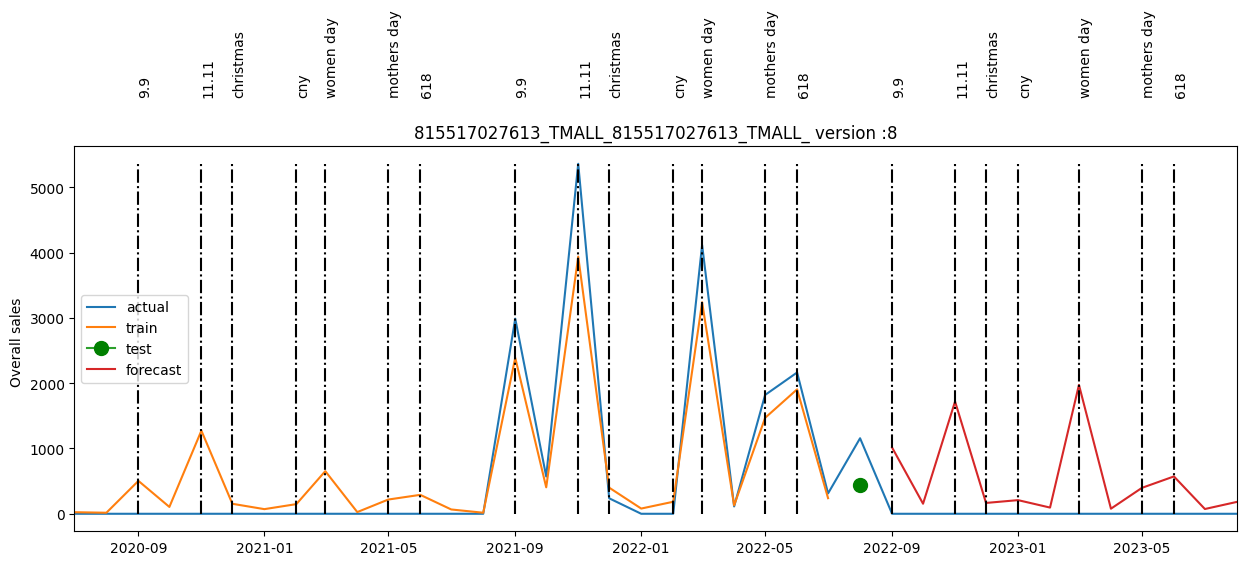

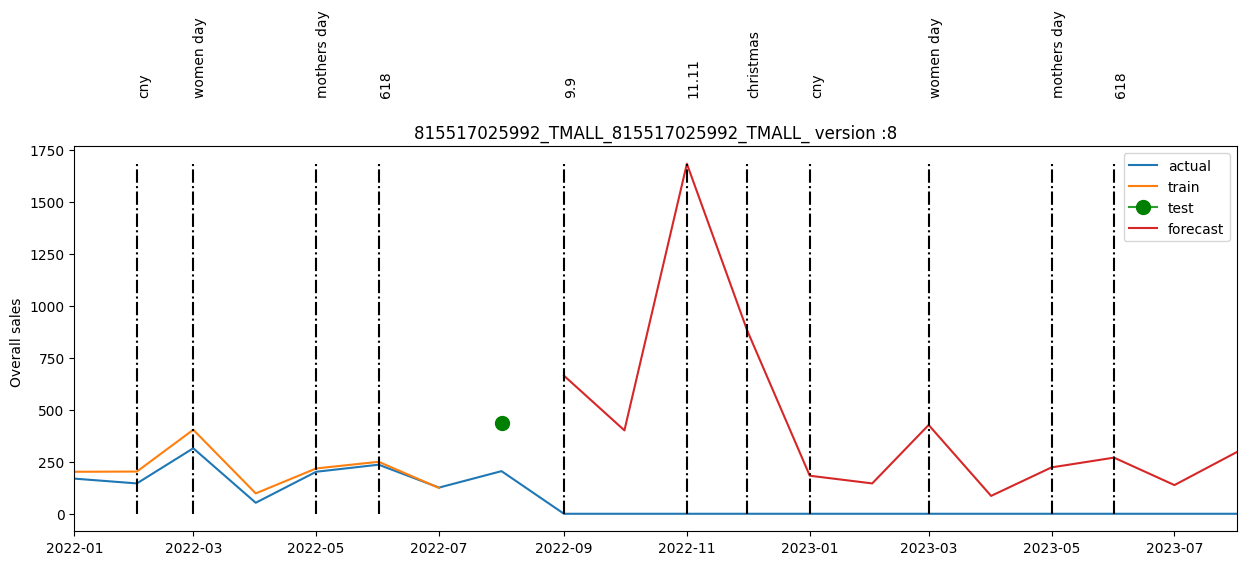

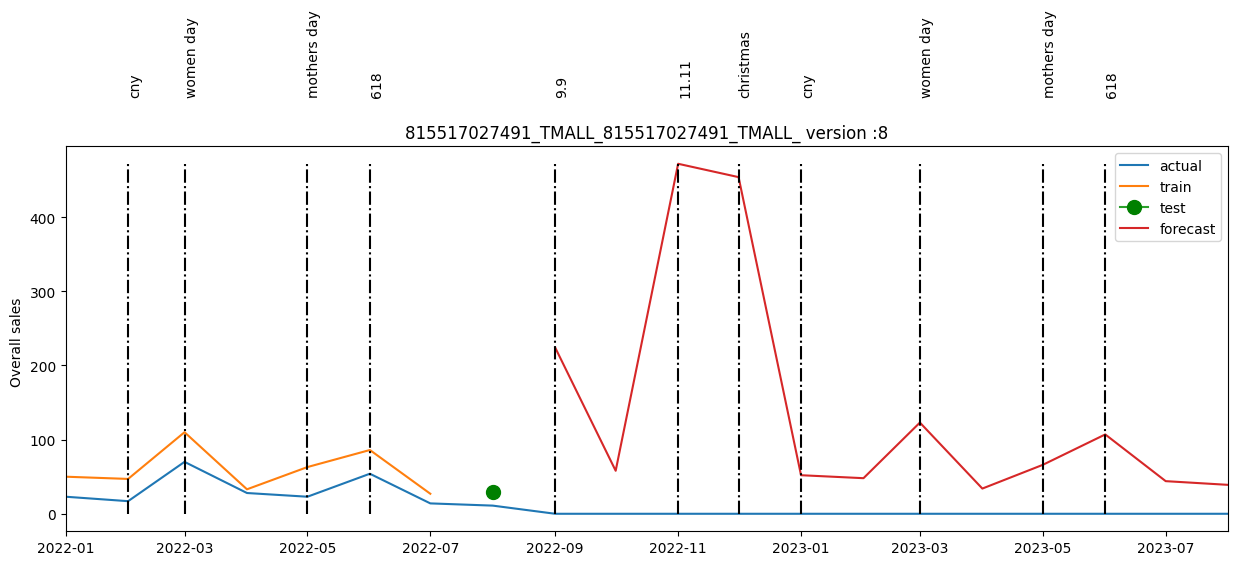

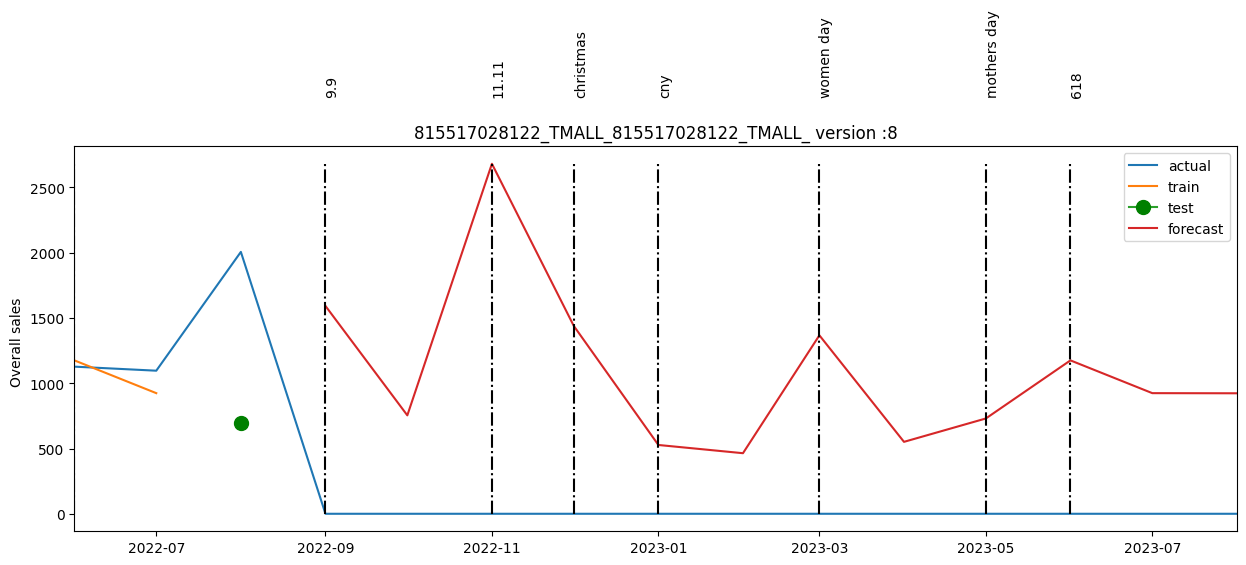

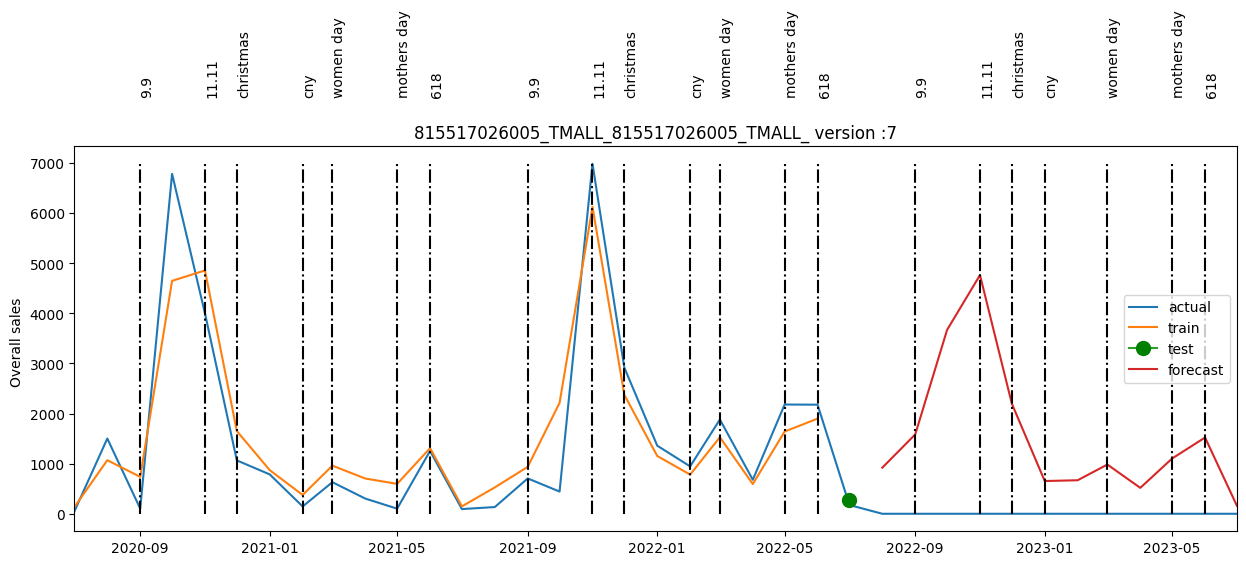

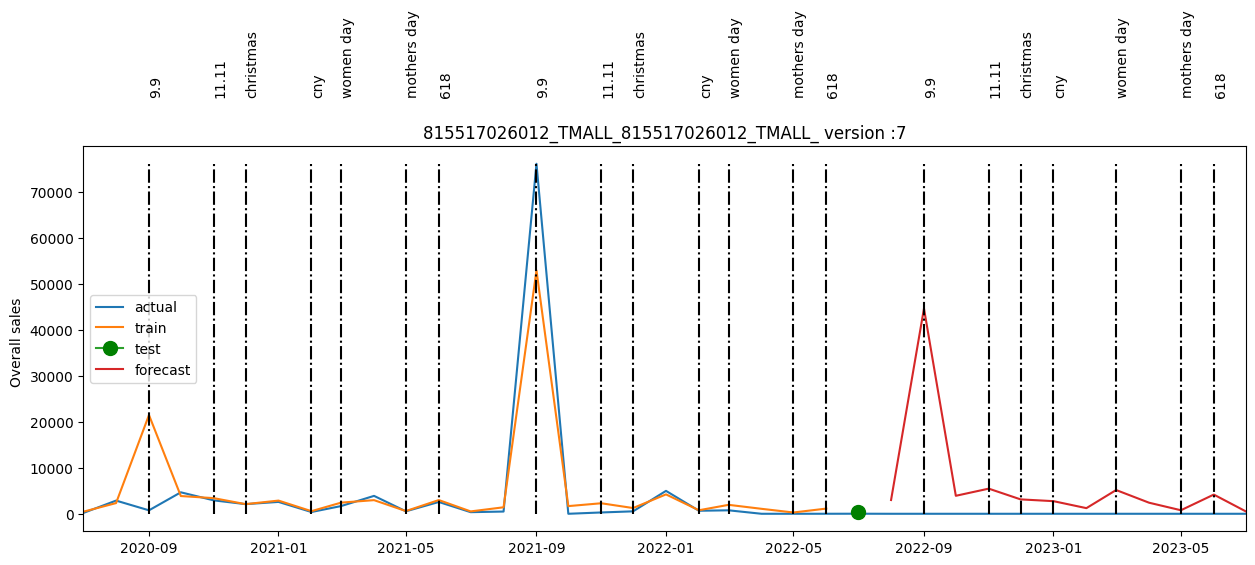

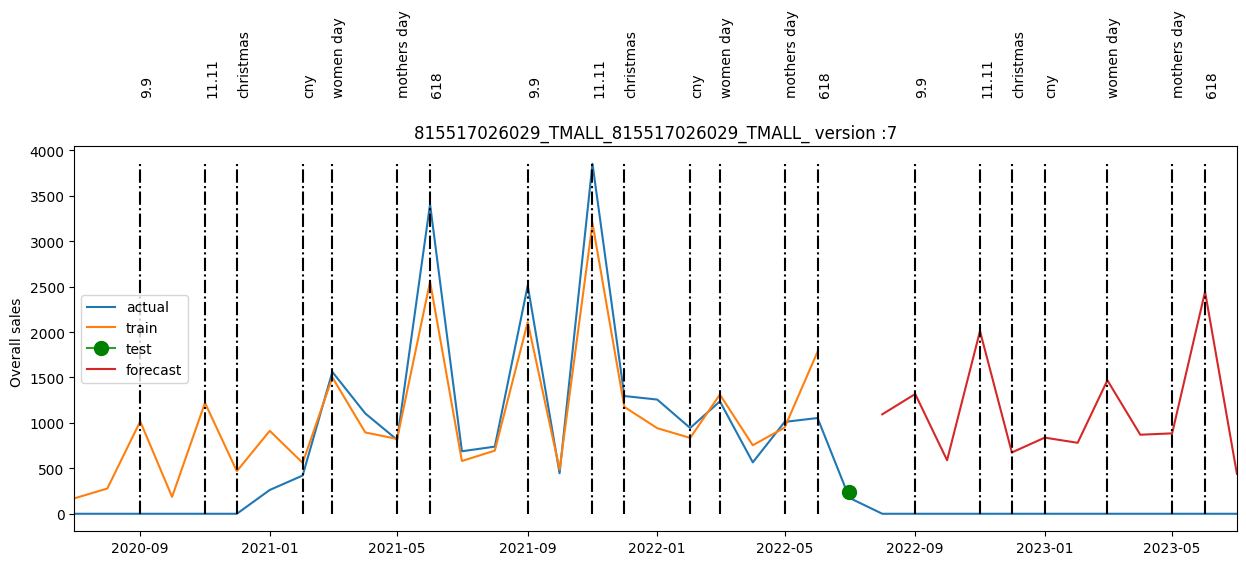

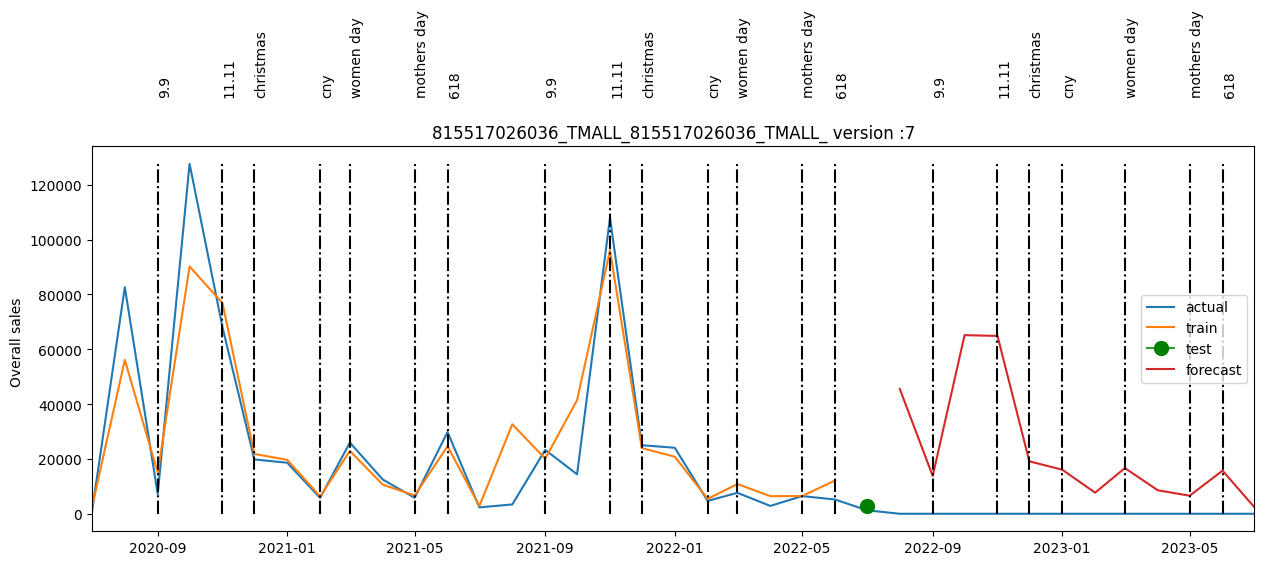

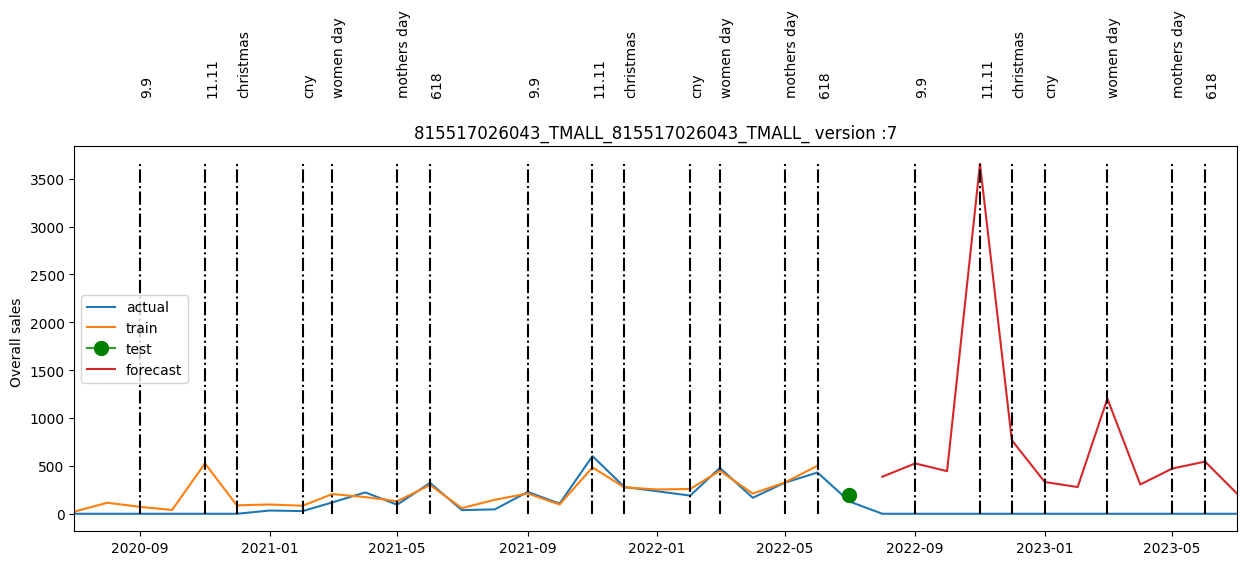

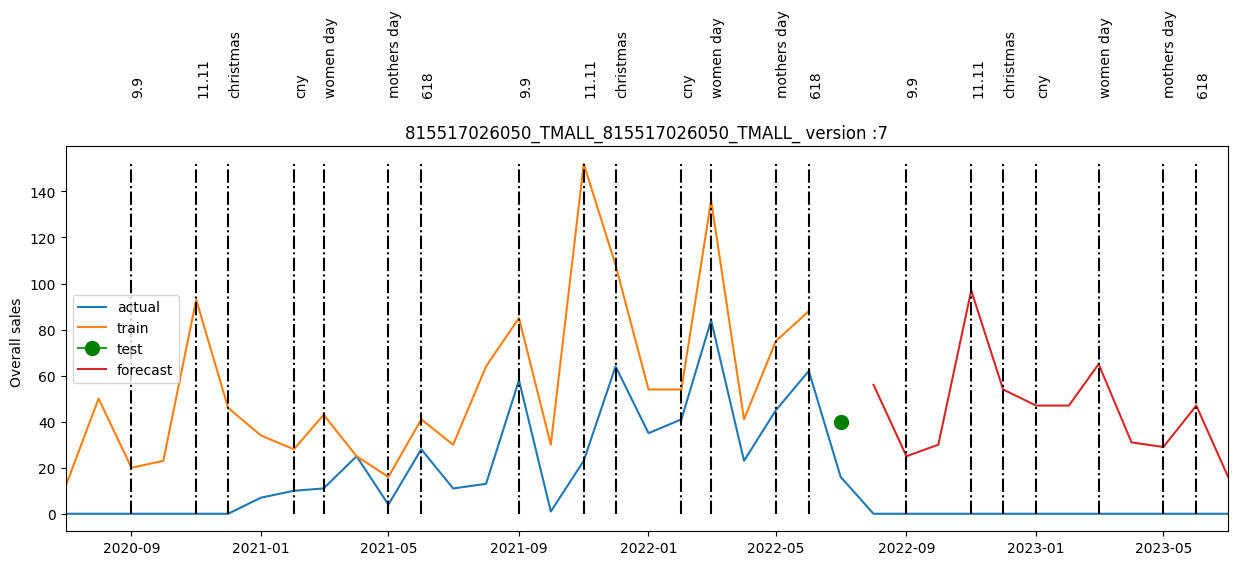

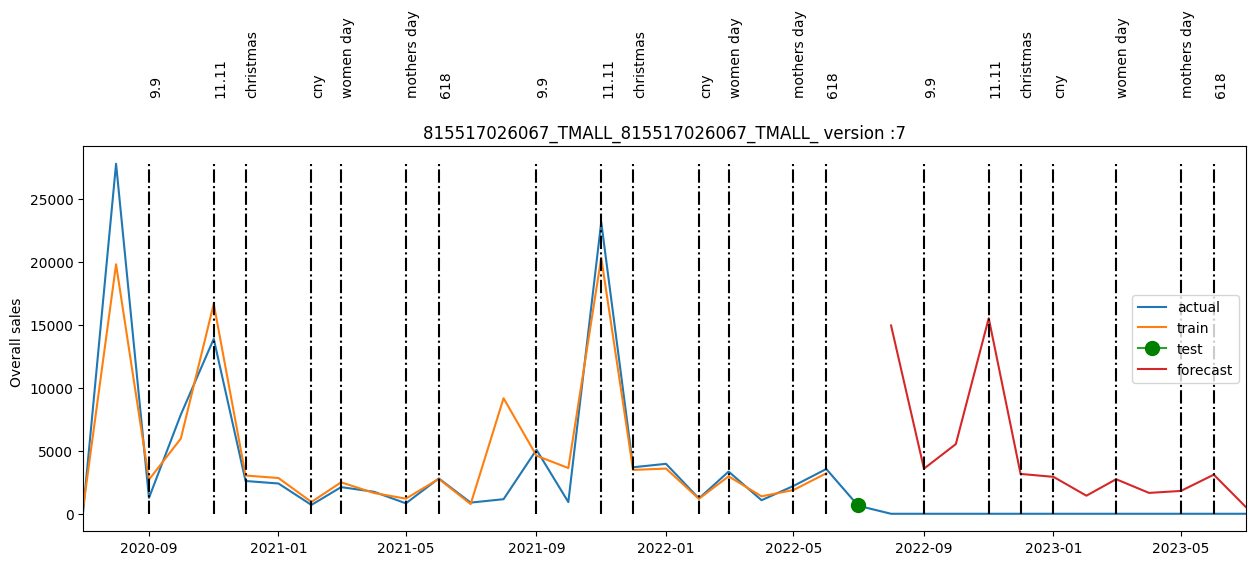

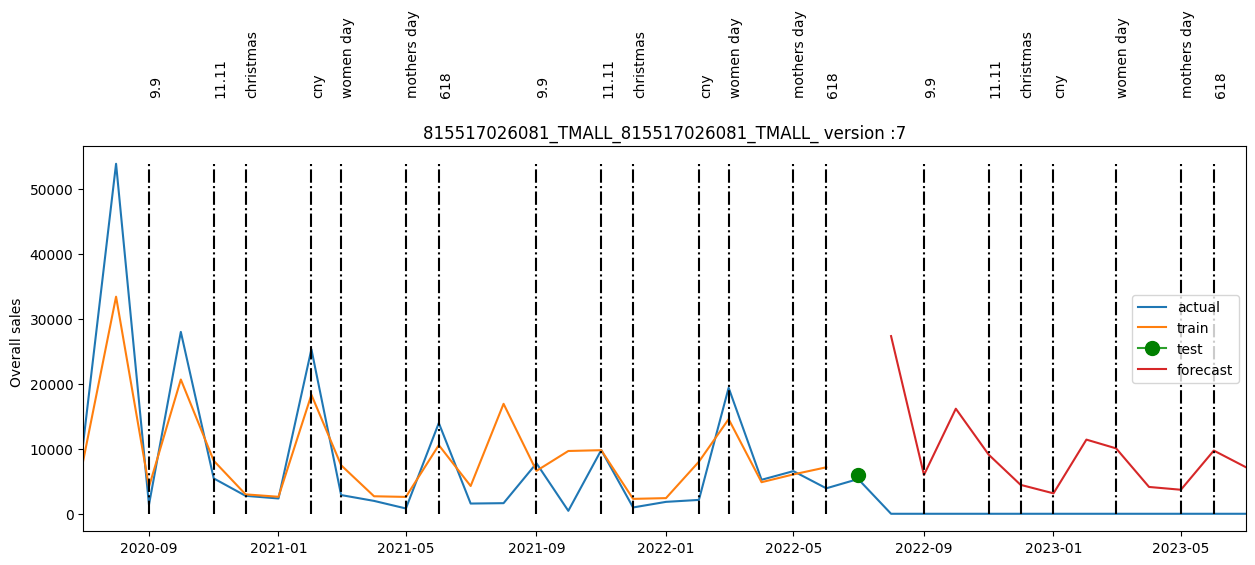

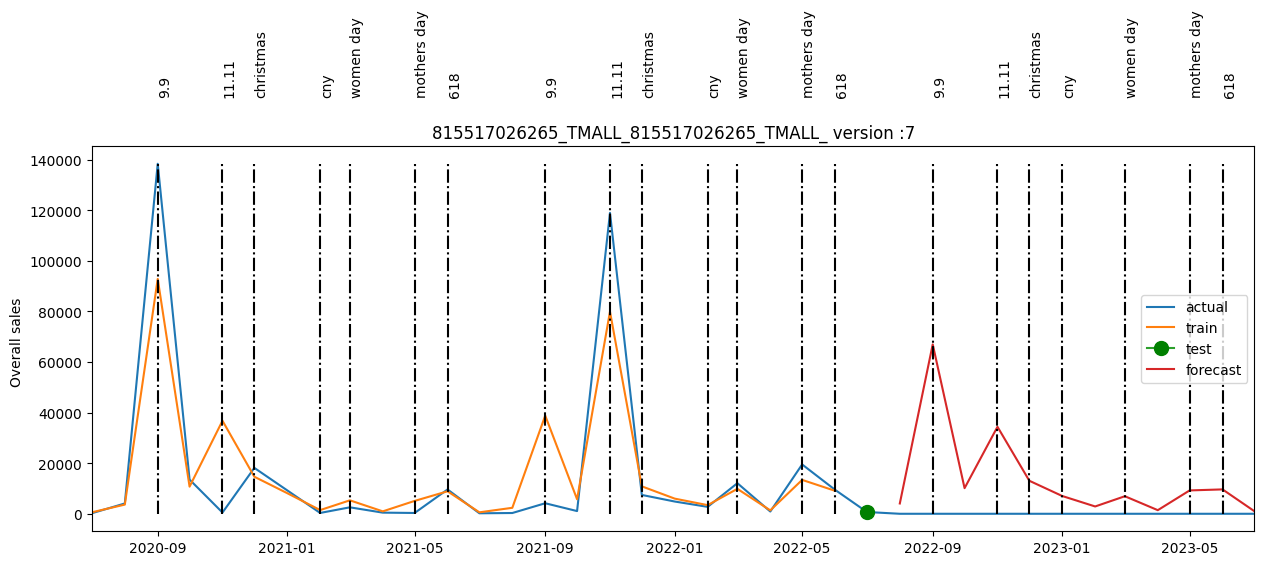

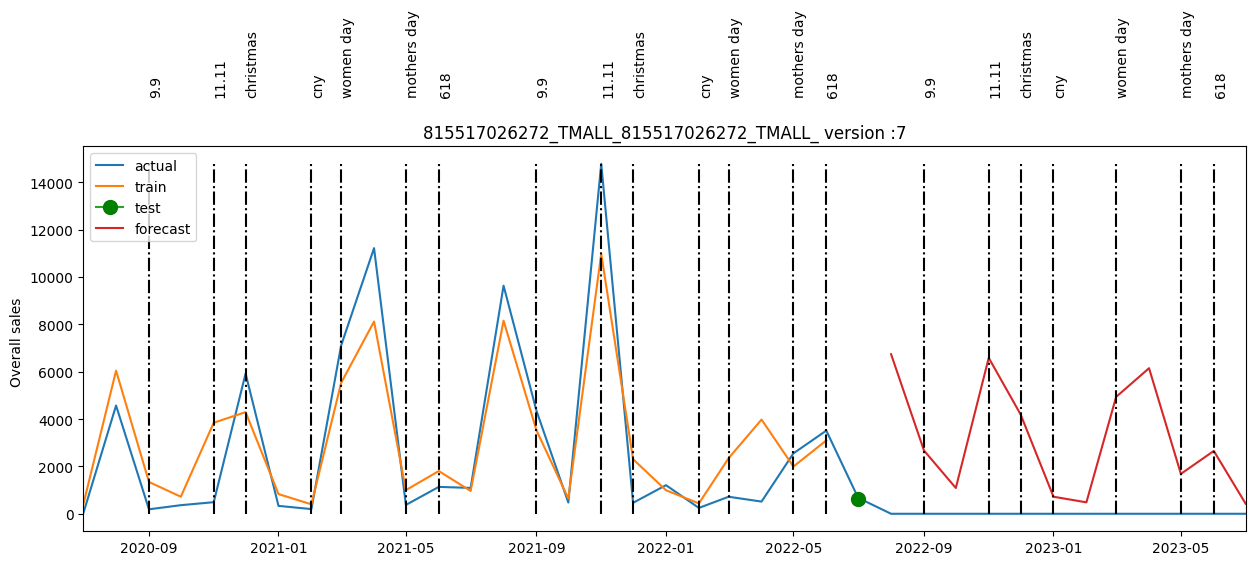

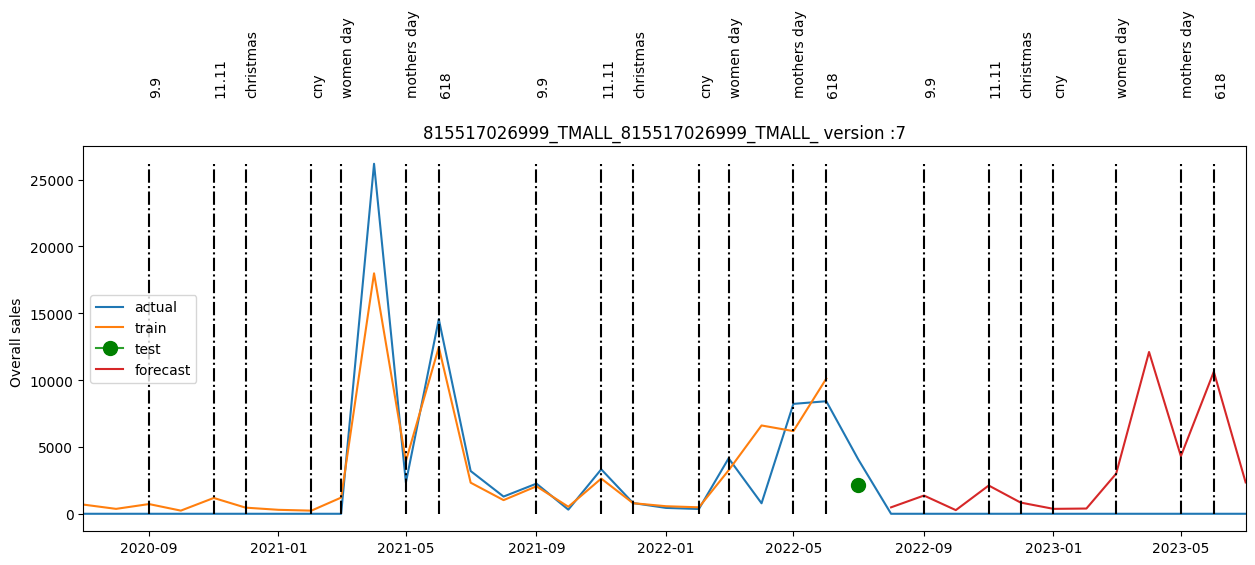

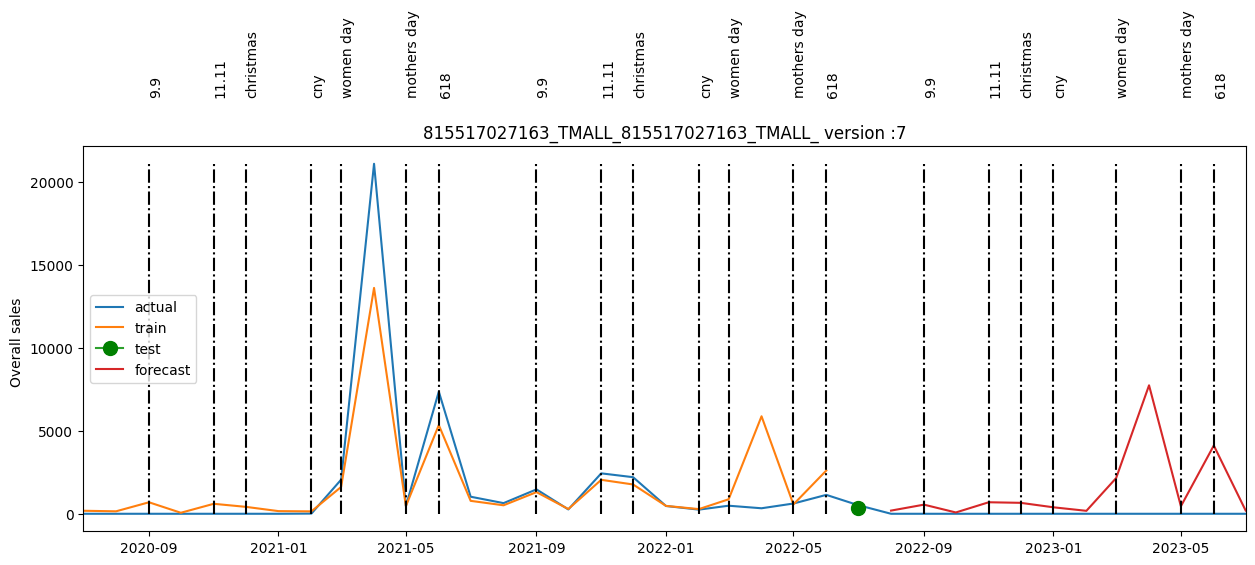

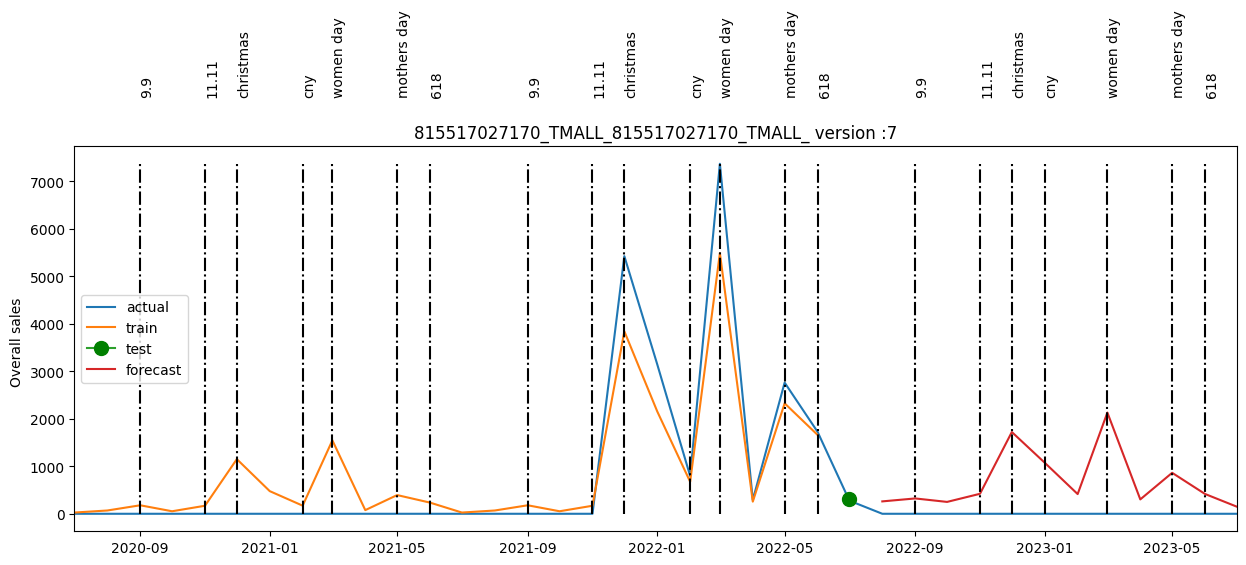

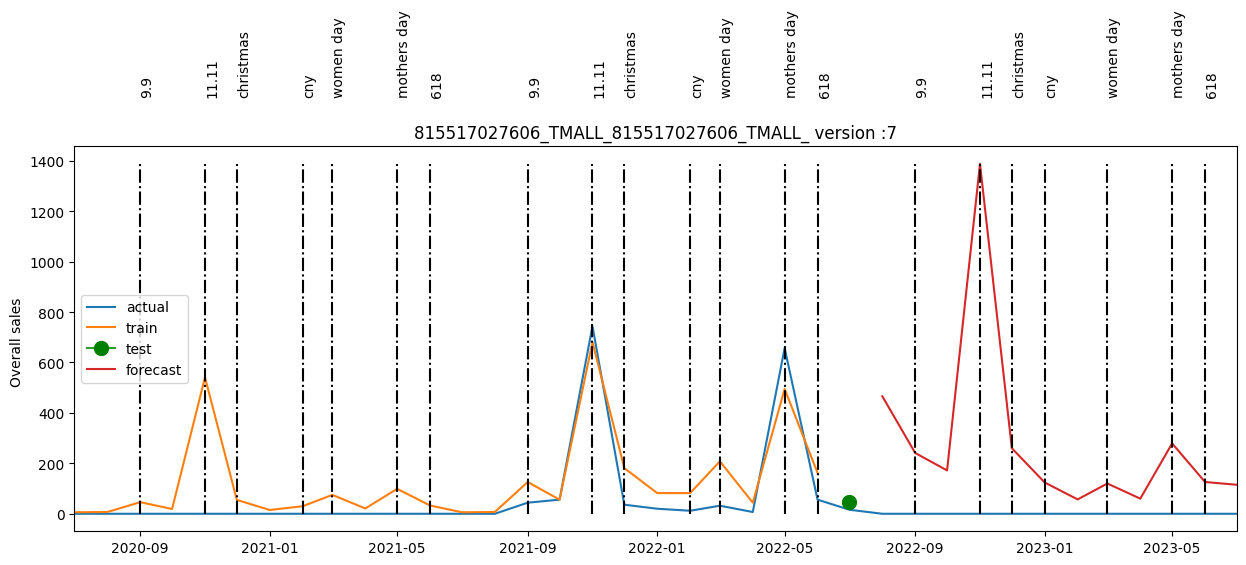

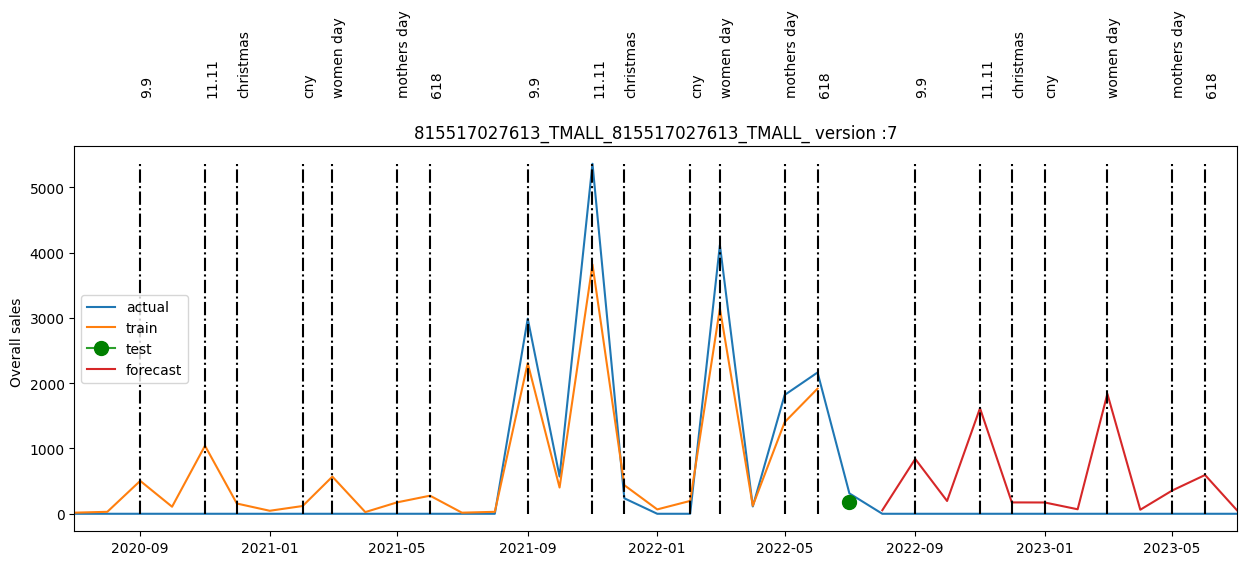

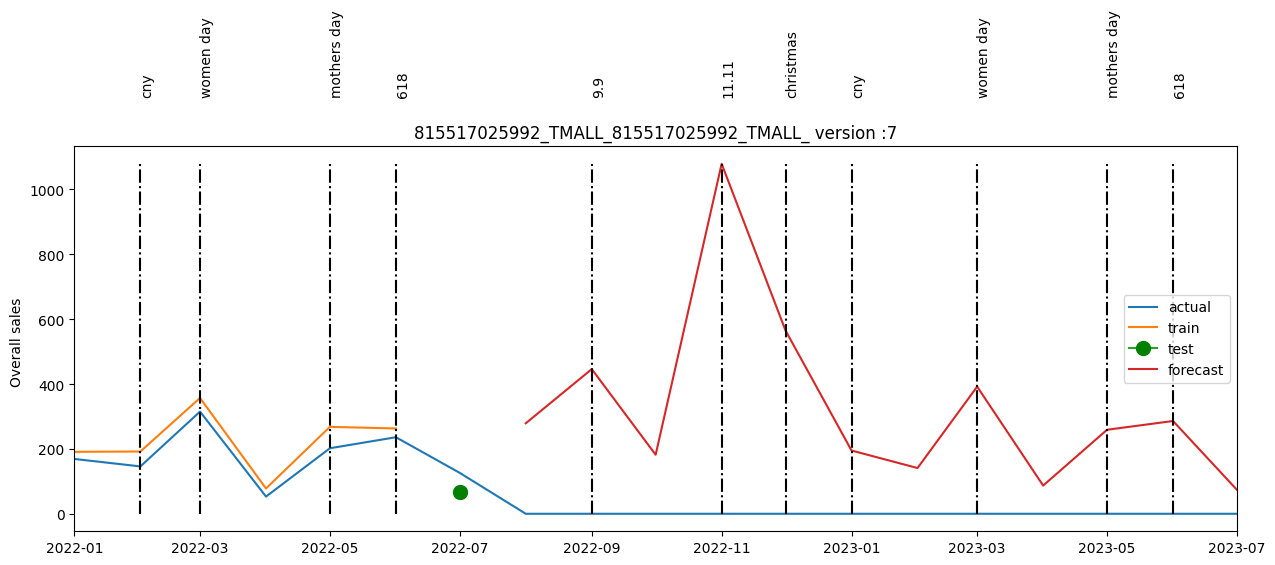

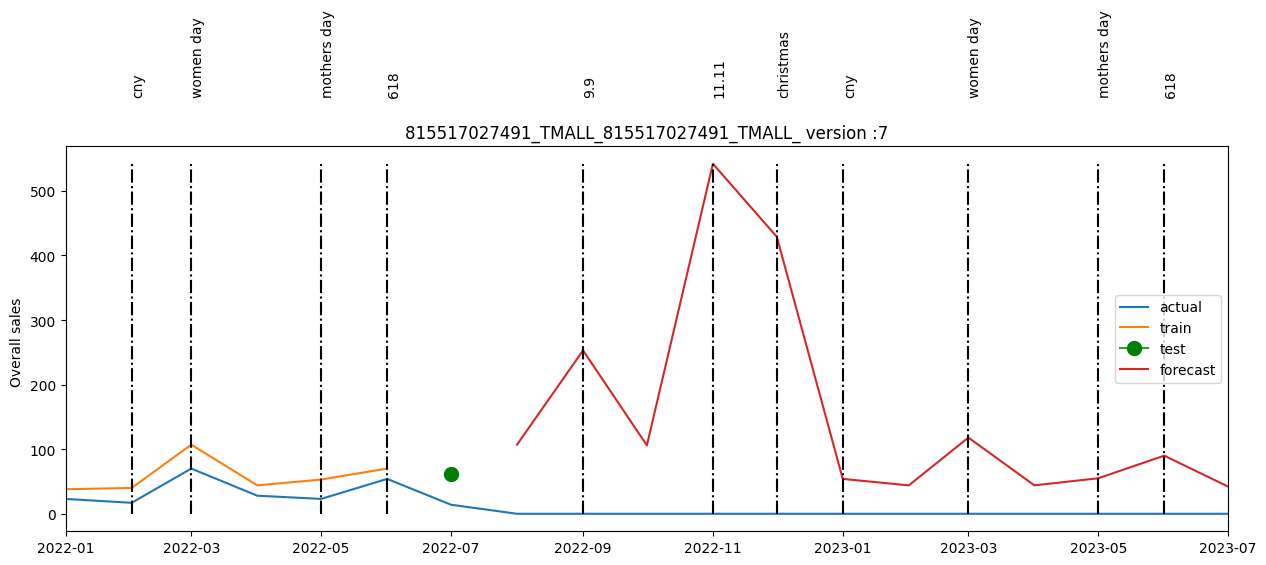

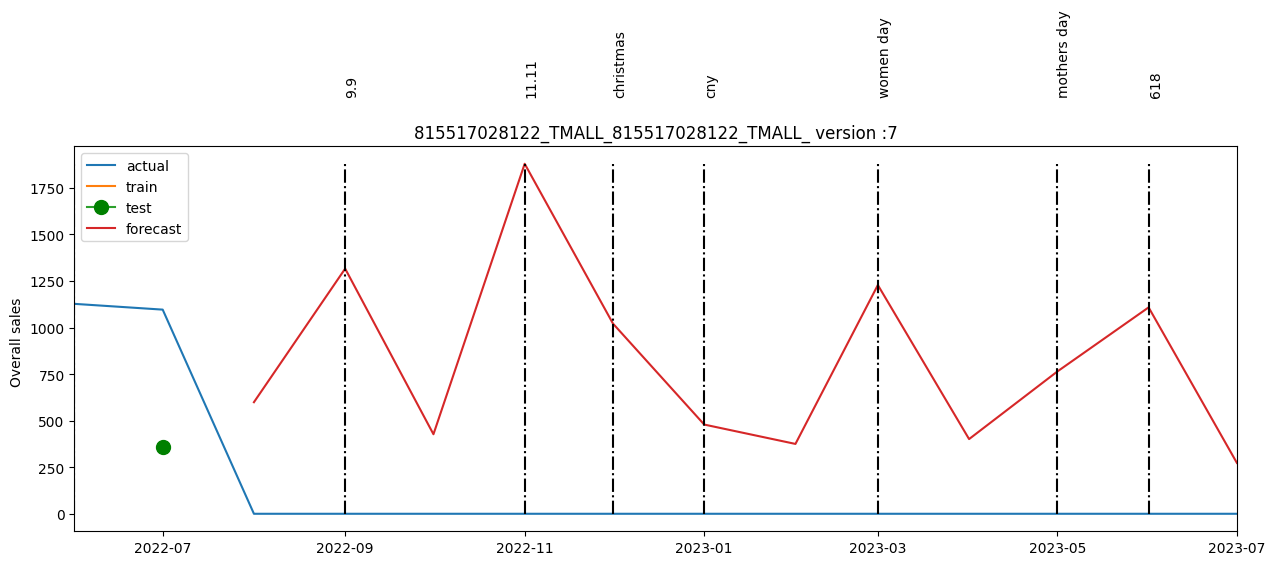

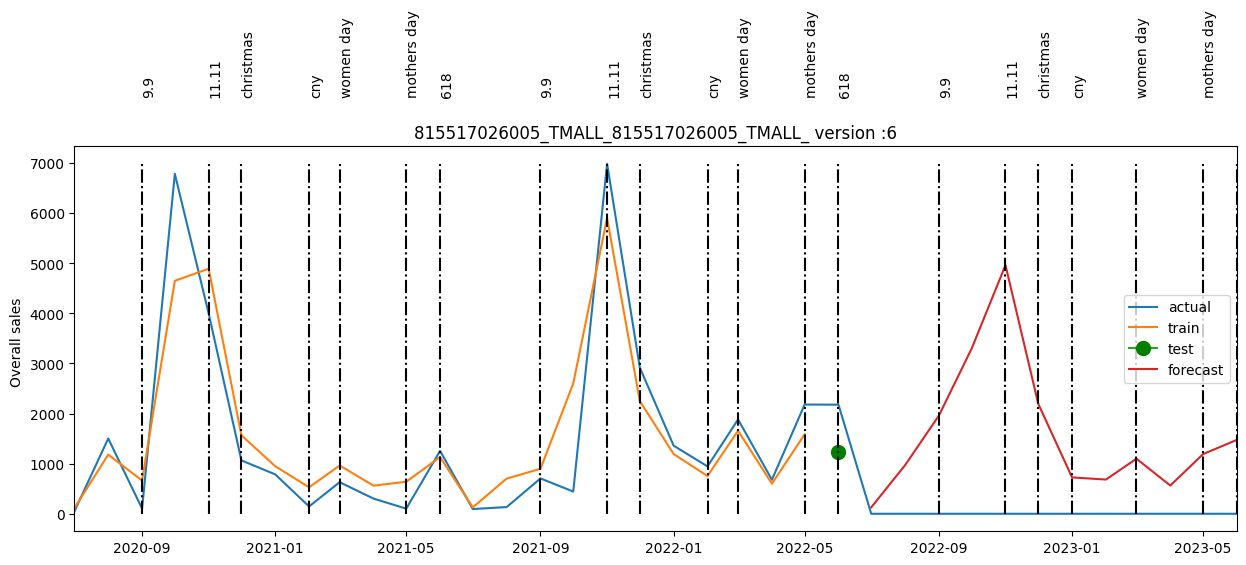

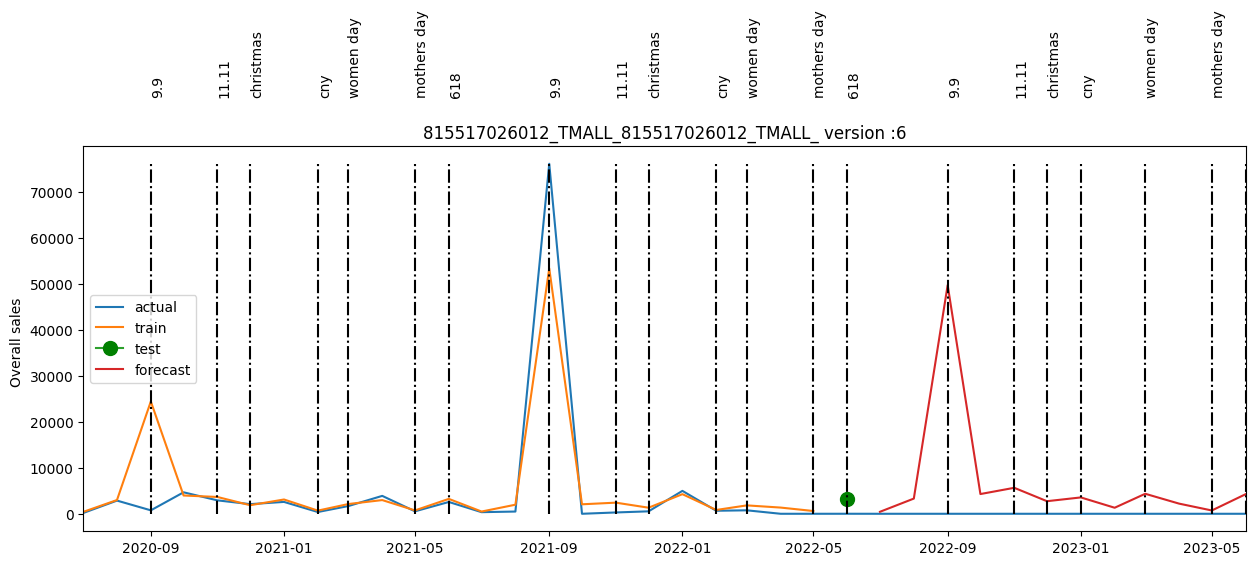

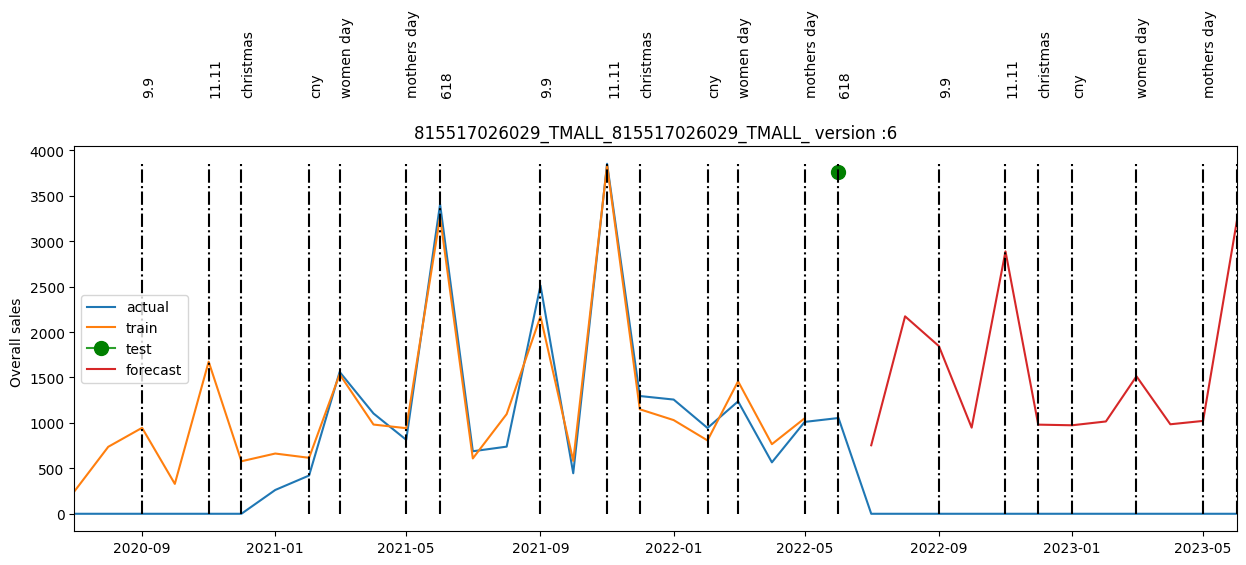

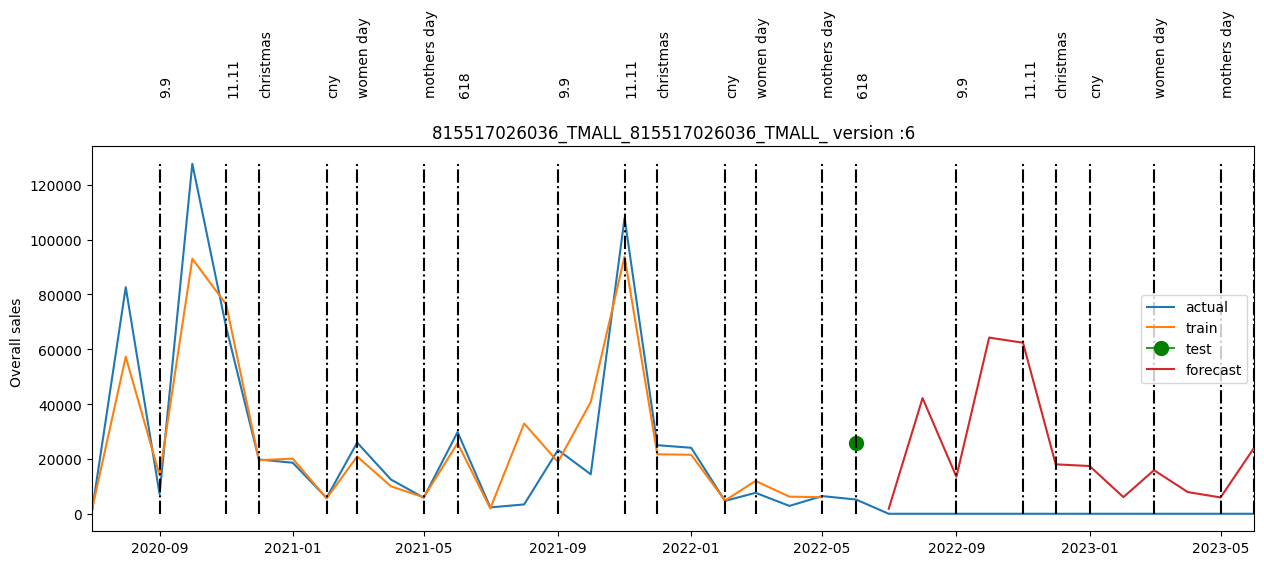

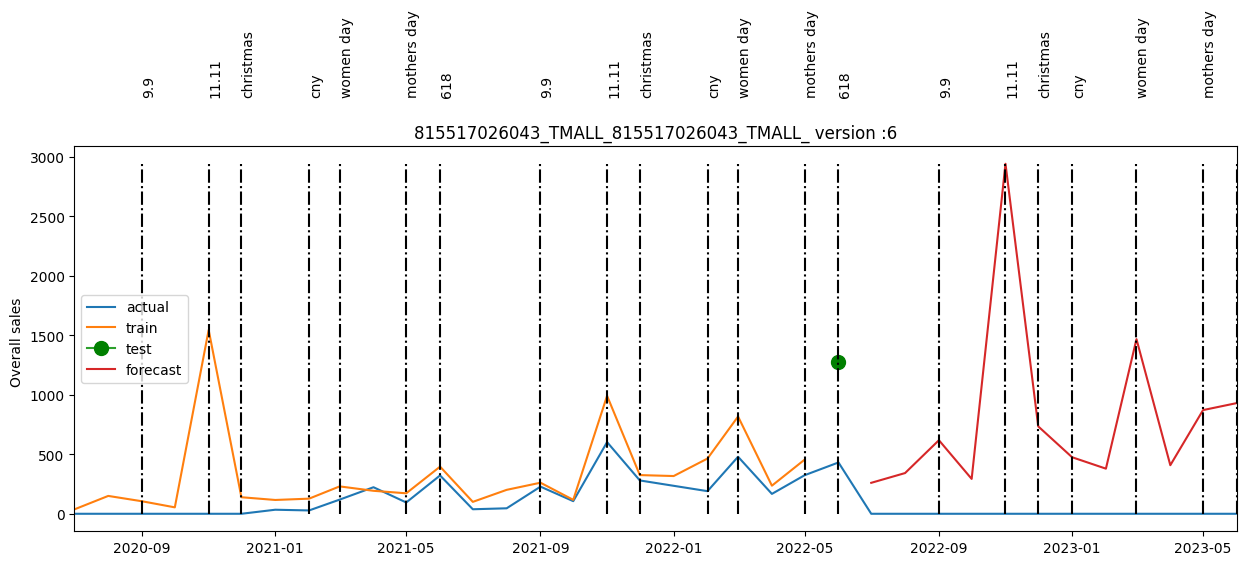

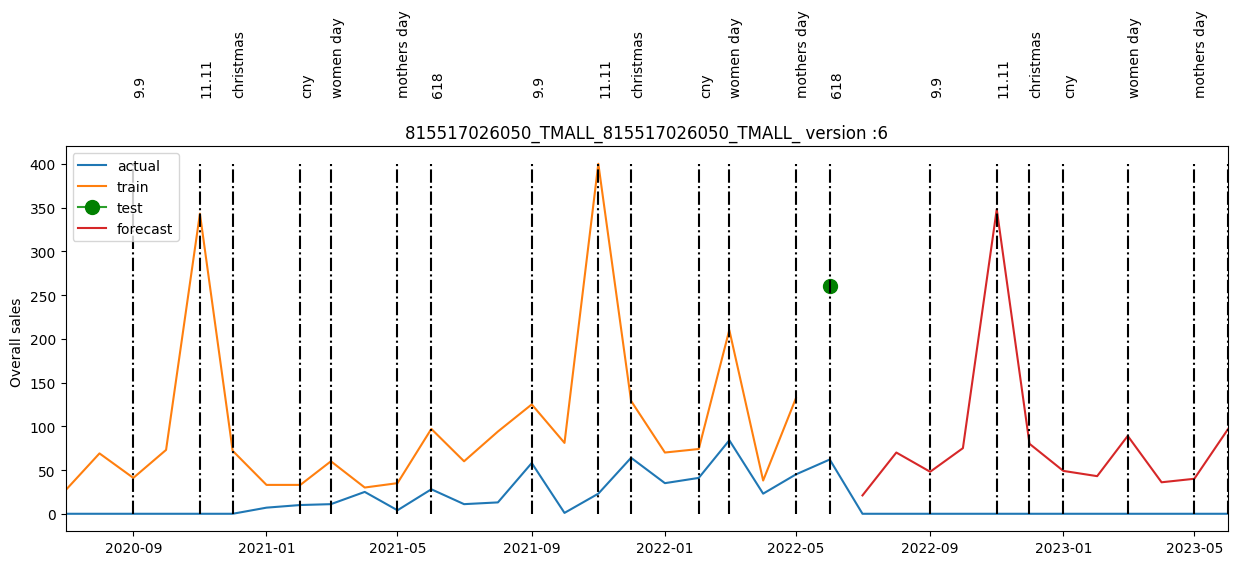

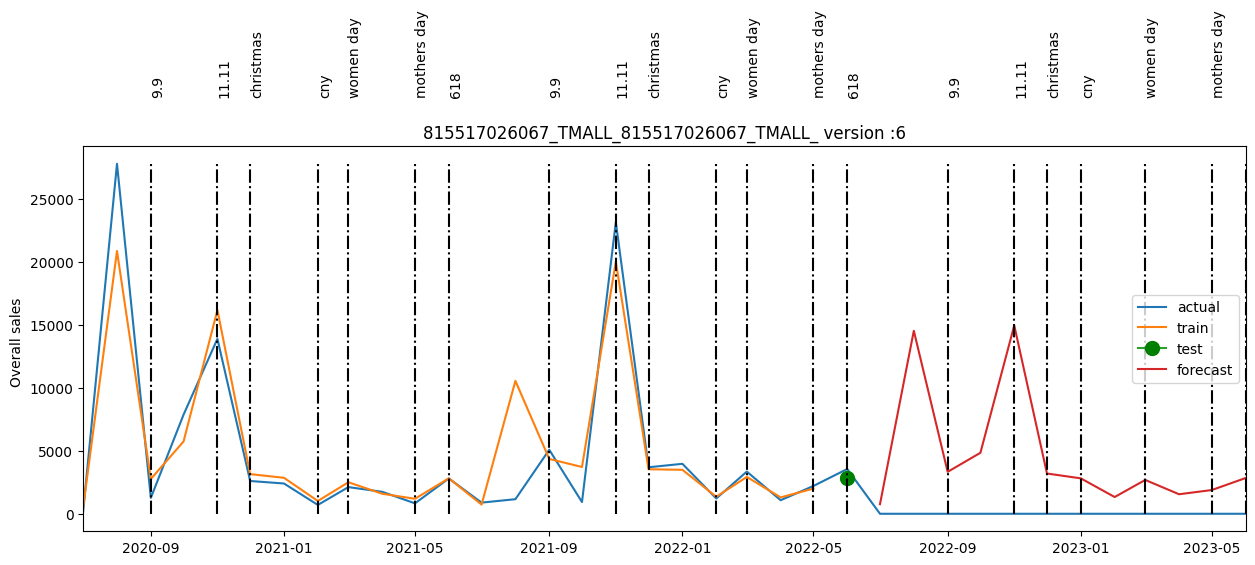

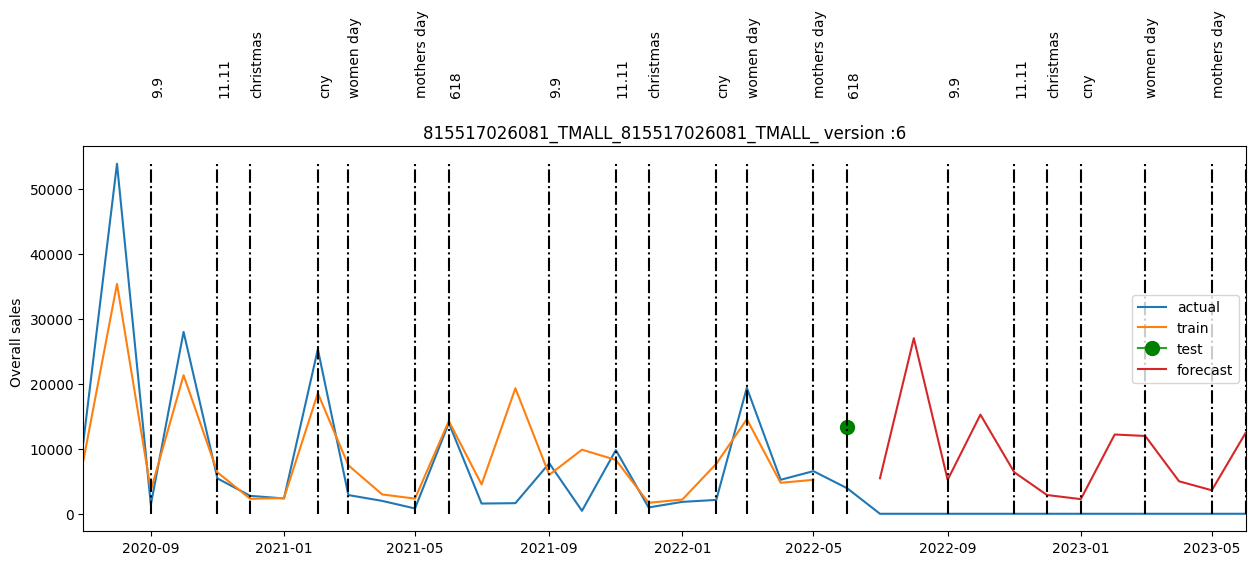

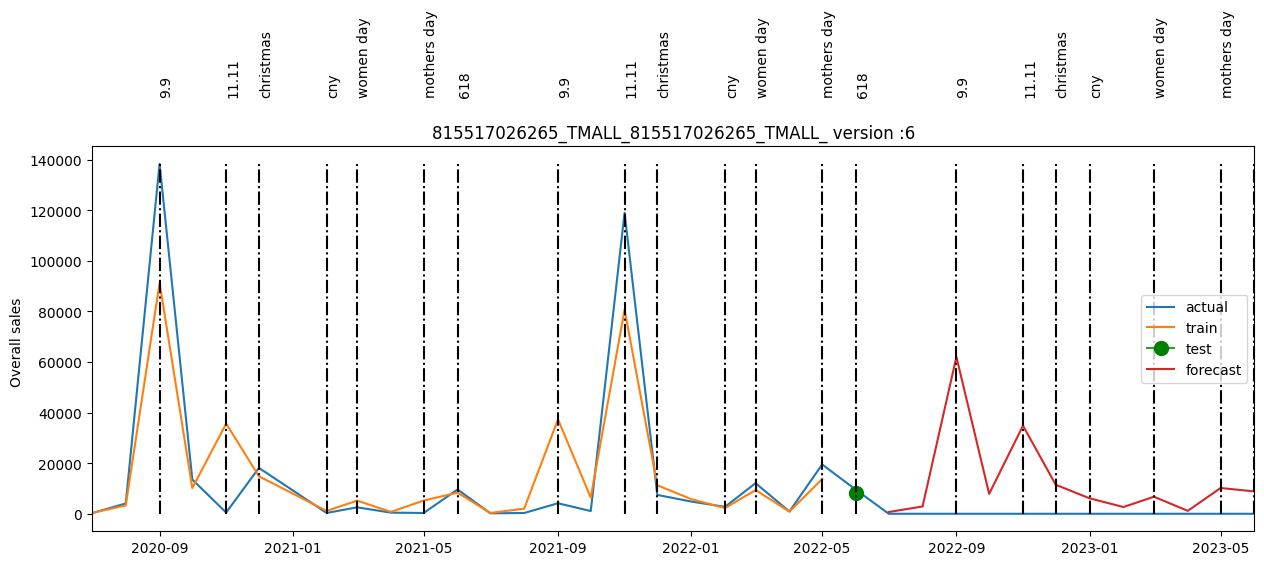

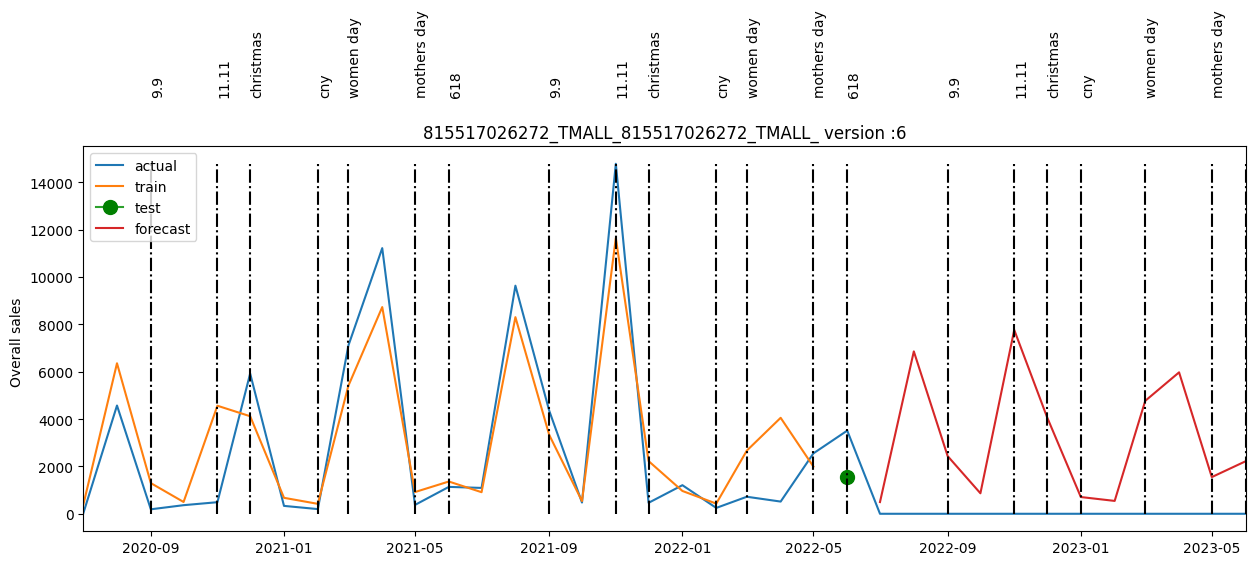

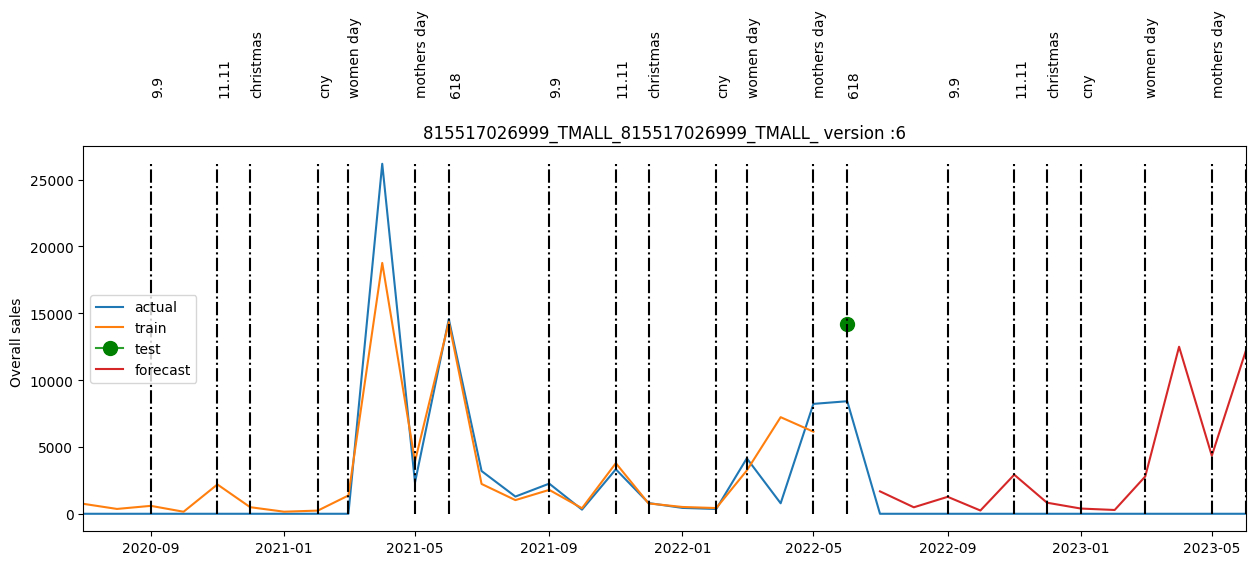

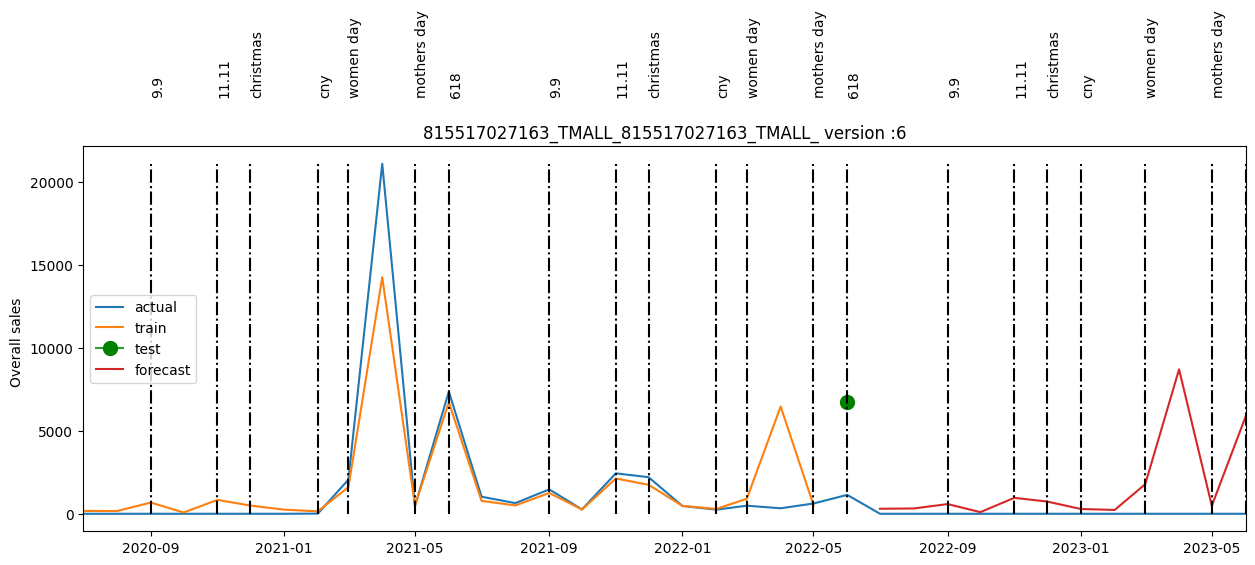

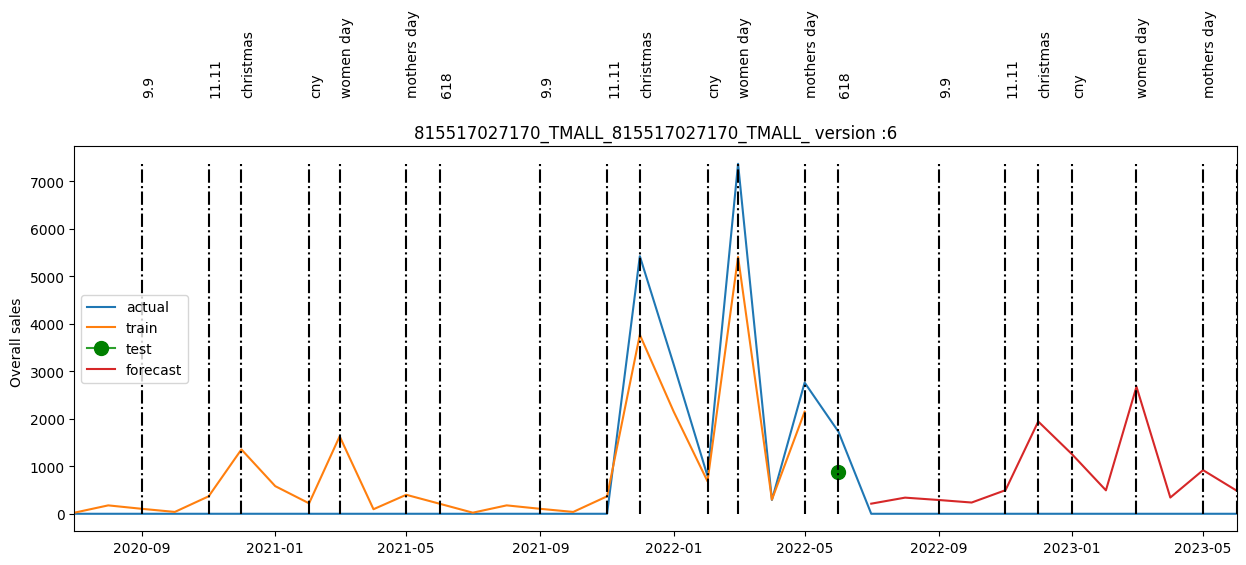

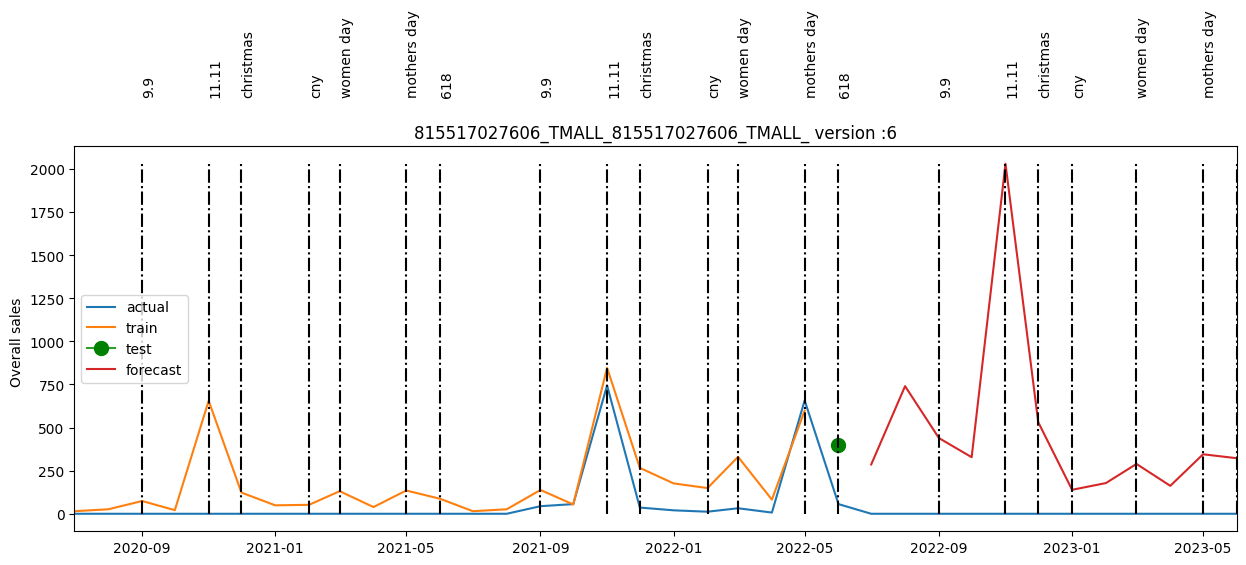

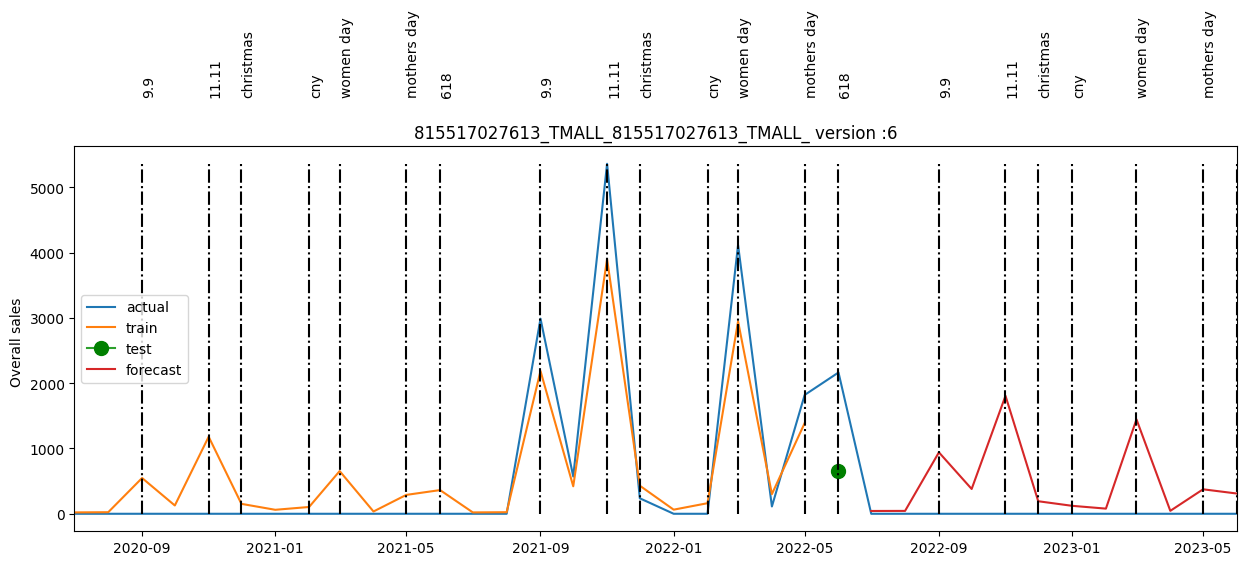

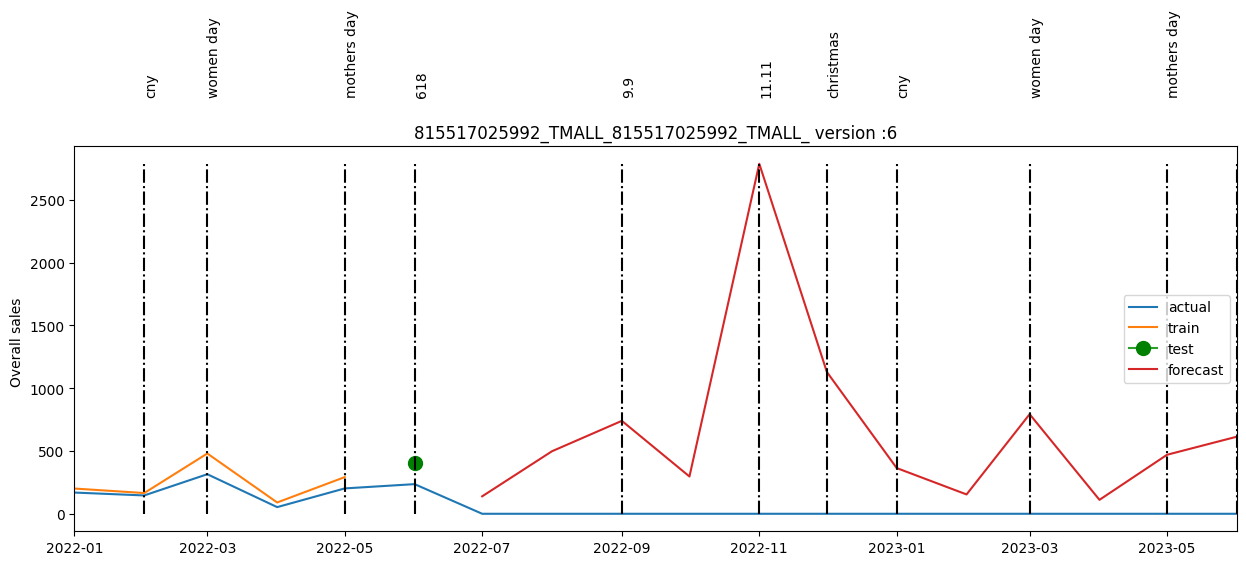

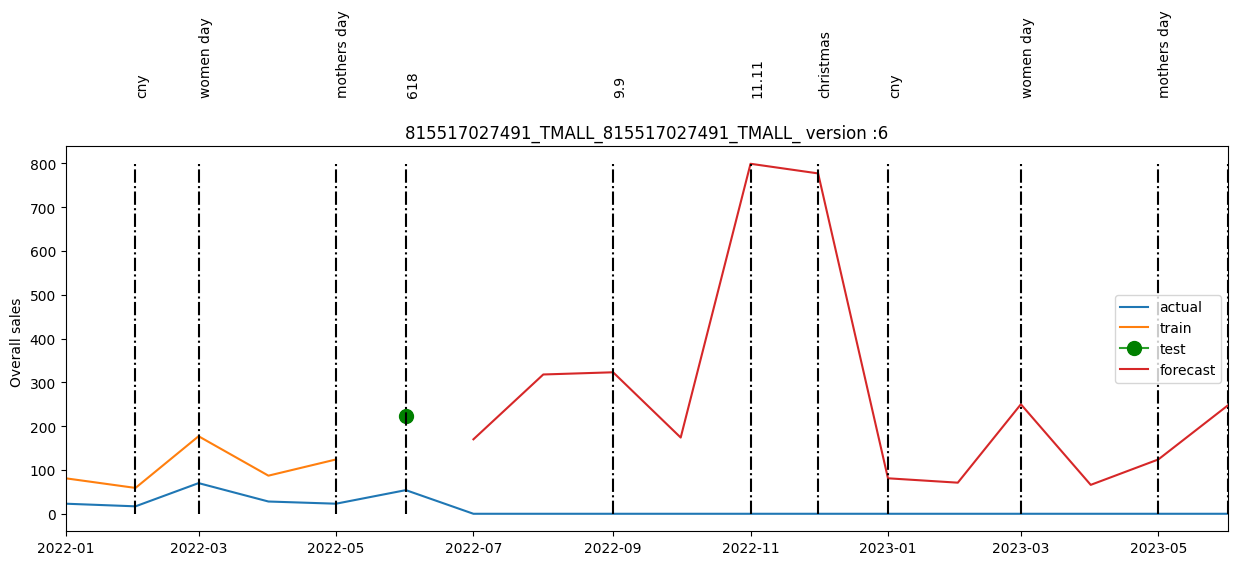

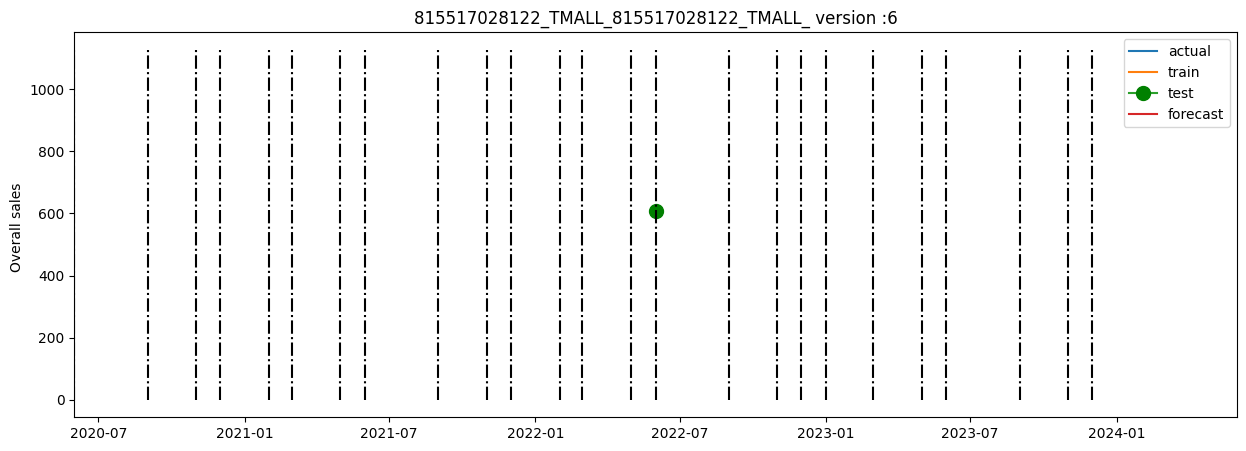

In [164]:
for i in range(len(versions)):
    this_predict = predict_df.loc[predict_df.version == versions[i]]
    this_predict['sku_cust'] = this_predict['sku'].astype(str) + "_" + this_predict['customer']
    sku_custs =  this_predict.sku_cust.unique()
    for this_sku_cust in sku_custs :
        this_ts = this_predict[this_predict['sku_cust'] == this_sku_cust]
        sku_desc = this_ts.sku_cust.unique()[0]
        ts = this_ts.fillna(0).groupby("ts").sum().reset_index()
        train = ts.loc[ts.ts < all_dates[versions[i]]["test"][0]]
        test = ts.loc[ts.ts.isin(all_dates[versions[i]]["test"])]
        forecasts = ts.loc[ts.ts.isin(all_dates[versions[i]]["forecast"])]

        _max = ts[["y", "yhat"]].max().max()

        plt.figure(figsize=(15,5))
        plt.plot(ts.ts, ts.y, label="actual")

        plt.plot(train.ts, train.yhat, label="train")

        if(test.shape[0] ==1):
            plt.plot(test.ts,  test.yhat, marker="o", markersize=10, markeredgecolor="green", markerfacecolor="green", label="test")
        else:
            plt.plot(test.ts, test.yhat, label="test")


        plt.plot(forecasts.ts, forecasts.yhat, label="forecast")
        for j in range(len(events)):
            plt.plot([events.ds[j], events.ds[j]], [0, _max], "k-.")
            if (events.ds[j] > ts.ts.min()) and (events.ds[j] < ts.ts.max()):
                plt.text(events.ds[j], _max*1.2, events.holiday[j], rotation=90)
        plt.xlim([ts.ts.min(), ts.ts.max()])
       # plt.ylim([0, predict_df.yhat.max()])
        plt.ylabel("Overall sales ")
        plt.title(sku_desc + "_" + this_sku_cust + "_ version :" + str(versions[i]))
        plt.legend()
        plt.show()

In [ ]:
results[ (results['sku'] == 815517026272)]

In [ ]:
results = pd.DataFrame()
for i in range(len(versions)):
    this_version = versions[i]
    this_ts = predict_df.loc[(predict_df["version"] == this_version) ].reset_index(drop=True)
    for _id in this_ts.id.unique():
        ts = this_ts.loc[(this_ts["id"] == _id) ].reset_index(drop=True)
        test = ts.loc[ts.ts.isin(all_dates[versions[i]]["test"]) | ts.ts.isin(all_dates[versions[i]]["val"])].copy()

        metrics = calc_metrics(test.y, test.yhat)
        metrics.update({
            "version":this_version,
            "id": _id,
            "sku": ts["sku"][0],
            "customer": ts["customer"][0],
            "test_start": all_dates[versions[i]]["val"][0],
            "test_end": all_dates[versions[i]]["test"][-1],
            "total_actual": test.y.sum(),
            "total_forecast": test.yhat.sum(),
        })
        results = results.append(metrics, ignore_index=True, sort=False)

main_cols = ["version", "id", "sku", "customer", "test_start", "test_end", "total_actual", "total_forecast"]
results = results[main_cols + list(results.drop(columns=main_cols).columns)].copy()
results["sp1"] = results["total_actual"] / results["total_forecast"]
results["sp1"] = np.nan_to_num(results["sp1"], nan=1, posinf=0, neginf=0)
results["model"] = predict_df.model[0]
results


In [ ]:
results_att = results.copy()
results_att.drop(columns={'id'},inplace=True)
print(results_att.shape)
print(att_df.columns)
att_df1 = att_df[['cases', 'customer', 'item_type', 'material', 'ph_level2', 'ph_level3',
       'sku', 'sku_description', 'uom']].drop_duplicates()
print(results_att.shape)
results_att = pd.merge(results_att,att_df1,on=['sku','customer'])
print(results_att.shape)
results_att.head()

In [ ]:
results_att[ (results_att['version'] == 8) & results_att

In [ ]:
att_df1[att_df1['sku'] == 815517026005]

In [ ]:


ts = predict_df.copy()
test_res = ts.loc[ts.ts.isin(all_dates[versions[i]]["val"]) | ts.ts.isin(all_dates[versions[i]]["test"])].copy().reset_index(drop=True)
main_cols = ["version", "id", "sku", "customer", "ts", "y", "yhat"]
test_res.rename(columns={'y':'total_actual','yhat':'total_forecast'},inplace=True)
test_res = test_res[["version", "id", "ts", "sku", "customer","total_actual", "total_forecast"]]
test_res["sp1"] = test_res["total_actual"] / test_res["total_forecast"]
test_res["sp1"] = np.nan_to_num(test_res["sp1"], nan=1, posinf=0, neginf=0)
print(test_res.shape)
test_res = pd.merge(test_res,att_df1,on=['sku','customer'])
print(test_res.shape)
test_res.head()

In [ ]:
att_main = pd.read_excel('Attribute_and_data_points.xlsx', sheet_name='Attributes_China')
att_main.rename(columns={'SKU Description':'sku_description','Level2':'ph_level2','sku type':'item_type','units':'uom'},inplace=True)
att_main['ph_level3'] = 'FAB'
att_main = att_main[['sku','shortname']]
att_main                

In [ ]:
results_att = pd.merge(results_att,att_main,on='sku')
test_res = pd.merge(test_res,att_main,on='sku')
test_res['sp1'] = test_res['sp1'].round(2)
results_att['sp1'] = results_att['sp1'].round(2)

In [ ]:
import write_data_table
write_data_table.send_data(results_att,'sp1_china','w7')
write_data_table.send_data(test_res,'sp1_detail_china','w7')


In [ ]:
for i in range(len(versions)):
    this_predict = predict_df.loc[predict_df.version == versions[i]]
    this_predict['sku_cust'] = this_predict['sku'].astype(str) + "_" + this_predict['customer']
    sku_custs =  this_predict.sku_cust.unique()
    for this_sku_cust in sku_custs :
        this_ts = this_predict[this_predict['sku_cust'] == this_sku_cust]
        sku_desc = this_ts.sku_description.unique()[0]
        ts = this_ts.fillna(0).groupby("ts").sum().reset_index()
        train = ts.loc[ts.ts < all_dates[versions[i]]["val"][0]]
        val = ts.loc[ts.ts.isin(all_dates[versions[i]]["val"])]
        test = ts.loc[ts.ts.isin(all_dates[versions[i]]["test"])]
        forecasts = ts.loc[ts.ts.isin(all_dates[versions[i]]["forecast"])]

        _max = ts[["y", "yhat"]].max().max()

        plt.figure(figsize=(15,5))
        plt.plot(ts.ts, ts.y, label="actual")

        plt.plot(train.ts, train.yhat, label="train")


        if(val.shape[0] ==1):
            plt.plot(val.ts,  val.yhat, marker="o", markersize=10, markeredgecolor="green", markerfacecolor="green", label="val")
        else:
            plt.plot(val.ts, val.yhat, label="val")

        if(test.shape[0] ==1):
            plt.plot(test.ts,  test.yhat, marker="o", markersize=10, markeredgecolor="green", markerfacecolor="green", label="test")
        else:
            plt.plot(test.ts, test.yhat, label="test")


        plt.plot(forecasts.ts, forecasts.yhat, label="forecast")
        for j in range(len(events)):
            plt.plot([events.ds[j], events.ds[j]], [0, _max], "k-.")
            if (events.ds[j] > ts.ts.min()) and (events.ds[j] < ts.ts.max()):
                plt.text(events.ds[j], _max*1.2, events.holiday[j], rotation=90)
        plt.xlim([ts.ts.min(), ts.ts.max()])
       # plt.ylim([0, predict_df.yhat.max()])
        plt.ylabel("Overall sales ")
        plt.title(sku_desc + "_" + this_sku_cust)
        plt.legend()
        plt.show()

In [ ]:
for i in range(len(versions)):
    this_predict = predict_df.loc[predict_df.version == versions[i]]
    skus =  this_predict.sku.unique()
    for this_sku in skus :
        this_ts = this_predict[this_predict['sku'] == this_sku]
        sku_desc = this_ts.sku_description.unique()[0]
        ts = this_ts.fillna(0).groupby("ts").sum().reset_index()
        train = ts.loc[ts.ts < all_dates[versions[i]]["val"][0]]
        val = ts.loc[ts.ts.isin(all_dates[versions[i]]["val"])]
        test = ts.loc[ts.ts.isin(all_dates[versions[i]]["test"])]
        forecasts = ts.loc[ts.ts.isin(all_dates[versions[i]]["forecast"])]

        _max = ts[["y", "yhat"]].max().max()

        plt.figure(figsize=(15,5))
        plt.plot(ts.ts, ts.y, label="actual")

        plt.plot(train.ts, train.yhat, label="train")


        if(val.shape[0] ==1):
            plt.plot(val.ts,  val.yhat, marker="o", markersize=10, markeredgecolor="green", markerfacecolor="green", label="val")
        else:
            plt.plot(val.ts, val.yhat, label="val")

        if(test.shape[0] ==1):
            plt.plot(test.ts,  test.yhat, marker="o", markersize=10, markeredgecolor="green", markerfacecolor="green", label="test")
        else:
            plt.plot(test.ts, test.yhat, label="test")


        plt.plot(forecasts.ts, forecasts.yhat, label="forecast")
        for j in range(len(events)):
            plt.plot([events.ds[j], events.ds[j]], [0, _max], "k-.")
            if (events.ds[j] > ts.ts.min()) and (events.ds[j] < ts.ts.max()):
                plt.text(events.ds[j], _max*1.2, events.holiday[j], rotation=90)
        plt.xlim([ts.ts.min(), ts.ts.max()])
       # plt.ylim([0, predict_df.yhat.max()])
        plt.ylabel("Overall sales ")
        plt.title(sku_desc)
        plt.legend()
        plt.show()

In [ ]:
dc_offtake = pd.read_csv("offtake_china.csv")
print(dc_offtake.shape)
dc_offtake = dc_offtake[['sku','customer','warehouse','offtake_percent_dc']].drop_duplicates()
print(dc_offtake.shape)
dc_offtake.head()

In [ ]:
dc_offtake[dc_offtake['sku'] == 815517025992]

In [ ]:
predict_df_dc = predict_df[['ts','sku','customer', 'yhat', 'y']]
print(predict_df_dc.shape)
predict_df_dc = pd.merge(predict_df_dc,dc_offtake,on=['sku','customer'],how='left')
print(predict_df_dc.shape)
predict_df_dc['yhat_dc'] = predict_df_dc['yhat']*predict_df_dc['offtake_percent_dc']/100
predict_df_dc['yhat_dc'] = predict_df_dc['yhat_dc'].astype('int64')
predict_df_dc['y_dc'] = predict_df_dc['y']*predict_df_dc['offtake_percent_dc']/100
predict_df_dc['y_dc'].fillna(0,inplace=True)
predict_df_dc['y_dc'] = predict_df_dc['y_dc'].astype('int64')
predict_df_dc

In [ ]:
att_df_main = att_df[['id','sku','customer','warehouse']]
predict_df_dc_final = pd.merge(predict_df_dc,att_df_main,on=['sku','customer','warehouse'],how='left')
predict_df_dc_final.head()

In [ ]:
replenishment_op = predict_df_dc_final.copy()
replenishment_op.rename(columns={'y_dc':'demand'},inplace=True)
replenishment_op.drop(columns={'offtake_percent_dc','id'},inplace=True)
replenishment_op["ts"] = pd.to_datetime(replenishment_op["ts"])
replenishment_op['type'] = 'Actuals'
replenishment_op.loc[replenishment_op['ts'].isin(all_dates[versions[0]]['forecast']),'type'] = 'Forecast'
replenishment_op = replenishment_op[['ts','sku','customer','warehouse','demand','yhat_dc']]
replenishment_op.loc[replenishment_op['ts'].isin(all_dates[versions[0]]['forecast']),'demand'] = replenishment_op.loc[replenishment_op['ts'].isin(all_dates[versions[0]]['forecast']),'yhat_dc'] 
replenishment_op.drop(columns={'yhat_dc'},inplace=True)
replenishment_op.head()

In [ ]:
replenishment_op.to_csv("actuals_forecast_china.csv")

In [ ]:
predict_df["ts"] = predict_df["ts"].astype("datetime64[ns]")
predict_df["id"] = predict_df["id"].astype("uint64")
predict_df["y"] = predict_df["y"].astype("float64")

val_df = predict_df.loc[predict_df.ts.isin(all_dates[m]['test'][-2:-1])].reset_index(drop=True)
test_df = predict_df.loc[predict_df.ts.isin(all_dates[m]['test'][-1:])].reset_index(drop=True)
predict_df = predict_df.loc[predict_df.ts.isin(all_dates[m]['forecast'])].reset_index(drop=True)
val_df = val_df[["ts", "id", "yhat"]].copy()
val_df.rename(columns={"yhat": "y"}, inplace=True)
predict_df = predict_df[["ts", "id", "yhat"]].copy()
predict_df.rename(columns={"yhat": "y"}, inplace=True)
test_df = test_df[["ts", "id", "yhat"]].copy()
test_df.rename(columns={"yhat": "y"}, inplace=True)

valid_df = lambda df : all([x in df.columns for x in ['ts', 'id', 'y']])


In [ ]:

## Validate df structure
if not valid_df(val_df):
    raise ValueError("Validate Dataframe columns are not compliant")
    
## Test df structure
if not valid_df(test_df):
    raise ValueError("Test Dataframe columns are not compliant")
    
## Predict df structure
if not valid_df(predict_df):
    raise ValueError("Predict Dataframe columns are not compliant")
    
def save_parquet(data, file_path, index=None):
    data = data[['ts', 'id', 'y']]
    mapping = {c: str for c in data.columns if data[c].dtype == object}
    data.astype(mapping).to_parquet(file_path, index=index)
    return file_path

# replace df below with dataframe with test and prediction outputs
predict_ts_path = save_parquet(predict_df, predict_ts_path, False)
test_ts_path = save_parquet(val_df, test_ts_path, False)
validate_ts_path = save_parquet(test_df, validate_ts_path, False)